### Business Problem
A radiology consultancy looking to automate some of their work. While the consultancy as a whole specializes in providing detailed analyses of radiographs, a particularly common task for the consultancy is identifying cases of pneumonia from chest x-rays. Using neural networks, it may be possible to identify these cases more effieciently than through manual analysis, saving both time and money.

In [32]:
import os
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd
from PIL import Image
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG19
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [2]:
n_train_normal = len(os.listdir('../data/train/NORMAL'))
n_train_pneumonia = len(os.listdir('../data/train/PNEUMONIA'))

n_test_normal = len(os.listdir('../data/test/NORMAL'))
n_test_pneumonia = len(os.listdir('../data/test/PNEUMONIA'))

n_val_normal = len(os.listdir('../data/val/NORMAL'))
n_val_pneumonia = len(os.listdir('../data/val/PNEUMONIA'))

n_total_normal = n_train_normal + n_test_normal + n_val_normal
n_total_pneumonia = n_train_pneumonia + n_test_pneumonia + n_val_pneumonia
n_total_all = n_total_normal + n_total_pneumonia
percentage_normal = n_total_normal/n_total_all
percentage_pneumonia = n_total_pneumonia/n_total_all

print('Total images:', n_total_all)
print('Total normal images:', n_total_normal)
print('Total pneumonia images:', n_total_pneumonia)
print('Train set counts (Normal, Pneumonia):', str(n_train_normal) + ',', n_train_pneumonia)
print('Test set counts (Normal, Pneumonia):', str(n_test_normal) + ',', n_test_pneumonia)
print('Validation set counts (Normal, Pneumonia):', str(n_val_normal) + ',', n_val_pneumonia)
print('Percentage image distribution (Normal, Pneumonia)', 
      "{:.2%}".format(percentage_normal) + ',', 
      "{:.2%}".format(percentage_pneumonia))

Total images: 5856
Total normal images: 1583
Total pneumonia images: 4273
Train set counts (Normal, Pneumonia): 1267, 3419
Test set counts (Normal, Pneumonia): 158, 427
Validation set counts (Normal, Pneumonia): 158, 427
Percentage image distribution (Normal, Pneumonia) 27.03%, 72.97%


NORMAL
IM-0115-0001.jpeg
start 0


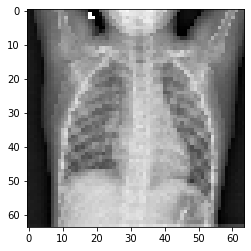

IM-0117-0001.jpeg
start 1


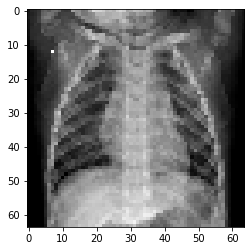

IM-0119-0001.jpeg
start 2


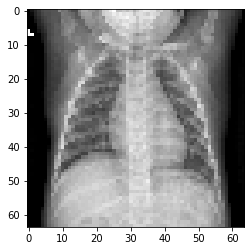

PNEUMONIA
person1000_bacteria_2931.jpeg
start 0


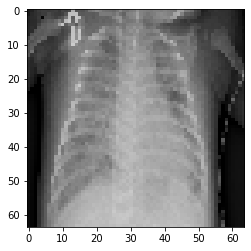

person1000_virus_1681.jpeg
start 1


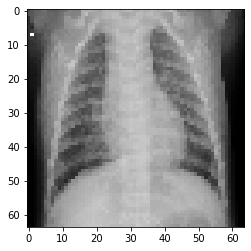

person1001_bacteria_2932.jpeg
start 2


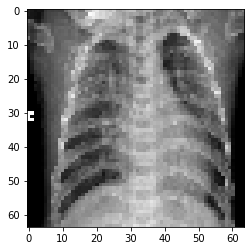

In [3]:
#U
path = '../data/train/'
for folder in os.listdir(path):
    print(folder)
    w = 0
    for filename in os.listdir(path+folder):
        if w < 3:
            print(filename)
            print('start', w)
            img = load_img(path+folder+'/'+filename, target_size=(64,64))
            plt.imshow(img)
            plt.show()
        w += 1

### Data Preprocessing
The images are arranged into train, test, and validation sets.

Then, the images have their sizes standardized.
The images are resized to ensure input consistency and allow for efficient training performance.
Then, the resized images are arranged into train, test, and validation sets.

In the case of some models, data augmentation is also implemented, applying various transformations to the training set.


In [3]:
#data dirs
train_dir = '../data/train'
test_dir = '../data/test'
val_dir = '../data/val'

#image sizes aren't standard
#preprocess and save to new dir
dirs = [train_dir, test_dir, val_dir]

image_sizes = [512, 128, 64]

for size in image_sizes:
    print('Resizing to', size)
    for data_dir in dirs:
        print('Starting on dir', data_dir)
        for folder in os.listdir(data_dir):
            new_path = data_dir + '/' + folder
            for img_path in os.listdir(new_path):
                full_path = new_path + '/' + img_path
                print(full_path)
                preprocess_path = full_path[:8] + 'resized' + str(size) + '/' + full_path[8:]

                img = Image.open(full_path)
                new_width  = size
                new_height = size
                img = img.resize((new_width, new_height), Image.ANTIALIAS)
                img.save(preprocess_path)
                print(preprocess_path)
                print('----------')

Resizing to 512
Starting on dir ../data/train
../data/train/NORMAL/IM-0115-0001.jpeg
../data/resized512/train/NORMAL/IM-0115-0001.jpeg
----------
../data/train/NORMAL/IM-0117-0001.jpeg
../data/resized512/train/NORMAL/IM-0117-0001.jpeg
----------
../data/train/NORMAL/IM-0119-0001.jpeg
../data/resized512/train/NORMAL/IM-0119-0001.jpeg
----------
../data/train/NORMAL/IM-0122-0001.jpeg
../data/resized512/train/NORMAL/IM-0122-0001.jpeg
----------
../data/train/NORMAL/IM-0125-0001.jpeg
../data/resized512/train/NORMAL/IM-0125-0001.jpeg
----------
../data/train/NORMAL/IM-0127-0001.jpeg
../data/resized512/train/NORMAL/IM-0127-0001.jpeg
----------
../data/train/NORMAL/IM-0128-0001.jpeg
../data/resized512/train/NORMAL/IM-0128-0001.jpeg
----------
../data/train/NORMAL/IM-0129-0001.jpeg
../data/resized512/train/NORMAL/IM-0129-0001.jpeg
----------
../data/train/NORMAL/IM-0131-0001.jpeg
../data/resized512/train/NORMAL/IM-0131-0001.jpeg
----------
../data/train/NORMAL/IM-0133-0001.jpeg
../data/resized

../data/resized512/train/NORMAL/IM-0249-0001.jpeg
----------
../data/train/NORMAL/IM-0250-0001.jpeg
../data/resized512/train/NORMAL/IM-0250-0001.jpeg
----------
../data/train/NORMAL/IM-0251-0001.jpeg
../data/resized512/train/NORMAL/IM-0251-0001.jpeg
----------
../data/train/NORMAL/IM-0253-0001.jpeg
../data/resized512/train/NORMAL/IM-0253-0001.jpeg
----------
../data/train/NORMAL/IM-0255-0001.jpeg
../data/resized512/train/NORMAL/IM-0255-0001.jpeg
----------
../data/train/NORMAL/IM-0256-0001.jpeg
../data/resized512/train/NORMAL/IM-0256-0001.jpeg
----------
../data/train/NORMAL/IM-0257-0001.jpeg
../data/resized512/train/NORMAL/IM-0257-0001.jpeg
----------
../data/train/NORMAL/IM-0261-0001.jpeg
../data/resized512/train/NORMAL/IM-0261-0001.jpeg
----------
../data/train/NORMAL/IM-0262-0001.jpeg
../data/resized512/train/NORMAL/IM-0262-0001.jpeg
----------
../data/train/NORMAL/IM-0264-0001.jpeg
../data/resized512/train/NORMAL/IM-0264-0001.jpeg
----------
../data/train/NORMAL/IM-0265-0001.jpeg


../data/resized512/train/NORMAL/IM-0353-0001.jpeg
----------
../data/train/NORMAL/IM-0354-0001.jpeg
../data/resized512/train/NORMAL/IM-0354-0001.jpeg
----------
../data/train/NORMAL/IM-0355-0001.jpeg
../data/resized512/train/NORMAL/IM-0355-0001.jpeg
----------
../data/train/NORMAL/IM-0356-0001.jpeg
../data/resized512/train/NORMAL/IM-0356-0001.jpeg
----------
../data/train/NORMAL/IM-0357-0001.jpeg
../data/resized512/train/NORMAL/IM-0357-0001.jpeg
----------
../data/train/NORMAL/IM-0358-0001.jpeg
../data/resized512/train/NORMAL/IM-0358-0001.jpeg
----------
../data/train/NORMAL/IM-0359-0001.jpeg
../data/resized512/train/NORMAL/IM-0359-0001.jpeg
----------
../data/train/NORMAL/IM-0361-0001.jpeg
../data/resized512/train/NORMAL/IM-0361-0001.jpeg
----------
../data/train/NORMAL/IM-0362-0001.jpeg
../data/resized512/train/NORMAL/IM-0362-0001.jpeg
----------
../data/train/NORMAL/IM-0363-0001.jpeg
../data/resized512/train/NORMAL/IM-0363-0001.jpeg
----------
../data/train/NORMAL/IM-0364-0001.jpeg


../data/resized512/train/NORMAL/IM-0450-0001.jpeg
----------
../data/train/NORMAL/IM-0451-0001.jpeg
../data/resized512/train/NORMAL/IM-0451-0001.jpeg
----------
../data/train/NORMAL/IM-0452-0001.jpeg
../data/resized512/train/NORMAL/IM-0452-0001.jpeg
----------
../data/train/NORMAL/IM-0453-0001-0002.jpeg
../data/resized512/train/NORMAL/IM-0453-0001-0002.jpeg
----------
../data/train/NORMAL/IM-0453-0001.jpeg
../data/resized512/train/NORMAL/IM-0453-0001.jpeg
----------
../data/train/NORMAL/IM-0455-0001.jpeg
../data/resized512/train/NORMAL/IM-0455-0001.jpeg
----------
../data/train/NORMAL/IM-0456-0001.jpeg
../data/resized512/train/NORMAL/IM-0456-0001.jpeg
----------
../data/train/NORMAL/IM-0457-0001.jpeg
../data/resized512/train/NORMAL/IM-0457-0001.jpeg
----------
../data/train/NORMAL/IM-0458-0001.jpeg
../data/resized512/train/NORMAL/IM-0458-0001.jpeg
----------
../data/train/NORMAL/IM-0459-0001.jpeg
../data/resized512/train/NORMAL/IM-0459-0001.jpeg
----------
../data/train/NORMAL/IM-0460-

../data/resized512/train/NORMAL/IM-0519-0001-0002.jpeg
----------
../data/train/NORMAL/IM-0519-0001.jpeg
../data/resized512/train/NORMAL/IM-0519-0001.jpeg
----------
../data/train/NORMAL/IM-0520-0001.jpeg
../data/resized512/train/NORMAL/IM-0520-0001.jpeg
----------
../data/train/NORMAL/IM-0521-0001.jpeg
../data/resized512/train/NORMAL/IM-0521-0001.jpeg
----------
../data/train/NORMAL/IM-0522-0001.jpeg
../data/resized512/train/NORMAL/IM-0522-0001.jpeg
----------
../data/train/NORMAL/IM-0523-0001-0001.jpeg
../data/resized512/train/NORMAL/IM-0523-0001-0001.jpeg
----------
../data/train/NORMAL/IM-0523-0001-0002.jpeg
../data/resized512/train/NORMAL/IM-0523-0001-0002.jpeg
----------
../data/train/NORMAL/IM-0523-0001-0003.jpeg
../data/resized512/train/NORMAL/IM-0523-0001-0003.jpeg
----------
../data/train/NORMAL/IM-0523-0001.jpeg
../data/resized512/train/NORMAL/IM-0523-0001.jpeg
----------
../data/train/NORMAL/IM-0524-0001.jpeg
../data/resized512/train/NORMAL/IM-0524-0001.jpeg
----------
../d

../data/resized512/train/NORMAL/IM-0583-0001.jpeg
----------
../data/train/NORMAL/IM-0584-0001.jpeg
../data/resized512/train/NORMAL/IM-0584-0001.jpeg
----------
../data/train/NORMAL/IM-0586-0001.jpeg
../data/resized512/train/NORMAL/IM-0586-0001.jpeg
----------
../data/train/NORMAL/IM-0588-0001.jpeg
../data/resized512/train/NORMAL/IM-0588-0001.jpeg
----------
../data/train/NORMAL/IM-0590-0001.jpeg
../data/resized512/train/NORMAL/IM-0590-0001.jpeg
----------
../data/train/NORMAL/IM-0591-0001.jpeg
../data/resized512/train/NORMAL/IM-0591-0001.jpeg
----------
../data/train/NORMAL/IM-0592-0001.jpeg
../data/resized512/train/NORMAL/IM-0592-0001.jpeg
----------
../data/train/NORMAL/IM-0593-0001.jpeg
../data/resized512/train/NORMAL/IM-0593-0001.jpeg
----------
../data/train/NORMAL/IM-0595-0001.jpeg
../data/resized512/train/NORMAL/IM-0595-0001.jpeg
----------
../data/train/NORMAL/IM-0596-0001.jpeg
../data/resized512/train/NORMAL/IM-0596-0001.jpeg
----------
../data/train/NORMAL/IM-0598-0001.jpeg


../data/resized512/train/NORMAL/IM-0650-0001.jpeg
----------
../data/train/NORMAL/IM-0651-0001.jpeg
../data/resized512/train/NORMAL/IM-0651-0001.jpeg
----------
../data/train/NORMAL/IM-0652-0001-0002.jpeg
../data/resized512/train/NORMAL/IM-0652-0001-0002.jpeg
----------
../data/train/NORMAL/IM-0652-0001.jpeg
../data/resized512/train/NORMAL/IM-0652-0001.jpeg
----------
../data/train/NORMAL/IM-0654-0001.jpeg
../data/resized512/train/NORMAL/IM-0654-0001.jpeg
----------
../data/train/NORMAL/IM-0655-0001.jpeg
../data/resized512/train/NORMAL/IM-0655-0001.jpeg
----------
../data/train/NORMAL/IM-0656-0001-0001.jpeg
../data/resized512/train/NORMAL/IM-0656-0001-0001.jpeg
----------
../data/train/NORMAL/IM-0656-0001-0002.jpeg
../data/resized512/train/NORMAL/IM-0656-0001-0002.jpeg
----------
../data/train/NORMAL/IM-0656-0001.jpeg
../data/resized512/train/NORMAL/IM-0656-0001.jpeg
----------
../data/train/NORMAL/IM-0657-0001.jpeg
../data/resized512/train/NORMAL/IM-0657-0001.jpeg
----------
../data/t

../data/resized512/train/NORMAL/IM-0734-0001.jpeg
----------
../data/train/NORMAL/IM-0735-0001.jpeg
../data/resized512/train/NORMAL/IM-0735-0001.jpeg
----------
../data/train/NORMAL/IM-0736-0001.jpeg
../data/resized512/train/NORMAL/IM-0736-0001.jpeg
----------
../data/train/NORMAL/IM-0737-0001.jpeg
../data/resized512/train/NORMAL/IM-0737-0001.jpeg
----------
../data/train/NORMAL/IM-0738-0001.jpeg
../data/resized512/train/NORMAL/IM-0738-0001.jpeg
----------
../data/train/NORMAL/IM-0739-0001.jpeg
../data/resized512/train/NORMAL/IM-0739-0001.jpeg
----------
../data/train/NORMAL/IM-0740-0001.jpeg
../data/resized512/train/NORMAL/IM-0740-0001.jpeg
----------
../data/train/NORMAL/IM-0741-0001.jpeg
../data/resized512/train/NORMAL/IM-0741-0001.jpeg
----------
../data/train/NORMAL/IM-0742-0001.jpeg
../data/resized512/train/NORMAL/IM-0742-0001.jpeg
----------
../data/train/NORMAL/IM-0746-0001.jpeg
../data/resized512/train/NORMAL/IM-0746-0001.jpeg
----------
../data/train/NORMAL/IM-0747-0001.jpeg


../data/resized512/train/NORMAL/NORMAL2-IM-0448-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0449-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0449-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0450-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0450-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0451-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0451-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0452-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0452-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0453-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0453-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0454-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0454-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0455-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0455-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0456-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0456-0001.jpeg
----------
../

../data/resized512/train/NORMAL/NORMAL2-IM-0545-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0547-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0547-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0550-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0550-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0551-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0551-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0552-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0552-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0553-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0553-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0554-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0554-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0555-0001-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0555-0001-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0555-0001-0002.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0555-0001-0002

../data/resized512/train/NORMAL/NORMAL2-IM-0648-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0649-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0649-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0650-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0650-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0651-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0651-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0651-0004.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0651-0004.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0652-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0652-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0653-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0653-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0654-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0654-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0655-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0655-0001.jpeg
----------
../

../data/resized512/train/NORMAL/NORMAL2-IM-0799-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0803-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0803-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0804-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0804-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0806-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0806-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0807-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0807-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0808-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0808-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0809-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0809-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0810-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0810-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0811-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0811-0001.jpeg
----------
../

../data/resized512/train/NORMAL/NORMAL2-IM-0881-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0882-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0882-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0885-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0885-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0886-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0886-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0887-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0887-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0888-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0888-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0890-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0890-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0892-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0892-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0893-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0893-0001.jpeg
----------
../

../data/resized512/train/NORMAL/NORMAL2-IM-0971-0001-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0971-0001-0002.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0971-0001-0002.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0974-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0974-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0975-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0975-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0976-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0976-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0977-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0977-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0978-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0978-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0979-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0979-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0980-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-0980-0001.jpeg

../data/resized512/train/NORMAL/NORMAL2-IM-1055-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1056-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-1056-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1058-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-1058-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1059-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-1059-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1060-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-1060-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1062-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-1062-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1064-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-1064-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1067-0001-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-1067-0001-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1067-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-1067-0001.jpeg
----

../data/resized512/train/NORMAL/NORMAL2-IM-1152-0001-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1152-0001-0002.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-1152-0001-0002.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1152-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-1152-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1153-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-1153-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1154-0001-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-1154-0001-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1154-0001-0002.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-1154-0001-0002.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1154-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-1154-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1155-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-1155-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1156-0001.jpeg
../data/resized512/train/NORMAL/NORMA

../data/resized512/train/NORMAL/NORMAL2-IM-1243-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1244-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-1244-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1245-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-1245-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1247-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-1247-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1250-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-1250-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1252-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-1252-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1253-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-1253-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1254-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-1254-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1256-0001.jpeg
../data/resized512/train/NORMAL/NORMAL2-IM-1256-0001.jpeg
----------
../

../data/resized512/train/PNEUMONIA/person1019_bacteria_2950.jpeg
----------
../data/train/PNEUMONIA/person1019_virus_1707.jpeg
../data/resized512/train/PNEUMONIA/person1019_virus_1707.jpeg
----------
../data/train/PNEUMONIA/person1019_virus_1708.jpeg
../data/resized512/train/PNEUMONIA/person1019_virus_1708.jpeg
----------
../data/train/PNEUMONIA/person101_virus_187.jpeg
../data/resized512/train/PNEUMONIA/person101_virus_187.jpeg
----------
../data/train/PNEUMONIA/person101_virus_188.jpeg
../data/resized512/train/PNEUMONIA/person101_virus_188.jpeg
----------
../data/train/PNEUMONIA/person1020_bacteria_2951.jpeg
../data/resized512/train/PNEUMONIA/person1020_bacteria_2951.jpeg
----------
../data/train/PNEUMONIA/person1020_virus_1710.jpeg
../data/resized512/train/PNEUMONIA/person1020_virus_1710.jpeg
----------
../data/train/PNEUMONIA/person1021_virus_1711.jpeg
../data/resized512/train/PNEUMONIA/person1021_virus_1711.jpeg
----------
../data/train/PNEUMONIA/person1022_bacteria_2953.jpeg
../d

../data/resized512/train/PNEUMONIA/person1058_virus_1757.jpeg
----------
../data/train/PNEUMONIA/person1059_bacteria_2993.jpeg
../data/resized512/train/PNEUMONIA/person1059_bacteria_2993.jpeg
----------
../data/train/PNEUMONIA/person1059_virus_1758.jpeg
../data/resized512/train/PNEUMONIA/person1059_virus_1758.jpeg
----------
../data/train/PNEUMONIA/person105_virus_192.jpeg
../data/resized512/train/PNEUMONIA/person105_virus_192.jpeg
----------
../data/train/PNEUMONIA/person105_virus_193.jpeg
../data/resized512/train/PNEUMONIA/person105_virus_193.jpeg
----------
../data/train/PNEUMONIA/person1060_virus_1760.jpeg
../data/resized512/train/PNEUMONIA/person1060_virus_1760.jpeg
----------
../data/train/PNEUMONIA/person1062_bacteria_2996.jpeg
../data/resized512/train/PNEUMONIA/person1062_bacteria_2996.jpeg
----------
../data/train/PNEUMONIA/person1062_virus_1762.jpeg
../data/resized512/train/PNEUMONIA/person1062_virus_1762.jpeg
----------
../data/train/PNEUMONIA/person1063_bacteria_2997.jpeg
.

../data/resized512/train/PNEUMONIA/person1091_bacteria_3031.jpeg
----------
../data/train/PNEUMONIA/person1091_virus_1810.jpeg
../data/resized512/train/PNEUMONIA/person1091_virus_1810.jpeg
----------
../data/train/PNEUMONIA/person1092_bacteria_3032.jpeg
../data/resized512/train/PNEUMONIA/person1092_bacteria_3032.jpeg
----------
../data/train/PNEUMONIA/person1092_virus_1811.jpeg
../data/resized512/train/PNEUMONIA/person1092_virus_1811.jpeg
----------
../data/train/PNEUMONIA/person1093_bacteria_3033.jpeg
../data/resized512/train/PNEUMONIA/person1093_bacteria_3033.jpeg
----------
../data/train/PNEUMONIA/person1094_virus_1814.jpeg
../data/resized512/train/PNEUMONIA/person1094_virus_1814.jpeg
----------
../data/train/PNEUMONIA/person1095_virus_1815.jpeg
../data/resized512/train/PNEUMONIA/person1095_virus_1815.jpeg
----------
../data/train/PNEUMONIA/person1096_bacteria_3037.jpeg
../data/resized512/train/PNEUMONIA/person1096_bacteria_3037.jpeg
----------
../data/train/PNEUMONIA/person1096_vir

../data/resized512/train/PNEUMONIA/person1129_virus_1857.jpeg
----------
../data/train/PNEUMONIA/person112_virus_213.jpeg
../data/resized512/train/PNEUMONIA/person112_virus_213.jpeg
----------
../data/train/PNEUMONIA/person1130_bacteria_3072.jpeg
../data/resized512/train/PNEUMONIA/person1130_bacteria_3072.jpeg
----------
../data/train/PNEUMONIA/person1130_virus_1860.jpeg
../data/resized512/train/PNEUMONIA/person1130_virus_1860.jpeg
----------
../data/train/PNEUMONIA/person1131_bacteria_3073.jpeg
../data/resized512/train/PNEUMONIA/person1131_bacteria_3073.jpeg
----------
../data/train/PNEUMONIA/person1132_virus_1863.jpeg
../data/resized512/train/PNEUMONIA/person1132_virus_1863.jpeg
----------
../data/train/PNEUMONIA/person1133_bacteria_3075.jpeg
../data/resized512/train/PNEUMONIA/person1133_bacteria_3075.jpeg
----------
../data/train/PNEUMONIA/person1133_virus_1865.jpeg
../data/resized512/train/PNEUMONIA/person1133_virus_1865.jpeg
----------
../data/train/PNEUMONIA/person1134_bacteria_3

../data/resized512/train/PNEUMONIA/person115_virus_219.jpeg
----------
../data/train/PNEUMONIA/person1160_bacteria_3105.jpeg
../data/resized512/train/PNEUMONIA/person1160_bacteria_3105.jpeg
----------
../data/train/PNEUMONIA/person1160_virus_1947.jpeg
../data/resized512/train/PNEUMONIA/person1160_virus_1947.jpeg
----------
../data/train/PNEUMONIA/person1161_virus_1948.jpeg
../data/resized512/train/PNEUMONIA/person1161_virus_1948.jpeg
----------
../data/train/PNEUMONIA/person1162_bacteria_3107.jpeg
../data/resized512/train/PNEUMONIA/person1162_bacteria_3107.jpeg
----------
../data/train/PNEUMONIA/person1162_virus_1949.jpeg
../data/resized512/train/PNEUMONIA/person1162_virus_1949.jpeg
----------
../data/train/PNEUMONIA/person1162_virus_1950.jpeg
../data/resized512/train/PNEUMONIA/person1162_virus_1950.jpeg
----------
../data/train/PNEUMONIA/person1163_virus_1951.jpeg
../data/resized512/train/PNEUMONIA/person1163_virus_1951.jpeg
----------
../data/train/PNEUMONIA/person1164_bacteria_3110.

../data/resized512/train/PNEUMONIA/person1186_bacteria_3135.jpeg
----------
../data/train/PNEUMONIA/person1186_virus_2021.jpeg
../data/resized512/train/PNEUMONIA/person1186_virus_2021.jpeg
----------
../data/train/PNEUMONIA/person1186_virus_2022.jpeg
../data/resized512/train/PNEUMONIA/person1186_virus_2022.jpeg
----------
../data/train/PNEUMONIA/person1187_bacteria_3136.jpeg
../data/resized512/train/PNEUMONIA/person1187_bacteria_3136.jpeg
----------
../data/train/PNEUMONIA/person1187_virus_2023.jpeg
../data/resized512/train/PNEUMONIA/person1187_virus_2023.jpeg
----------
../data/train/PNEUMONIA/person1188_bacteria_3137.jpeg
../data/resized512/train/PNEUMONIA/person1188_bacteria_3137.jpeg
----------
../data/train/PNEUMONIA/person1188_virus_2024.jpeg
../data/resized512/train/PNEUMONIA/person1188_virus_2024.jpeg
----------
../data/train/PNEUMONIA/person118_virus_224.jpeg
../data/resized512/train/PNEUMONIA/person118_virus_224.jpeg
----------
../data/train/PNEUMONIA/person1190_virus_2031.jp

../data/resized512/train/PNEUMONIA/person1230_bacteria_3185.jpeg
----------
../data/train/PNEUMONIA/person1230_virus_2081.jpeg
../data/resized512/train/PNEUMONIA/person1230_virus_2081.jpeg
----------
../data/train/PNEUMONIA/person1231_bacteria_3186.jpeg
../data/resized512/train/PNEUMONIA/person1231_bacteria_3186.jpeg
----------
../data/train/PNEUMONIA/person1231_virus_2088.jpeg
../data/resized512/train/PNEUMONIA/person1231_virus_2088.jpeg
----------
../data/train/PNEUMONIA/person1232_virus_2089.jpeg
../data/resized512/train/PNEUMONIA/person1232_virus_2089.jpeg
----------
../data/train/PNEUMONIA/person1233_bacteria_3188.jpeg
../data/resized512/train/PNEUMONIA/person1233_bacteria_3188.jpeg
----------
../data/train/PNEUMONIA/person1233_virus_2090.jpeg
../data/resized512/train/PNEUMONIA/person1233_virus_2090.jpeg
----------
../data/train/PNEUMONIA/person1234_bacteria_3189.jpeg
../data/resized512/train/PNEUMONIA/person1234_bacteria_3189.jpeg
----------
../data/train/PNEUMONIA/person1234_bac

../data/resized512/train/PNEUMONIA/person1260_bacteria_3218.jpeg
----------
../data/train/PNEUMONIA/person1260_virus_2140.jpeg
../data/resized512/train/PNEUMONIA/person1260_virus_2140.jpeg
----------
../data/train/PNEUMONIA/person1261_bacteria_3219.jpeg
../data/resized512/train/PNEUMONIA/person1261_bacteria_3219.jpeg
----------
../data/train/PNEUMONIA/person1261_virus_2145.jpeg
../data/resized512/train/PNEUMONIA/person1261_virus_2145.jpeg
----------
../data/train/PNEUMONIA/person1261_virus_2147.jpeg
../data/resized512/train/PNEUMONIA/person1261_virus_2147.jpeg
----------
../data/train/PNEUMONIA/person1261_virus_2148.jpeg
../data/resized512/train/PNEUMONIA/person1261_virus_2148.jpeg
----------
../data/train/PNEUMONIA/person1262_bacteria_3220.jpeg
../data/resized512/train/PNEUMONIA/person1262_bacteria_3220.jpeg
----------
../data/train/PNEUMONIA/person1263_bacteria_3221.jpeg
../data/resized512/train/PNEUMONIA/person1263_bacteria_3221.jpeg
----------
../data/train/PNEUMONIA/person1264_bac

../data/resized512/train/PNEUMONIA/person1294_virus_2222.jpeg
----------
../data/train/PNEUMONIA/person1295_bacteria_3258.jpeg
../data/resized512/train/PNEUMONIA/person1295_bacteria_3258.jpeg
----------
../data/train/PNEUMONIA/person1295_virus_2223.jpeg
../data/resized512/train/PNEUMONIA/person1295_virus_2223.jpeg
----------
../data/train/PNEUMONIA/person1296_virus_2224.jpeg
../data/resized512/train/PNEUMONIA/person1296_virus_2224.jpeg
----------
../data/train/PNEUMONIA/person1297_bacteria_3260.jpeg
../data/resized512/train/PNEUMONIA/person1297_bacteria_3260.jpeg
----------
../data/train/PNEUMONIA/person1298_bacteria_3261.jpeg
../data/resized512/train/PNEUMONIA/person1298_bacteria_3261.jpeg
----------
../data/train/PNEUMONIA/person1298_virus_2226.jpeg
../data/resized512/train/PNEUMONIA/person1298_virus_2226.jpeg
----------
../data/train/PNEUMONIA/person1298_virus_2228.jpeg
../data/resized512/train/PNEUMONIA/person1298_virus_2228.jpeg
----------
../data/train/PNEUMONIA/person12_bacteria

../data/resized512/train/PNEUMONIA/person1317_bacteria_3332.jpeg
----------
../data/train/PNEUMONIA/person1317_virus_2273.jpeg
../data/resized512/train/PNEUMONIA/person1317_virus_2273.jpeg
----------
../data/train/PNEUMONIA/person1318_bacteria_3334.jpeg
../data/resized512/train/PNEUMONIA/person1318_bacteria_3334.jpeg
----------
../data/train/PNEUMONIA/person1318_bacteria_3335.jpeg
../data/resized512/train/PNEUMONIA/person1318_bacteria_3335.jpeg
----------
../data/train/PNEUMONIA/person1318_virus_2274.jpeg
../data/resized512/train/PNEUMONIA/person1318_virus_2274.jpeg
----------
../data/train/PNEUMONIA/person1319_virus_2276.jpeg
../data/resized512/train/PNEUMONIA/person1319_virus_2276.jpeg
----------
../data/train/PNEUMONIA/person131_virus_265.jpeg
../data/resized512/train/PNEUMONIA/person131_virus_265.jpeg
----------
../data/train/PNEUMONIA/person1320_bacteria_3339.jpeg
../data/resized512/train/PNEUMONIA/person1320_bacteria_3339.jpeg
----------
../data/train/PNEUMONIA/person1320_bacteri

../data/resized512/train/PNEUMONIA/person1343_bacteria_3411.jpeg
----------
../data/train/PNEUMONIA/person1343_bacteria_3413.jpeg
../data/resized512/train/PNEUMONIA/person1343_bacteria_3413.jpeg
----------
../data/train/PNEUMONIA/person1343_bacteria_3414.jpeg
../data/resized512/train/PNEUMONIA/person1343_bacteria_3414.jpeg
----------
../data/train/PNEUMONIA/person1343_bacteria_3415.jpeg
../data/resized512/train/PNEUMONIA/person1343_bacteria_3415.jpeg
----------
../data/train/PNEUMONIA/person1343_bacteria_3416.jpeg
../data/resized512/train/PNEUMONIA/person1343_bacteria_3416.jpeg
----------
../data/train/PNEUMONIA/person1343_bacteria_3417.jpeg
../data/resized512/train/PNEUMONIA/person1343_bacteria_3417.jpeg
----------
../data/train/PNEUMONIA/person1343_bacteria_3418.jpeg
../data/resized512/train/PNEUMONIA/person1343_bacteria_3418.jpeg
----------
../data/train/PNEUMONIA/person1343_bacteria_3419.jpeg
../data/resized512/train/PNEUMONIA/person1343_bacteria_3419.jpeg
----------
../data/train/

../data/resized512/train/PNEUMONIA/person1367_virus_2351.jpeg
----------
../data/train/PNEUMONIA/person1368_virus_2352.jpeg
../data/resized512/train/PNEUMONIA/person1368_virus_2352.jpeg
----------
../data/train/PNEUMONIA/person1368_virus_2353.jpeg
../data/resized512/train/PNEUMONIA/person1368_virus_2353.jpeg
----------
../data/train/PNEUMONIA/person1368_virus_2354.jpeg
../data/resized512/train/PNEUMONIA/person1368_virus_2354.jpeg
----------
../data/train/PNEUMONIA/person1369_virus_2355.jpeg
../data/resized512/train/PNEUMONIA/person1369_virus_2355.jpeg
----------
../data/train/PNEUMONIA/person1369_virus_2356.jpeg
../data/resized512/train/PNEUMONIA/person1369_virus_2356.jpeg
----------
../data/train/PNEUMONIA/person1371_virus_2361.jpeg
../data/resized512/train/PNEUMONIA/person1371_virus_2361.jpeg
----------
../data/train/PNEUMONIA/person1371_virus_2362.jpeg
../data/resized512/train/PNEUMONIA/person1371_virus_2362.jpeg
----------
../data/train/PNEUMONIA/person1372_bacteria_3498.jpeg
../da

../data/resized512/train/PNEUMONIA/person1403_virus_2406.jpeg
----------
../data/train/PNEUMONIA/person1404_bacteria_3561.jpeg
../data/resized512/train/PNEUMONIA/person1404_bacteria_3561.jpeg
----------
../data/train/PNEUMONIA/person1405_bacteria_3564.jpeg
../data/resized512/train/PNEUMONIA/person1405_bacteria_3564.jpeg
----------
../data/train/PNEUMONIA/person1405_bacteria_3566.jpeg
../data/resized512/train/PNEUMONIA/person1405_bacteria_3566.jpeg
----------
../data/train/PNEUMONIA/person1405_bacteria_3567.jpeg
../data/resized512/train/PNEUMONIA/person1405_bacteria_3567.jpeg
----------
../data/train/PNEUMONIA/person1405_bacteria_3571.jpeg
../data/resized512/train/PNEUMONIA/person1405_bacteria_3571.jpeg
----------
../data/train/PNEUMONIA/person1405_bacteria_3573.jpeg
../data/resized512/train/PNEUMONIA/person1405_bacteria_3573.jpeg
----------
../data/train/PNEUMONIA/person1405_virus_2408.jpeg
../data/resized512/train/PNEUMONIA/person1405_virus_2408.jpeg
----------
../data/train/PNEUMONIA

../data/resized512/train/PNEUMONIA/person1427_virus_2441.jpeg
----------
../data/train/PNEUMONIA/person1428_virus_2442.jpeg
../data/resized512/train/PNEUMONIA/person1428_virus_2442.jpeg
----------
../data/train/PNEUMONIA/person1429_bacteria_3688.jpeg
../data/resized512/train/PNEUMONIA/person1429_bacteria_3688.jpeg
----------
../data/train/PNEUMONIA/person1429_bacteria_3690.jpeg
../data/resized512/train/PNEUMONIA/person1429_bacteria_3690.jpeg
----------
../data/train/PNEUMONIA/person1429_bacteria_3691.jpeg
../data/resized512/train/PNEUMONIA/person1429_bacteria_3691.jpeg
----------
../data/train/PNEUMONIA/person1429_virus_2443.jpeg
../data/resized512/train/PNEUMONIA/person1429_virus_2443.jpeg
----------
../data/train/PNEUMONIA/person142_virus_288.jpeg
../data/resized512/train/PNEUMONIA/person142_virus_288.jpeg
----------
../data/train/PNEUMONIA/person1430_bacteria_3693.jpeg
../data/resized512/train/PNEUMONIA/person1430_bacteria_3693.jpeg
----------
../data/train/PNEUMONIA/person1430_bact

../data/resized512/train/PNEUMONIA/person1455_virus_2490.jpeg
----------
../data/train/PNEUMONIA/person1455_virus_2492.jpeg
../data/resized512/train/PNEUMONIA/person1455_virus_2492.jpeg
----------
../data/train/PNEUMONIA/person1455_virus_2496.jpeg
../data/resized512/train/PNEUMONIA/person1455_virus_2496.jpeg
----------
../data/train/PNEUMONIA/person1457_virus_2498.jpeg
../data/resized512/train/PNEUMONIA/person1457_virus_2498.jpeg
----------
../data/train/PNEUMONIA/person1458_virus_2501.jpeg
../data/resized512/train/PNEUMONIA/person1458_virus_2501.jpeg
----------
../data/train/PNEUMONIA/person1458_virus_2502.jpeg
../data/resized512/train/PNEUMONIA/person1458_virus_2502.jpeg
----------
../data/train/PNEUMONIA/person1458_virus_2503.jpeg
../data/resized512/train/PNEUMONIA/person1458_virus_2503.jpeg
----------
../data/train/PNEUMONIA/person1459_bacteria_3796.jpeg
../data/resized512/train/PNEUMONIA/person1459_bacteria_3796.jpeg
----------
../data/train/PNEUMONIA/person1459_bacteria_3797.jpeg

../data/resized512/train/PNEUMONIA/person1481_bacteria_3868.jpeg
----------
../data/train/PNEUMONIA/person1481_virus_2567.jpeg
../data/resized512/train/PNEUMONIA/person1481_virus_2567.jpeg
----------
../data/train/PNEUMONIA/person1482_bacteria_3870.jpeg
../data/resized512/train/PNEUMONIA/person1482_bacteria_3870.jpeg
----------
../data/train/PNEUMONIA/person1482_bacteria_3874.jpeg
../data/resized512/train/PNEUMONIA/person1482_bacteria_3874.jpeg
----------
../data/train/PNEUMONIA/person1482_virus_2569.jpeg
../data/resized512/train/PNEUMONIA/person1482_virus_2569.jpeg
----------
../data/train/PNEUMONIA/person1482_virus_2570.jpeg
../data/resized512/train/PNEUMONIA/person1482_virus_2570.jpeg
----------
../data/train/PNEUMONIA/person1482_virus_2571.jpeg
../data/resized512/train/PNEUMONIA/person1482_virus_2571.jpeg
----------
../data/train/PNEUMONIA/person1482_virus_2572.jpeg
../data/resized512/train/PNEUMONIA/person1482_virus_2572.jpeg
----------
../data/train/PNEUMONIA/person1482_virus_257

../data/resized512/train/PNEUMONIA/person1502_bacteria_3927.jpeg
----------
../data/train/PNEUMONIA/person1502_bacteria_3928.jpeg
../data/resized512/train/PNEUMONIA/person1502_bacteria_3928.jpeg
----------
../data/train/PNEUMONIA/person1502_bacteria_3929.jpeg
../data/resized512/train/PNEUMONIA/person1502_bacteria_3929.jpeg
----------
../data/train/PNEUMONIA/person1502_virus_2612.jpeg
../data/resized512/train/PNEUMONIA/person1502_virus_2612.jpeg
----------
../data/train/PNEUMONIA/person1503_virus_2613.jpeg
../data/resized512/train/PNEUMONIA/person1503_virus_2613.jpeg
----------
../data/train/PNEUMONIA/person1504_bacteria_3931.jpeg
../data/resized512/train/PNEUMONIA/person1504_bacteria_3931.jpeg
----------
../data/train/PNEUMONIA/person1504_virus_2614.jpeg
../data/resized512/train/PNEUMONIA/person1504_virus_2614.jpeg
----------
../data/train/PNEUMONIA/person1505_virus_2615.jpeg
../data/resized512/train/PNEUMONIA/person1505_virus_2615.jpeg
----------
../data/train/PNEUMONIA/person1506_bac

../data/resized512/train/PNEUMONIA/person18_bacteria_57.jpeg
----------
../data/train/PNEUMONIA/person19_bacteria_58.jpeg
../data/resized512/train/PNEUMONIA/person19_bacteria_58.jpeg
----------
../data/train/PNEUMONIA/person19_bacteria_59.jpeg
../data/resized512/train/PNEUMONIA/person19_bacteria_59.jpeg
----------
../data/train/PNEUMONIA/person19_bacteria_60.jpeg
../data/resized512/train/PNEUMONIA/person19_bacteria_60.jpeg
----------
../data/train/PNEUMONIA/person19_bacteria_61.jpeg
../data/resized512/train/PNEUMONIA/person19_bacteria_61.jpeg
----------
../data/train/PNEUMONIA/person19_bacteria_62.jpeg
../data/resized512/train/PNEUMONIA/person19_bacteria_62.jpeg
----------
../data/train/PNEUMONIA/person19_bacteria_63.jpeg
../data/resized512/train/PNEUMONIA/person19_bacteria_63.jpeg
----------
../data/train/PNEUMONIA/person1_bacteria_1.jpeg
../data/resized512/train/PNEUMONIA/person1_bacteria_1.jpeg
----------
../data/train/PNEUMONIA/person1_bacteria_2.jpeg
../data/resized512/train/PNEUM

../data/resized512/train/PNEUMONIA/person255_virus_531.jpeg
----------
../data/train/PNEUMONIA/person256_bacteria_1189.jpeg
../data/resized512/train/PNEUMONIA/person256_bacteria_1189.jpeg
----------
../data/train/PNEUMONIA/person256_virus_537.jpeg
../data/resized512/train/PNEUMONIA/person256_virus_537.jpeg
----------
../data/train/PNEUMONIA/person257_bacteria_1191.jpeg
../data/resized512/train/PNEUMONIA/person257_bacteria_1191.jpeg
----------
../data/train/PNEUMONIA/person257_bacteria_1193.jpeg
../data/resized512/train/PNEUMONIA/person257_bacteria_1193.jpeg
----------
../data/train/PNEUMONIA/person257_bacteria_1194.jpeg
../data/resized512/train/PNEUMONIA/person257_bacteria_1194.jpeg
----------
../data/train/PNEUMONIA/person257_bacteria_1195.jpeg
../data/resized512/train/PNEUMONIA/person257_bacteria_1195.jpeg
----------
../data/train/PNEUMONIA/person257_bacteria_1196.jpeg
../data/resized512/train/PNEUMONIA/person257_bacteria_1196.jpeg
----------
../data/train/PNEUMONIA/person257_bacteri

../data/resized512/train/PNEUMONIA/person267_bacteria_1251.jpeg
----------
../data/train/PNEUMONIA/person267_bacteria_1252.jpeg
../data/resized512/train/PNEUMONIA/person267_bacteria_1252.jpeg
----------
../data/train/PNEUMONIA/person267_bacteria_1253.jpeg
../data/resized512/train/PNEUMONIA/person267_bacteria_1253.jpeg
----------
../data/train/PNEUMONIA/person267_virus_552.jpeg
../data/resized512/train/PNEUMONIA/person267_virus_552.jpeg
----------
../data/train/PNEUMONIA/person268_virus_553.jpeg
../data/resized512/train/PNEUMONIA/person268_virus_553.jpeg
----------
../data/train/PNEUMONIA/person269_virus_554.jpeg
../data/resized512/train/PNEUMONIA/person269_virus_554.jpeg
----------
../data/train/PNEUMONIA/person26_bacteria_122.jpeg
../data/resized512/train/PNEUMONIA/person26_bacteria_122.jpeg
----------
../data/train/PNEUMONIA/person26_bacteria_123.jpeg
../data/resized512/train/PNEUMONIA/person26_bacteria_123.jpeg
----------
../data/train/PNEUMONIA/person26_bacteria_124.jpeg
../data/re

../data/resized512/train/PNEUMONIA/person281_bacteria_1328.jpeg
----------
../data/train/PNEUMONIA/person281_bacteria_1329.jpeg
../data/resized512/train/PNEUMONIA/person281_bacteria_1329.jpeg
----------
../data/train/PNEUMONIA/person281_bacteria_1330.jpeg
../data/resized512/train/PNEUMONIA/person281_bacteria_1330.jpeg
----------
../data/train/PNEUMONIA/person281_bacteria_1331.jpeg
../data/resized512/train/PNEUMONIA/person281_bacteria_1331.jpeg
----------
../data/train/PNEUMONIA/person281_bacteria_1332.jpeg
../data/resized512/train/PNEUMONIA/person281_bacteria_1332.jpeg
----------
../data/train/PNEUMONIA/person281_bacteria_1333.jpeg
../data/resized512/train/PNEUMONIA/person281_bacteria_1333.jpeg
----------
../data/train/PNEUMONIA/person281_virus_578.jpeg
../data/resized512/train/PNEUMONIA/person281_virus_578.jpeg
----------
../data/train/PNEUMONIA/person282_virus_579.jpeg
../data/resized512/train/PNEUMONIA/person282_virus_579.jpeg
----------
../data/train/PNEUMONIA/person284_virus_582.j

../data/resized512/train/PNEUMONIA/person299_bacteria_1418.jpeg
----------
../data/train/PNEUMONIA/person299_bacteria_1419.jpeg
../data/resized512/train/PNEUMONIA/person299_bacteria_1419.jpeg
----------
../data/train/PNEUMONIA/person299_virus_620.jpeg
../data/resized512/train/PNEUMONIA/person299_virus_620.jpeg
----------
../data/train/PNEUMONIA/person29_bacteria_144.jpeg
../data/resized512/train/PNEUMONIA/person29_bacteria_144.jpeg
----------
../data/train/PNEUMONIA/person2_bacteria_3.jpeg
../data/resized512/train/PNEUMONIA/person2_bacteria_3.jpeg
----------
../data/train/PNEUMONIA/person2_bacteria_4.jpeg
../data/resized512/train/PNEUMONIA/person2_bacteria_4.jpeg
----------
../data/train/PNEUMONIA/person300_bacteria_1421.jpeg
../data/resized512/train/PNEUMONIA/person300_bacteria_1421.jpeg
----------
../data/train/PNEUMONIA/person300_bacteria_1422.jpeg
../data/resized512/train/PNEUMONIA/person300_bacteria_1422.jpeg
----------
../data/train/PNEUMONIA/person300_bacteria_1423.jpeg
../data/

../data/resized512/train/PNEUMONIA/person315_bacteria_1464.jpeg
----------
../data/train/PNEUMONIA/person315_bacteria_1465.jpeg
../data/resized512/train/PNEUMONIA/person315_bacteria_1465.jpeg
----------
../data/train/PNEUMONIA/person315_bacteria_1466.jpeg
../data/resized512/train/PNEUMONIA/person315_bacteria_1466.jpeg
----------
../data/train/PNEUMONIA/person315_bacteria_1467.jpeg
../data/resized512/train/PNEUMONIA/person315_bacteria_1467.jpeg
----------
../data/train/PNEUMONIA/person315_bacteria_1468.jpeg
../data/resized512/train/PNEUMONIA/person315_bacteria_1468.jpeg
----------
../data/train/PNEUMONIA/person316_bacteria_1469.jpeg
../data/resized512/train/PNEUMONIA/person316_bacteria_1469.jpeg
----------
../data/train/PNEUMONIA/person316_bacteria_1470.jpeg
../data/resized512/train/PNEUMONIA/person316_bacteria_1470.jpeg
----------
../data/train/PNEUMONIA/person316_virus_641.jpeg
../data/resized512/train/PNEUMONIA/person316_virus_641.jpeg
----------
../data/train/PNEUMONIA/person317_bac

../data/resized512/train/PNEUMONIA/person32_bacteria_165.jpeg
----------
../data/train/PNEUMONIA/person32_bacteria_166.jpeg
../data/resized512/train/PNEUMONIA/person32_bacteria_166.jpeg
----------
../data/train/PNEUMONIA/person330_virus_683.jpeg
../data/resized512/train/PNEUMONIA/person330_virus_683.jpeg
----------
../data/train/PNEUMONIA/person331_bacteria_1526.jpeg
../data/resized512/train/PNEUMONIA/person331_bacteria_1526.jpeg
----------
../data/train/PNEUMONIA/person331_bacteria_1527.jpeg
../data/resized512/train/PNEUMONIA/person331_bacteria_1527.jpeg
----------
../data/train/PNEUMONIA/person331_bacteria_1528.jpeg
../data/resized512/train/PNEUMONIA/person331_bacteria_1528.jpeg
----------
../data/train/PNEUMONIA/person331_bacteria_1529.jpeg
../data/resized512/train/PNEUMONIA/person331_bacteria_1529.jpeg
----------
../data/train/PNEUMONIA/person331_bacteria_1530.jpeg
../data/resized512/train/PNEUMONIA/person331_bacteria_1530.jpeg
----------
../data/train/PNEUMONIA/person331_virus_684

../data/resized512/train/PNEUMONIA/person346_virus_708.jpeg
----------
../data/train/PNEUMONIA/person346_virus_709.jpeg
../data/resized512/train/PNEUMONIA/person346_virus_709.jpeg
----------
../data/train/PNEUMONIA/person347_bacteria_1594.jpeg
../data/resized512/train/PNEUMONIA/person347_bacteria_1594.jpeg
----------
../data/train/PNEUMONIA/person347_bacteria_1595.jpeg
../data/resized512/train/PNEUMONIA/person347_bacteria_1595.jpeg
----------
../data/train/PNEUMONIA/person347_bacteria_1597.jpeg
../data/resized512/train/PNEUMONIA/person347_bacteria_1597.jpeg
----------
../data/train/PNEUMONIA/person347_bacteria_1599.jpeg
../data/resized512/train/PNEUMONIA/person347_bacteria_1599.jpeg
----------
../data/train/PNEUMONIA/person348_bacteria_1601.jpeg
../data/resized512/train/PNEUMONIA/person348_bacteria_1601.jpeg
----------
../data/train/PNEUMONIA/person348_bacteria_1602.jpeg
../data/resized512/train/PNEUMONIA/person348_bacteria_1602.jpeg
----------
../data/train/PNEUMONIA/person348_bacteri

../data/resized512/train/PNEUMONIA/person363_bacteria_1653.jpeg
----------
../data/train/PNEUMONIA/person363_bacteria_1654.jpeg
../data/resized512/train/PNEUMONIA/person363_bacteria_1654.jpeg
----------
../data/train/PNEUMONIA/person363_bacteria_1655.jpeg
../data/resized512/train/PNEUMONIA/person363_bacteria_1655.jpeg
----------
../data/train/PNEUMONIA/person363_virus_742.jpeg
../data/resized512/train/PNEUMONIA/person363_virus_742.jpeg
----------
../data/train/PNEUMONIA/person364_bacteria_1656.jpeg
../data/resized512/train/PNEUMONIA/person364_bacteria_1656.jpeg
----------
../data/train/PNEUMONIA/person364_bacteria_1657.jpeg
../data/resized512/train/PNEUMONIA/person364_bacteria_1657.jpeg
----------
../data/train/PNEUMONIA/person364_bacteria_1658.jpeg
../data/resized512/train/PNEUMONIA/person364_bacteria_1658.jpeg
----------
../data/train/PNEUMONIA/person364_bacteria_1659.jpeg
../data/resized512/train/PNEUMONIA/person364_bacteria_1659.jpeg
----------
../data/train/PNEUMONIA/person364_bac

../data/resized512/train/PNEUMONIA/person37_bacteria_186.jpeg
----------
../data/train/PNEUMONIA/person37_bacteria_187.jpeg
../data/resized512/train/PNEUMONIA/person37_bacteria_187.jpeg
----------
../data/train/PNEUMONIA/person37_bacteria_188.jpeg
../data/resized512/train/PNEUMONIA/person37_bacteria_188.jpeg
----------
../data/train/PNEUMONIA/person37_bacteria_189.jpeg
../data/resized512/train/PNEUMONIA/person37_bacteria_189.jpeg
----------
../data/train/PNEUMONIA/person380_virus_763.jpeg
../data/resized512/train/PNEUMONIA/person380_virus_763.jpeg
----------
../data/train/PNEUMONIA/person381_bacteria_1730.jpeg
../data/resized512/train/PNEUMONIA/person381_bacteria_1730.jpeg
----------
../data/train/PNEUMONIA/person381_bacteria_1731.jpeg
../data/resized512/train/PNEUMONIA/person381_bacteria_1731.jpeg
----------
../data/train/PNEUMONIA/person382_bacteria_1737.jpeg
../data/resized512/train/PNEUMONIA/person382_bacteria_1737.jpeg
----------
../data/train/PNEUMONIA/person382_bacteria_1738.jpe

../data/resized512/train/PNEUMONIA/person399_bacteria_1805.jpeg
----------
../data/train/PNEUMONIA/person399_bacteria_1806.jpeg
../data/resized512/train/PNEUMONIA/person399_bacteria_1806.jpeg
----------
../data/train/PNEUMONIA/person399_virus_793.jpeg
../data/resized512/train/PNEUMONIA/person399_virus_793.jpeg
----------
../data/train/PNEUMONIA/person39_bacteria_198.jpeg
../data/resized512/train/PNEUMONIA/person39_bacteria_198.jpeg
----------
../data/train/PNEUMONIA/person39_bacteria_200.jpeg
../data/resized512/train/PNEUMONIA/person39_bacteria_200.jpeg
----------
../data/train/PNEUMONIA/person3_bacteria_10.jpeg
../data/resized512/train/PNEUMONIA/person3_bacteria_10.jpeg
----------
../data/train/PNEUMONIA/person3_bacteria_11.jpeg
../data/resized512/train/PNEUMONIA/person3_bacteria_11.jpeg
----------
../data/train/PNEUMONIA/person3_bacteria_12.jpeg
../data/resized512/train/PNEUMONIA/person3_bacteria_12.jpeg
----------
../data/train/PNEUMONIA/person3_bacteria_13.jpeg
../data/resized512/t

../data/resized512/train/PNEUMONIA/person419_bacteria_1844.jpeg
----------
../data/train/PNEUMONIA/person419_bacteria_1845.jpeg
../data/resized512/train/PNEUMONIA/person419_bacteria_1845.jpeg
----------
../data/train/PNEUMONIA/person419_virus_855.jpeg
../data/resized512/train/PNEUMONIA/person419_virus_855.jpeg
----------
../data/train/PNEUMONIA/person419_virus_857.jpeg
../data/resized512/train/PNEUMONIA/person419_virus_857.jpeg
----------
../data/train/PNEUMONIA/person419_virus_859.jpeg
../data/resized512/train/PNEUMONIA/person419_virus_859.jpeg
----------
../data/train/PNEUMONIA/person419_virus_861.jpeg
../data/resized512/train/PNEUMONIA/person419_virus_861.jpeg
----------
../data/train/PNEUMONIA/person41_bacteria_206.jpeg
../data/resized512/train/PNEUMONIA/person41_bacteria_206.jpeg
----------
../data/train/PNEUMONIA/person41_bacteria_207.jpeg
../data/resized512/train/PNEUMONIA/person41_bacteria_207.jpeg
----------
../data/train/PNEUMONIA/person41_bacteria_208.jpeg
../data/resized512

../data/resized512/train/PNEUMONIA/person438_bacteria_1890.jpeg
----------
../data/train/PNEUMONIA/person438_bacteria_1891.jpeg
../data/resized512/train/PNEUMONIA/person438_bacteria_1891.jpeg
----------
../data/train/PNEUMONIA/person438_bacteria_1892.jpeg
../data/resized512/train/PNEUMONIA/person438_bacteria_1892.jpeg
----------
../data/train/PNEUMONIA/person438_bacteria_1893.jpeg
../data/resized512/train/PNEUMONIA/person438_bacteria_1893.jpeg
----------
../data/train/PNEUMONIA/person438_virus_889.jpeg
../data/resized512/train/PNEUMONIA/person438_virus_889.jpeg
----------
../data/train/PNEUMONIA/person439_bacteria_1895.jpeg
../data/resized512/train/PNEUMONIA/person439_bacteria_1895.jpeg
----------
../data/train/PNEUMONIA/person439_virus_890.jpeg
../data/resized512/train/PNEUMONIA/person439_virus_890.jpeg
----------
../data/train/PNEUMONIA/person439_virus_891.jpeg
../data/resized512/train/PNEUMONIA/person439_virus_891.jpeg
----------
../data/train/PNEUMONIA/person43_bacteria_213.jpeg
..

../data/resized512/train/PNEUMONIA/person448_virus_922.jpeg
----------
../data/train/PNEUMONIA/person449_bacteria_1938.jpeg
../data/resized512/train/PNEUMONIA/person449_bacteria_1938.jpeg
----------
../data/train/PNEUMONIA/person449_bacteria_1939.jpeg
../data/resized512/train/PNEUMONIA/person449_bacteria_1939.jpeg
----------
../data/train/PNEUMONIA/person449_bacteria_1940.jpeg
../data/resized512/train/PNEUMONIA/person449_bacteria_1940.jpeg
----------
../data/train/PNEUMONIA/person44_bacteria_218.jpeg
../data/resized512/train/PNEUMONIA/person44_bacteria_218.jpeg
----------
../data/train/PNEUMONIA/person44_bacteria_219.jpeg
../data/resized512/train/PNEUMONIA/person44_bacteria_219.jpeg
----------
../data/train/PNEUMONIA/person450_bacteria_1941.jpeg
../data/resized512/train/PNEUMONIA/person450_bacteria_1941.jpeg
----------
../data/train/PNEUMONIA/person450_virus_931.jpeg
../data/resized512/train/PNEUMONIA/person450_virus_931.jpeg
----------
../data/train/PNEUMONIA/person451_bacteria_1942.j

../data/resized512/train/PNEUMONIA/person468_bacteria_1991.jpeg
----------
../data/train/PNEUMONIA/person468_virus_963.jpeg
../data/resized512/train/PNEUMONIA/person468_virus_963.jpeg
----------
../data/train/PNEUMONIA/person469_bacteria_1992.jpeg
../data/resized512/train/PNEUMONIA/person469_bacteria_1992.jpeg
----------
../data/train/PNEUMONIA/person469_bacteria_1993.jpeg
../data/resized512/train/PNEUMONIA/person469_bacteria_1993.jpeg
----------
../data/train/PNEUMONIA/person469_bacteria_1994.jpeg
../data/resized512/train/PNEUMONIA/person469_bacteria_1994.jpeg
----------
../data/train/PNEUMONIA/person469_bacteria_1995.jpeg
../data/resized512/train/PNEUMONIA/person469_bacteria_1995.jpeg
----------
../data/train/PNEUMONIA/person469_virus_965.jpeg
../data/resized512/train/PNEUMONIA/person469_virus_965.jpeg
----------
../data/train/PNEUMONIA/person46_bacteria_224.jpeg
../data/resized512/train/PNEUMONIA/person46_bacteria_224.jpeg
----------
../data/train/PNEUMONIA/person46_bacteria_225.jpe

../data/resized512/train/PNEUMONIA/person486_bacteria_2052.jpeg
----------
../data/train/PNEUMONIA/person486_bacteria_2053.jpeg
../data/resized512/train/PNEUMONIA/person486_bacteria_2053.jpeg
----------
../data/train/PNEUMONIA/person486_bacteria_2054.jpeg
../data/resized512/train/PNEUMONIA/person486_bacteria_2054.jpeg
----------
../data/train/PNEUMONIA/person486_virus_990.jpeg
../data/resized512/train/PNEUMONIA/person486_virus_990.jpeg
----------
../data/train/PNEUMONIA/person487_bacteria_2055.jpeg
../data/resized512/train/PNEUMONIA/person487_bacteria_2055.jpeg
----------
../data/train/PNEUMONIA/person487_bacteria_2056.jpeg
../data/resized512/train/PNEUMONIA/person487_bacteria_2056.jpeg
----------
../data/train/PNEUMONIA/person487_bacteria_2057.jpeg
../data/resized512/train/PNEUMONIA/person487_bacteria_2057.jpeg
----------
../data/train/PNEUMONIA/person487_bacteria_2058.jpeg
../data/resized512/train/PNEUMONIA/person487_bacteria_2058.jpeg
----------
../data/train/PNEUMONIA/person487_bac

../data/resized512/train/PNEUMONIA/person500_bacteria_2108.jpeg
----------
../data/train/PNEUMONIA/person500_bacteria_2109.jpeg
../data/resized512/train/PNEUMONIA/person500_bacteria_2109.jpeg
----------
../data/train/PNEUMONIA/person500_bacteria_2110.jpeg
../data/resized512/train/PNEUMONIA/person500_bacteria_2110.jpeg
----------
../data/train/PNEUMONIA/person500_bacteria_2111.jpeg
../data/resized512/train/PNEUMONIA/person500_bacteria_2111.jpeg
----------
../data/train/PNEUMONIA/person500_virus_1009.jpeg
../data/resized512/train/PNEUMONIA/person500_virus_1009.jpeg
----------
../data/train/PNEUMONIA/person501_bacteria_2112.jpeg
../data/resized512/train/PNEUMONIA/person501_bacteria_2112.jpeg
----------
../data/train/PNEUMONIA/person501_bacteria_2113.jpeg
../data/resized512/train/PNEUMONIA/person501_bacteria_2113.jpeg
----------
../data/train/PNEUMONIA/person501_bacteria_2114.jpeg
../data/resized512/train/PNEUMONIA/person501_bacteria_2114.jpeg
----------
../data/train/PNEUMONIA/person501_b

../data/resized512/train/PNEUMONIA/person516_bacteria_2191.jpeg
----------
../data/train/PNEUMONIA/person516_bacteria_2192.jpeg
../data/resized512/train/PNEUMONIA/person516_bacteria_2192.jpeg
----------
../data/train/PNEUMONIA/person516_virus_1033.jpeg
../data/resized512/train/PNEUMONIA/person516_virus_1033.jpeg
----------
../data/train/PNEUMONIA/person517_bacteria_2196.jpeg
../data/resized512/train/PNEUMONIA/person517_bacteria_2196.jpeg
----------
../data/train/PNEUMONIA/person517_virus_1034.jpeg
../data/resized512/train/PNEUMONIA/person517_virus_1034.jpeg
----------
../data/train/PNEUMONIA/person517_virus_1035.jpeg
../data/resized512/train/PNEUMONIA/person517_virus_1035.jpeg
----------
../data/train/PNEUMONIA/person518_bacteria_2197.jpeg
../data/resized512/train/PNEUMONIA/person518_bacteria_2197.jpeg
----------
../data/train/PNEUMONIA/person518_bacteria_2198.jpeg
../data/resized512/train/PNEUMONIA/person518_bacteria_2198.jpeg
----------
../data/train/PNEUMONIA/person518_bacteria_2199

../data/resized512/train/PNEUMONIA/person535_bacteria_2256.jpeg
----------
../data/train/PNEUMONIA/person535_virus_1062.jpeg
../data/resized512/train/PNEUMONIA/person535_virus_1062.jpeg
----------
../data/train/PNEUMONIA/person536_bacteria_2257.jpeg
../data/resized512/train/PNEUMONIA/person536_bacteria_2257.jpeg
----------
../data/train/PNEUMONIA/person536_bacteria_2258.jpeg
../data/resized512/train/PNEUMONIA/person536_bacteria_2258.jpeg
----------
../data/train/PNEUMONIA/person536_bacteria_2259.jpeg
../data/resized512/train/PNEUMONIA/person536_bacteria_2259.jpeg
----------
../data/train/PNEUMONIA/person536_bacteria_2260.jpeg
../data/resized512/train/PNEUMONIA/person536_bacteria_2260.jpeg
----------
../data/train/PNEUMONIA/person536_virus_1064.jpeg
../data/resized512/train/PNEUMONIA/person536_virus_1064.jpeg
----------
../data/train/PNEUMONIA/person536_virus_1065.jpeg
../data/resized512/train/PNEUMONIA/person536_virus_1065.jpeg
----------
../data/train/PNEUMONIA/person537_bacteria_2261

../data/resized512/train/PNEUMONIA/person549_bacteria_2307.jpeg
----------
../data/train/PNEUMONIA/person549_virus_1089.jpeg
../data/resized512/train/PNEUMONIA/person549_virus_1089.jpeg
----------
../data/train/PNEUMONIA/person54_bacteria_257.jpeg
../data/resized512/train/PNEUMONIA/person54_bacteria_257.jpeg
----------
../data/train/PNEUMONIA/person54_bacteria_258.jpeg
../data/resized512/train/PNEUMONIA/person54_bacteria_258.jpeg
----------
../data/train/PNEUMONIA/person550_bacteria_2308.jpeg
../data/resized512/train/PNEUMONIA/person550_bacteria_2308.jpeg
----------
../data/train/PNEUMONIA/person550_bacteria_2309.jpeg
../data/resized512/train/PNEUMONIA/person550_bacteria_2309.jpeg
----------
../data/train/PNEUMONIA/person550_virus_1090.jpeg
../data/resized512/train/PNEUMONIA/person550_virus_1090.jpeg
----------
../data/train/PNEUMONIA/person551_bacteria_2310.jpeg
../data/resized512/train/PNEUMONIA/person551_bacteria_2310.jpeg
----------
../data/train/PNEUMONIA/person551_bacteria_2311.j

../data/resized512/train/PNEUMONIA/person569_bacteria_2363.jpeg
----------
../data/train/PNEUMONIA/person569_bacteria_2364.jpeg
../data/resized512/train/PNEUMONIA/person569_bacteria_2364.jpeg
----------
../data/train/PNEUMONIA/person569_virus_1110.jpeg
../data/resized512/train/PNEUMONIA/person569_virus_1110.jpeg
----------
../data/train/PNEUMONIA/person56_bacteria_267.jpeg
../data/resized512/train/PNEUMONIA/person56_bacteria_267.jpeg
----------
../data/train/PNEUMONIA/person56_bacteria_268.jpeg
../data/resized512/train/PNEUMONIA/person56_bacteria_268.jpeg
----------
../data/train/PNEUMONIA/person56_bacteria_269.jpeg
../data/resized512/train/PNEUMONIA/person56_bacteria_269.jpeg
----------
../data/train/PNEUMONIA/person570_bacteria_2365.jpeg
../data/resized512/train/PNEUMONIA/person570_bacteria_2365.jpeg
----------
../data/train/PNEUMONIA/person570_virus_1112.jpeg
../data/resized512/train/PNEUMONIA/person570_virus_1112.jpeg
----------
../data/train/PNEUMONIA/person571_bacteria_2367.jpeg


../data/resized512/train/PNEUMONIA/person58_bacteria_272.jpeg
----------
../data/train/PNEUMONIA/person58_bacteria_273.jpeg
../data/resized512/train/PNEUMONIA/person58_bacteria_273.jpeg
----------
../data/train/PNEUMONIA/person58_bacteria_274.jpeg
../data/resized512/train/PNEUMONIA/person58_bacteria_274.jpeg
----------
../data/train/PNEUMONIA/person58_bacteria_275.jpeg
../data/resized512/train/PNEUMONIA/person58_bacteria_275.jpeg
----------
../data/train/PNEUMONIA/person58_bacteria_276.jpeg
../data/resized512/train/PNEUMONIA/person58_bacteria_276.jpeg
----------
../data/train/PNEUMONIA/person58_bacteria_277.jpeg
../data/resized512/train/PNEUMONIA/person58_bacteria_277.jpeg
----------
../data/train/PNEUMONIA/person58_bacteria_278.jpeg
../data/resized512/train/PNEUMONIA/person58_bacteria_278.jpeg
----------
../data/train/PNEUMONIA/person590_bacteria_2428.jpeg
../data/resized512/train/PNEUMONIA/person590_bacteria_2428.jpeg
----------
../data/train/PNEUMONIA/person590_virus_1138.jpeg
../da

../data/resized512/train/PNEUMONIA/person606_bacteria_2469.jpeg
----------
../data/train/PNEUMONIA/person607_bacteria_2470.jpeg
../data/resized512/train/PNEUMONIA/person607_bacteria_2470.jpeg
----------
../data/train/PNEUMONIA/person607_virus_1173.jpeg
../data/resized512/train/PNEUMONIA/person607_virus_1173.jpeg
----------
../data/train/PNEUMONIA/person608_bacteria_2471.jpeg
../data/resized512/train/PNEUMONIA/person608_bacteria_2471.jpeg
----------
../data/train/PNEUMONIA/person608_bacteria_2472.jpeg
../data/resized512/train/PNEUMONIA/person608_bacteria_2472.jpeg
----------
../data/train/PNEUMONIA/person608_bacteria_2473.jpeg
../data/resized512/train/PNEUMONIA/person608_bacteria_2473.jpeg
----------
../data/train/PNEUMONIA/person608_virus_1175.jpeg
../data/resized512/train/PNEUMONIA/person608_virus_1175.jpeg
----------
../data/train/PNEUMONIA/person609_bacteria_2474.jpeg
../data/resized512/train/PNEUMONIA/person609_bacteria_2474.jpeg
----------
../data/train/PNEUMONIA/person609_virus_1

../data/resized512/train/PNEUMONIA/person629_bacteria_2510.jpeg
----------
../data/train/PNEUMONIA/person629_virus_1207.jpeg
../data/resized512/train/PNEUMONIA/person629_virus_1207.jpeg
----------
../data/train/PNEUMONIA/person62_bacteria_298.jpeg
../data/resized512/train/PNEUMONIA/person62_bacteria_298.jpeg
----------
../data/train/PNEUMONIA/person62_bacteria_299.jpeg
../data/resized512/train/PNEUMONIA/person62_bacteria_299.jpeg
----------
../data/train/PNEUMONIA/person62_bacteria_300.jpeg
../data/resized512/train/PNEUMONIA/person62_bacteria_300.jpeg
----------
../data/train/PNEUMONIA/person62_bacteria_301.jpeg
../data/resized512/train/PNEUMONIA/person62_bacteria_301.jpeg
----------
../data/train/PNEUMONIA/person62_bacteria_302.jpeg
../data/resized512/train/PNEUMONIA/person62_bacteria_302.jpeg
----------
../data/train/PNEUMONIA/person62_bacteria_303.jpeg
../data/resized512/train/PNEUMONIA/person62_bacteria_303.jpeg
----------
../data/train/PNEUMONIA/person630_bacteria_2512.jpeg
../dat

../data/resized512/train/PNEUMONIA/person65_bacteria_322.jpeg
----------
../data/train/PNEUMONIA/person660_bacteria_2552.jpeg
../data/resized512/train/PNEUMONIA/person660_bacteria_2552.jpeg
----------
../data/train/PNEUMONIA/person660_virus_1244.jpeg
../data/resized512/train/PNEUMONIA/person660_virus_1244.jpeg
----------
../data/train/PNEUMONIA/person661_bacteria_2553.jpeg
../data/resized512/train/PNEUMONIA/person661_bacteria_2553.jpeg
----------
../data/train/PNEUMONIA/person661_virus_1245.jpeg
../data/resized512/train/PNEUMONIA/person661_virus_1245.jpeg
----------
../data/train/PNEUMONIA/person662_bacteria_2554.jpeg
../data/resized512/train/PNEUMONIA/person662_bacteria_2554.jpeg
----------
../data/train/PNEUMONIA/person662_virus_1246.jpeg
../data/resized512/train/PNEUMONIA/person662_virus_1246.jpeg
----------
../data/train/PNEUMONIA/person663_bacteria_2555.jpeg
../data/resized512/train/PNEUMONIA/person663_bacteria_2555.jpeg
----------
../data/train/PNEUMONIA/person663_virus_1247.jpeg

../data/resized512/train/PNEUMONIA/person701_bacteria_2600.jpeg
----------
../data/train/PNEUMONIA/person701_virus_1297.jpeg
../data/resized512/train/PNEUMONIA/person701_virus_1297.jpeg
----------
../data/train/PNEUMONIA/person702_bacteria_2601.jpeg
../data/resized512/train/PNEUMONIA/person702_bacteria_2601.jpeg
----------
../data/train/PNEUMONIA/person702_virus_1299.jpeg
../data/resized512/train/PNEUMONIA/person702_virus_1299.jpeg
----------
../data/train/PNEUMONIA/person703_bacteria_2602.jpeg
../data/resized512/train/PNEUMONIA/person703_bacteria_2602.jpeg
----------
../data/train/PNEUMONIA/person703_virus_1300.jpeg
../data/resized512/train/PNEUMONIA/person703_virus_1300.jpeg
----------
../data/train/PNEUMONIA/person704_bacteria_2603.jpeg
../data/resized512/train/PNEUMONIA/person704_bacteria_2603.jpeg
----------
../data/train/PNEUMONIA/person704_virus_1301.jpeg
../data/resized512/train/PNEUMONIA/person704_virus_1301.jpeg
----------
../data/train/PNEUMONIA/person705_virus_1302.jpeg
../

../data/resized512/train/PNEUMONIA/person739_virus_1361.jpeg
----------
../data/train/PNEUMONIA/person73_bacteria_355.jpeg
../data/resized512/train/PNEUMONIA/person73_bacteria_355.jpeg
----------
../data/train/PNEUMONIA/person73_bacteria_356.jpeg
../data/resized512/train/PNEUMONIA/person73_bacteria_356.jpeg
----------
../data/train/PNEUMONIA/person73_bacteria_357.jpeg
../data/resized512/train/PNEUMONIA/person73_bacteria_357.jpeg
----------
../data/train/PNEUMONIA/person73_bacteria_358.jpeg
../data/resized512/train/PNEUMONIA/person73_bacteria_358.jpeg
----------
../data/train/PNEUMONIA/person73_bacteria_359.jpeg
../data/resized512/train/PNEUMONIA/person73_bacteria_359.jpeg
----------
../data/train/PNEUMONIA/person73_bacteria_360.jpeg
../data/resized512/train/PNEUMONIA/person73_bacteria_360.jpeg
----------
../data/train/PNEUMONIA/person740_bacteria_2643.jpeg
../data/resized512/train/PNEUMONIA/person740_bacteria_2643.jpeg
----------
../data/train/PNEUMONIA/person740_virus_1362.jpeg
../dat

../data/resized512/train/PNEUMONIA/person76_bacteria_370.jpeg
----------
../data/train/PNEUMONIA/person76_bacteria_371.jpeg
../data/resized512/train/PNEUMONIA/person76_bacteria_371.jpeg
----------
../data/train/PNEUMONIA/person76_bacteria_372.jpeg
../data/resized512/train/PNEUMONIA/person76_bacteria_372.jpeg
----------
../data/train/PNEUMONIA/person770_bacteria_2674.jpeg
../data/resized512/train/PNEUMONIA/person770_bacteria_2674.jpeg
----------
../data/train/PNEUMONIA/person770_virus_1398.jpeg
../data/resized512/train/PNEUMONIA/person770_virus_1398.jpeg
----------
../data/train/PNEUMONIA/person771_bacteria_2675.jpeg
../data/resized512/train/PNEUMONIA/person771_bacteria_2675.jpeg
----------
../data/train/PNEUMONIA/person771_virus_1399.jpeg
../data/resized512/train/PNEUMONIA/person771_virus_1399.jpeg
----------
../data/train/PNEUMONIA/person772_virus_1401.jpeg
../data/resized512/train/PNEUMONIA/person772_virus_1401.jpeg
----------
../data/train/PNEUMONIA/person773_virus_1402.jpeg
../data

../data/resized512/train/PNEUMONIA/person811_bacteria_2721.jpeg
----------
../data/train/PNEUMONIA/person811_virus_1447.jpeg
../data/resized512/train/PNEUMONIA/person811_virus_1447.jpeg
----------
../data/train/PNEUMONIA/person813_bacteria_2723.jpeg
../data/resized512/train/PNEUMONIA/person813_bacteria_2723.jpeg
----------
../data/train/PNEUMONIA/person813_bacteria_2724.jpeg
../data/resized512/train/PNEUMONIA/person813_bacteria_2724.jpeg
----------
../data/train/PNEUMONIA/person813_virus_1449.jpeg
../data/resized512/train/PNEUMONIA/person813_virus_1449.jpeg
----------
../data/train/PNEUMONIA/person814_bacteria_2725.jpeg
../data/resized512/train/PNEUMONIA/person814_bacteria_2725.jpeg
----------
../data/train/PNEUMONIA/person815_bacteria_2726.jpeg
../data/resized512/train/PNEUMONIA/person815_bacteria_2726.jpeg
----------
../data/train/PNEUMONIA/person816_bacteria_2727.jpeg
../data/resized512/train/PNEUMONIA/person816_bacteria_2727.jpeg
----------
../data/train/PNEUMONIA/person817_bacteri

../data/resized512/train/PNEUMONIA/person858_bacteria_2780.jpeg
----------
../data/train/PNEUMONIA/person859_virus_1504.jpeg
../data/resized512/train/PNEUMONIA/person859_virus_1504.jpeg
----------
../data/train/PNEUMONIA/person860_virus_1505.jpeg
../data/resized512/train/PNEUMONIA/person860_virus_1505.jpeg
----------
../data/train/PNEUMONIA/person861_virus_1506.jpeg
../data/resized512/train/PNEUMONIA/person861_virus_1506.jpeg
----------
../data/train/PNEUMONIA/person862_bacteria_2784.jpeg
../data/resized512/train/PNEUMONIA/person862_bacteria_2784.jpeg
----------
../data/train/PNEUMONIA/person862_virus_1507.jpeg
../data/resized512/train/PNEUMONIA/person862_virus_1507.jpeg
----------
../data/train/PNEUMONIA/person863_bacteria_2785.jpeg
../data/resized512/train/PNEUMONIA/person863_bacteria_2785.jpeg
----------
../data/train/PNEUMONIA/person863_virus_1508.jpeg
../data/resized512/train/PNEUMONIA/person863_virus_1508.jpeg
----------
../data/train/PNEUMONIA/person864_virus_1509.jpeg
../data/r

../data/resized512/train/PNEUMONIA/person8_bacteria_37.jpeg
----------
../data/train/PNEUMONIA/person900_virus_1554.jpeg
../data/resized512/train/PNEUMONIA/person900_virus_1554.jpeg
----------
../data/train/PNEUMONIA/person901_virus_1555.jpeg
../data/resized512/train/PNEUMONIA/person901_virus_1555.jpeg
----------
../data/train/PNEUMONIA/person902_bacteria_2827.jpeg
../data/resized512/train/PNEUMONIA/person902_bacteria_2827.jpeg
----------
../data/train/PNEUMONIA/person903_bacteria_2828.jpeg
../data/resized512/train/PNEUMONIA/person903_bacteria_2828.jpeg
----------
../data/train/PNEUMONIA/person904_bacteria_2829.jpeg
../data/resized512/train/PNEUMONIA/person904_bacteria_2829.jpeg
----------
../data/train/PNEUMONIA/person905_bacteria_2830.jpeg
../data/resized512/train/PNEUMONIA/person905_bacteria_2830.jpeg
----------
../data/train/PNEUMONIA/person905_virus_1561.jpeg
../data/resized512/train/PNEUMONIA/person905_virus_1561.jpeg
----------
../data/train/PNEUMONIA/person906_bacteria_2831.jpe

../data/resized512/train/PNEUMONIA/person940_virus_1609.jpeg
----------
../data/train/PNEUMONIA/person941_virus_1610.jpeg
../data/resized512/train/PNEUMONIA/person941_virus_1610.jpeg
----------
../data/train/PNEUMONIA/person942_bacteria_2867.jpeg
../data/resized512/train/PNEUMONIA/person942_bacteria_2867.jpeg
----------
../data/train/PNEUMONIA/person942_virus_1611.jpeg
../data/resized512/train/PNEUMONIA/person942_virus_1611.jpeg
----------
../data/train/PNEUMONIA/person943_bacteria_2868.jpeg
../data/resized512/train/PNEUMONIA/person943_bacteria_2868.jpeg
----------
../data/train/PNEUMONIA/person944_bacteria_2869.jpeg
../data/resized512/train/PNEUMONIA/person944_bacteria_2869.jpeg
----------
../data/train/PNEUMONIA/person945_bacteria_2870.jpeg
../data/resized512/train/PNEUMONIA/person945_bacteria_2870.jpeg
----------
../data/train/PNEUMONIA/person945_virus_1616.jpeg
../data/resized512/train/PNEUMONIA/person945_virus_1616.jpeg
----------
../data/train/PNEUMONIA/person946_bacteria_2871.jp

../data/resized512/train/PNEUMONIA/person978_bacteria_2904.jpeg
----------
../data/train/PNEUMONIA/person978_virus_1653.jpeg
../data/resized512/train/PNEUMONIA/person978_virus_1653.jpeg
----------
../data/train/PNEUMONIA/person979_bacteria_2905.jpeg
../data/resized512/train/PNEUMONIA/person979_bacteria_2905.jpeg
----------
../data/train/PNEUMONIA/person979_virus_1654.jpeg
../data/resized512/train/PNEUMONIA/person979_virus_1654.jpeg
----------
../data/train/PNEUMONIA/person97_virus_180.jpeg
../data/resized512/train/PNEUMONIA/person97_virus_180.jpeg
----------
../data/train/PNEUMONIA/person97_virus_181.jpeg
../data/resized512/train/PNEUMONIA/person97_virus_181.jpeg
----------
../data/train/PNEUMONIA/person980_bacteria_2906.jpeg
../data/resized512/train/PNEUMONIA/person980_bacteria_2906.jpeg
----------
../data/train/PNEUMONIA/person980_virus_1655.jpeg
../data/resized512/train/PNEUMONIA/person980_virus_1655.jpeg
----------
../data/train/PNEUMONIA/person981_bacteria_2907.jpeg
../data/resize

../data/resized512/test/NORMAL/IM-0033-0001-0002.jpeg
----------
../data/test/NORMAL/IM-0033-0001.jpeg
../data/resized512/test/NORMAL/IM-0033-0001.jpeg
----------
../data/test/NORMAL/IM-0035-0001.jpeg
../data/resized512/test/NORMAL/IM-0035-0001.jpeg
----------
../data/test/NORMAL/IM-0036-0001.jpeg
../data/resized512/test/NORMAL/IM-0036-0001.jpeg
----------
../data/test/NORMAL/IM-0037-0001.jpeg
../data/resized512/test/NORMAL/IM-0037-0001.jpeg
----------
../data/test/NORMAL/IM-0039-0001.jpeg
../data/resized512/test/NORMAL/IM-0039-0001.jpeg
----------
../data/test/NORMAL/IM-0041-0001.jpeg
../data/resized512/test/NORMAL/IM-0041-0001.jpeg
----------
../data/test/NORMAL/IM-0043-0001.jpeg
../data/resized512/test/NORMAL/IM-0043-0001.jpeg
----------
../data/test/NORMAL/IM-0045-0001.jpeg
../data/resized512/test/NORMAL/IM-0045-0001.jpeg
----------
../data/test/NORMAL/IM-0046-0001.jpeg
../data/resized512/test/NORMAL/IM-0046-0001.jpeg
----------
../data/test/NORMAL/IM-0049-0001.jpeg
../data/resized

../data/resized512/test/NORMAL/NORMAL2-IM-0117-0001.jpeg
----------
../data/test/NORMAL/NORMAL2-IM-0120-0001.jpeg
../data/resized512/test/NORMAL/NORMAL2-IM-0120-0001.jpeg
----------
../data/test/NORMAL/NORMAL2-IM-0123-0001.jpeg
../data/resized512/test/NORMAL/NORMAL2-IM-0123-0001.jpeg
----------
../data/test/NORMAL/NORMAL2-IM-0129-0001.jpeg
../data/resized512/test/NORMAL/NORMAL2-IM-0129-0001.jpeg
----------
../data/test/NORMAL/NORMAL2-IM-0130-0001.jpeg
../data/resized512/test/NORMAL/NORMAL2-IM-0130-0001.jpeg
----------
../data/test/NORMAL/NORMAL2-IM-0131-0001.jpeg
../data/resized512/test/NORMAL/NORMAL2-IM-0131-0001.jpeg
----------
../data/test/NORMAL/NORMAL2-IM-0132-0001.jpeg
../data/resized512/test/NORMAL/NORMAL2-IM-0132-0001.jpeg
----------
../data/test/NORMAL/NORMAL2-IM-0135-0001.jpeg
../data/resized512/test/NORMAL/NORMAL2-IM-0135-0001.jpeg
----------
../data/test/NORMAL/NORMAL2-IM-0139-0001.jpeg
../data/resized512/test/NORMAL/NORMAL2-IM-0139-0001.jpeg
----------
../data/test/NORMAL/

../data/resized512/test/PNEUMONIA/person108_bacteria_504.jpeg
----------
../data/test/PNEUMONIA/person108_bacteria_506.jpeg
../data/resized512/test/PNEUMONIA/person108_bacteria_506.jpeg
----------
../data/test/PNEUMONIA/person108_bacteria_507.jpeg
../data/resized512/test/PNEUMONIA/person108_bacteria_507.jpeg
----------
../data/test/PNEUMONIA/person108_bacteria_511.jpeg
../data/resized512/test/PNEUMONIA/person108_bacteria_511.jpeg
----------
../data/test/PNEUMONIA/person109_bacteria_512.jpeg
../data/resized512/test/PNEUMONIA/person109_bacteria_512.jpeg
----------
../data/test/PNEUMONIA/person109_bacteria_513.jpeg
../data/resized512/test/PNEUMONIA/person109_bacteria_513.jpeg
----------
../data/test/PNEUMONIA/person109_bacteria_517.jpeg
../data/resized512/test/PNEUMONIA/person109_bacteria_517.jpeg
----------
../data/test/PNEUMONIA/person109_bacteria_519.jpeg
../data/resized512/test/PNEUMONIA/person109_bacteria_519.jpeg
----------
../data/test/PNEUMONIA/person109_bacteria_522.jpeg
../data/

../data/resized512/test/PNEUMONIA/person128_bacteria_605.jpeg
----------
../data/test/PNEUMONIA/person128_bacteria_606.jpeg
../data/resized512/test/PNEUMONIA/person128_bacteria_606.jpeg
----------
../data/test/PNEUMONIA/person128_bacteria_607.jpeg
../data/resized512/test/PNEUMONIA/person128_bacteria_607.jpeg
----------
../data/test/PNEUMONIA/person128_bacteria_608.jpeg
../data/resized512/test/PNEUMONIA/person128_bacteria_608.jpeg
----------
../data/test/PNEUMONIA/person130_bacteria_623.jpeg
../data/resized512/test/PNEUMONIA/person130_bacteria_623.jpeg
----------
../data/test/PNEUMONIA/person130_bacteria_625.jpeg
../data/resized512/test/PNEUMONIA/person130_bacteria_625.jpeg
----------
../data/test/PNEUMONIA/person130_bacteria_626.jpeg
../data/resized512/test/PNEUMONIA/person130_bacteria_626.jpeg
----------
../data/test/PNEUMONIA/person130_bacteria_627.jpeg
../data/resized512/test/PNEUMONIA/person130_bacteria_627.jpeg
----------
../data/test/PNEUMONIA/person130_bacteria_628.jpeg
../data/

../data/resized512/test/PNEUMONIA/person152_bacteria_723.jpeg
----------
../data/test/PNEUMONIA/person152_bacteria_724.jpeg
../data/resized512/test/PNEUMONIA/person152_bacteria_724.jpeg
----------
../data/test/PNEUMONIA/person153_bacteria_725.jpeg
../data/resized512/test/PNEUMONIA/person153_bacteria_725.jpeg
----------
../data/test/PNEUMONIA/person153_bacteria_726.jpeg
../data/resized512/test/PNEUMONIA/person153_bacteria_726.jpeg
----------
../data/test/PNEUMONIA/person154_bacteria_728.jpeg
../data/resized512/test/PNEUMONIA/person154_bacteria_728.jpeg
----------
../data/test/PNEUMONIA/person155_bacteria_729.jpeg
../data/resized512/test/PNEUMONIA/person155_bacteria_729.jpeg
----------
../data/test/PNEUMONIA/person155_bacteria_730.jpeg
../data/resized512/test/PNEUMONIA/person155_bacteria_730.jpeg
----------
../data/test/PNEUMONIA/person155_bacteria_731.jpeg
../data/resized512/test/PNEUMONIA/person155_bacteria_731.jpeg
----------
../data/test/PNEUMONIA/person157_bacteria_735.jpeg
../data/

../data/resized512/test/PNEUMONIA/person1665_virus_2878.jpeg
----------
../data/test/PNEUMONIA/person1667_virus_2881.jpeg
../data/resized512/test/PNEUMONIA/person1667_virus_2881.jpeg
----------
../data/test/PNEUMONIA/person1668_virus_2882.jpeg
../data/resized512/test/PNEUMONIA/person1668_virus_2882.jpeg
----------
../data/test/PNEUMONIA/person1669_virus_2884.jpeg
../data/resized512/test/PNEUMONIA/person1669_virus_2884.jpeg
----------
../data/test/PNEUMONIA/person1669_virus_2885.jpeg
../data/resized512/test/PNEUMONIA/person1669_virus_2885.jpeg
----------
../data/test/PNEUMONIA/person1670_virus_2886.jpeg
../data/resized512/test/PNEUMONIA/person1670_virus_2886.jpeg
----------
../data/test/PNEUMONIA/person1671_virus_2887.jpeg
../data/resized512/test/PNEUMONIA/person1671_virus_2887.jpeg
----------
../data/test/PNEUMONIA/person1672_virus_2888.jpeg
../data/resized512/test/PNEUMONIA/person1672_virus_2888.jpeg
----------
../data/test/PNEUMONIA/person1673_virus_2889.jpeg
../data/resized512/test/

../data/resized512/test/PNEUMONIA/person19_virus_50.jpeg
----------
../data/test/PNEUMONIA/person1_virus_11.jpeg
../data/resized512/test/PNEUMONIA/person1_virus_11.jpeg
----------
../data/test/PNEUMONIA/person1_virus_12.jpeg
../data/resized512/test/PNEUMONIA/person1_virus_12.jpeg
----------
../data/test/PNEUMONIA/person1_virus_13.jpeg
../data/resized512/test/PNEUMONIA/person1_virus_13.jpeg
----------
../data/test/PNEUMONIA/person1_virus_6.jpeg
../data/resized512/test/PNEUMONIA/person1_virus_6.jpeg
----------
../data/test/PNEUMONIA/person1_virus_7.jpeg
../data/resized512/test/PNEUMONIA/person1_virus_7.jpeg
----------
../data/test/PNEUMONIA/person1_virus_8.jpeg
../data/resized512/test/PNEUMONIA/person1_virus_8.jpeg
----------
../data/test/PNEUMONIA/person1_virus_9.jpeg
../data/resized512/test/PNEUMONIA/person1_virus_9.jpeg
----------
../data/test/PNEUMONIA/person20_virus_51.jpeg
../data/resized512/test/PNEUMONIA/person20_virus_51.jpeg
----------
../data/test/PNEUMONIA/person21_virus_52.j

../data/resized512/test/PNEUMONIA/person78_bacteria_381.jpeg
----------
../data/test/PNEUMONIA/person78_bacteria_382.jpeg
../data/resized512/test/PNEUMONIA/person78_bacteria_382.jpeg
----------
../data/test/PNEUMONIA/person78_bacteria_384.jpeg
../data/resized512/test/PNEUMONIA/person78_bacteria_384.jpeg
----------
../data/test/PNEUMONIA/person78_bacteria_385.jpeg
../data/resized512/test/PNEUMONIA/person78_bacteria_385.jpeg
----------
../data/test/PNEUMONIA/person78_bacteria_386.jpeg
../data/resized512/test/PNEUMONIA/person78_bacteria_386.jpeg
----------
../data/test/PNEUMONIA/person78_bacteria_387.jpeg
../data/resized512/test/PNEUMONIA/person78_bacteria_387.jpeg
----------
../data/test/PNEUMONIA/person78_virus_140.jpeg
../data/resized512/test/PNEUMONIA/person78_virus_140.jpeg
----------
../data/test/PNEUMONIA/person79_virus_148.jpeg
../data/resized512/test/PNEUMONIA/person79_virus_148.jpeg
----------
../data/test/PNEUMONIA/person80_bacteria_389.jpeg
../data/resized512/test/PNEUMONIA/pe

../data/resized512/val/NORMAL/NORMAL2-IM-0285-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-0286-0001.jpeg
../data/resized512/val/NORMAL/NORMAL2-IM-0286-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-0287-0001.jpeg
../data/resized512/val/NORMAL/NORMAL2-IM-0287-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-0288-0001.jpeg
../data/resized512/val/NORMAL/NORMAL2-IM-0288-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-0289-0001.jpeg
../data/resized512/val/NORMAL/NORMAL2-IM-0289-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-0290-0001.jpeg
../data/resized512/val/NORMAL/NORMAL2-IM-0290-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-0292-0001.jpeg
../data/resized512/val/NORMAL/NORMAL2-IM-0292-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-0294-0001.jpeg
../data/resized512/val/NORMAL/NORMAL2-IM-0294-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-0297-0001.jpeg
../data/resized512/val/NORMAL/NORMAL2-IM-0297-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-0300-00

../data/resized512/val/NORMAL/NORMAL2-IM-1292-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-1293-0001.jpeg
../data/resized512/val/NORMAL/NORMAL2-IM-1293-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-1294-0001-0001.jpeg
../data/resized512/val/NORMAL/NORMAL2-IM-1294-0001-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-1294-0001-0002.jpeg
../data/resized512/val/NORMAL/NORMAL2-IM-1294-0001-0002.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-1294-0001.jpeg
../data/resized512/val/NORMAL/NORMAL2-IM-1294-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-1295-0001.jpeg
../data/resized512/val/NORMAL/NORMAL2-IM-1295-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-1296-0001.jpeg
../data/resized512/val/NORMAL/NORMAL2-IM-1296-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-1300-0001.jpeg
../data/resized512/val/NORMAL/NORMAL2-IM-1300-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-1301-0001.jpeg
../data/resized512/val/NORMAL/NORMAL2-IM-1301-0001.jpeg
----------
../data/val/NORMA

../data/resized512/val/NORMAL/NORMAL2-IM-1440-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-1442-0001.jpeg
../data/resized512/val/NORMAL/NORMAL2-IM-1442-0001.jpeg
----------
../data/val/PNEUMONIA/person1524_bacteria_3984.jpeg
../data/resized512/val/PNEUMONIA/person1524_bacteria_3984.jpeg
----------
../data/val/PNEUMONIA/person1524_virus_2658.jpeg
../data/resized512/val/PNEUMONIA/person1524_virus_2658.jpeg
----------
../data/val/PNEUMONIA/person1525_bacteria_3985.jpeg
../data/resized512/val/PNEUMONIA/person1525_bacteria_3985.jpeg
----------
../data/val/PNEUMONIA/person1525_virus_2659.jpeg
../data/resized512/val/PNEUMONIA/person1525_virus_2659.jpeg
----------
../data/val/PNEUMONIA/person1526_bacteria_3986.jpeg
../data/resized512/val/PNEUMONIA/person1526_bacteria_3986.jpeg
----------
../data/val/PNEUMONIA/person1526_virus_2660.jpeg
../data/resized512/val/PNEUMONIA/person1526_virus_2660.jpeg
----------
../data/val/PNEUMONIA/person1527_bacteria_3988.jpeg
../data/resized512/val/PNEUMONI

../data/resized512/val/PNEUMONIA/person1556_virus_2699.jpeg
----------
../data/val/PNEUMONIA/person1557_bacteria_4063.jpeg
../data/resized512/val/PNEUMONIA/person1557_bacteria_4063.jpeg
----------
../data/val/PNEUMONIA/person1557_bacteria_4065.jpeg
../data/resized512/val/PNEUMONIA/person1557_bacteria_4065.jpeg
----------
../data/val/PNEUMONIA/person1558_bacteria_4066.jpeg
../data/resized512/val/PNEUMONIA/person1558_bacteria_4066.jpeg
----------
../data/val/PNEUMONIA/person1559_bacteria_4067.jpeg
../data/resized512/val/PNEUMONIA/person1559_bacteria_4067.jpeg
----------
../data/val/PNEUMONIA/person1561_bacteria_4077.jpeg
../data/resized512/val/PNEUMONIA/person1561_bacteria_4077.jpeg
----------
../data/val/PNEUMONIA/person1562_bacteria_4078.jpeg
../data/resized512/val/PNEUMONIA/person1562_bacteria_4078.jpeg
----------
../data/val/PNEUMONIA/person1562_bacteria_4081.jpeg
../data/resized512/val/PNEUMONIA/person1562_bacteria_4081.jpeg
----------
../data/val/PNEUMONIA/person1562_bacteria_4087.

../data/resized512/val/PNEUMONIA/person1597_bacteria_4190.jpeg
----------
../data/val/PNEUMONIA/person1597_bacteria_4191.jpeg
../data/resized512/val/PNEUMONIA/person1597_bacteria_4191.jpeg
----------
../data/val/PNEUMONIA/person1597_bacteria_4192.jpeg
../data/resized512/val/PNEUMONIA/person1597_bacteria_4192.jpeg
----------
../data/val/PNEUMONIA/person1597_bacteria_4193.jpeg
../data/resized512/val/PNEUMONIA/person1597_bacteria_4193.jpeg
----------
../data/val/PNEUMONIA/person1597_bacteria_4194.jpeg
../data/resized512/val/PNEUMONIA/person1597_bacteria_4194.jpeg
----------
../data/val/PNEUMONIA/person1598_bacteria_4195.jpeg
../data/resized512/val/PNEUMONIA/person1598_bacteria_4195.jpeg
----------
../data/val/PNEUMONIA/person1598_bacteria_4197.jpeg
../data/resized512/val/PNEUMONIA/person1598_bacteria_4197.jpeg
----------
../data/val/PNEUMONIA/person1598_bacteria_4198.jpeg
../data/resized512/val/PNEUMONIA/person1598_bacteria_4198.jpeg
----------
../data/val/PNEUMONIA/person1599_bacteria_42

../data/resized512/val/PNEUMONIA/person1638_bacteria_4342.jpeg
----------
../data/val/PNEUMONIA/person1639_bacteria_4343.jpeg
../data/resized512/val/PNEUMONIA/person1639_bacteria_4343.jpeg
----------
../data/val/PNEUMONIA/person1639_bacteria_4344.jpeg
../data/resized512/val/PNEUMONIA/person1639_bacteria_4344.jpeg
----------
../data/val/PNEUMONIA/person1639_bacteria_4345.jpeg
../data/resized512/val/PNEUMONIA/person1639_bacteria_4345.jpeg
----------
../data/val/PNEUMONIA/person1639_bacteria_4347.jpeg
../data/resized512/val/PNEUMONIA/person1639_bacteria_4347.jpeg
----------
../data/val/PNEUMONIA/person1640_bacteria_4348.jpeg
../data/resized512/val/PNEUMONIA/person1640_bacteria_4348.jpeg
----------
../data/val/PNEUMONIA/person1641_bacteria_4350.jpeg
../data/resized512/val/PNEUMONIA/person1641_bacteria_4350.jpeg
----------
../data/val/PNEUMONIA/person1642_bacteria_4352.jpeg
../data/resized512/val/PNEUMONIA/person1642_bacteria_4352.jpeg
----------
../data/val/PNEUMONIA/person1642_bacteria_43

../data/resized512/val/PNEUMONIA/person1691_bacteria_4479.jpeg
----------
../data/val/PNEUMONIA/person1691_bacteria_4481.jpeg
../data/resized512/val/PNEUMONIA/person1691_bacteria_4481.jpeg
----------
../data/val/PNEUMONIA/person1693_bacteria_4485.jpeg
../data/resized512/val/PNEUMONIA/person1693_bacteria_4485.jpeg
----------
../data/val/PNEUMONIA/person1695_bacteria_4492.jpeg
../data/resized512/val/PNEUMONIA/person1695_bacteria_4492.jpeg
----------
../data/val/PNEUMONIA/person1696_bacteria_4495.jpeg
../data/resized512/val/PNEUMONIA/person1696_bacteria_4495.jpeg
----------
../data/val/PNEUMONIA/person1697_bacteria_4496.jpeg
../data/resized512/val/PNEUMONIA/person1697_bacteria_4496.jpeg
----------
../data/val/PNEUMONIA/person1698_bacteria_4497.jpeg
../data/resized512/val/PNEUMONIA/person1698_bacteria_4497.jpeg
----------
../data/val/PNEUMONIA/person1699_bacteria_4498.jpeg
../data/resized512/val/PNEUMONIA/person1699_bacteria_4498.jpeg
----------
../data/val/PNEUMONIA/person1700_bacteria_45

../data/resized512/val/PNEUMONIA/person1779_bacteria_4626.jpeg
----------
../data/val/PNEUMONIA/person1784_bacteria_4631.jpeg
../data/resized512/val/PNEUMONIA/person1784_bacteria_4631.jpeg
----------
../data/val/PNEUMONIA/person1787_bacteria_4634.jpeg
../data/resized512/val/PNEUMONIA/person1787_bacteria_4634.jpeg
----------
../data/val/PNEUMONIA/person1790_bacteria_4638.jpeg
../data/resized512/val/PNEUMONIA/person1790_bacteria_4638.jpeg
----------
../data/val/PNEUMONIA/person1796_bacteria_4644.jpeg
../data/resized512/val/PNEUMONIA/person1796_bacteria_4644.jpeg
----------
../data/val/PNEUMONIA/person1799_bacteria_4647.jpeg
../data/resized512/val/PNEUMONIA/person1799_bacteria_4647.jpeg
----------
../data/val/PNEUMONIA/person1803_bacteria_4651.jpeg
../data/resized512/val/PNEUMONIA/person1803_bacteria_4651.jpeg
----------
../data/val/PNEUMONIA/person1803_bacteria_4652.jpeg
../data/resized512/val/PNEUMONIA/person1803_bacteria_4652.jpeg
----------
../data/val/PNEUMONIA/person1810_bacteria_46

../data/resized512/val/PNEUMONIA/person1951_bacteria_4882.jpeg
----------
../data/val/PNEUMONIA/person1952_bacteria_4883.jpeg
../data/resized512/val/PNEUMONIA/person1952_bacteria_4883.jpeg
----------
../data/val/PNEUMONIA/person1954_bacteria_4886.jpeg
../data/resized512/val/PNEUMONIA/person1954_bacteria_4886.jpeg
----------
Resizing to 128
Starting on dir ../data/train
../data/train/NORMAL/IM-0115-0001.jpeg
../data/resized128/train/NORMAL/IM-0115-0001.jpeg
----------
../data/train/NORMAL/IM-0117-0001.jpeg
../data/resized128/train/NORMAL/IM-0117-0001.jpeg
----------
../data/train/NORMAL/IM-0119-0001.jpeg
../data/resized128/train/NORMAL/IM-0119-0001.jpeg
----------
../data/train/NORMAL/IM-0122-0001.jpeg
../data/resized128/train/NORMAL/IM-0122-0001.jpeg
----------
../data/train/NORMAL/IM-0125-0001.jpeg
../data/resized128/train/NORMAL/IM-0125-0001.jpeg
----------
../data/train/NORMAL/IM-0127-0001.jpeg
../data/resized128/train/NORMAL/IM-0127-0001.jpeg
----------
../data/train/NORMAL/IM-0128

../data/resized128/train/NORMAL/IM-0244-0001.jpeg
----------
../data/train/NORMAL/IM-0245-0001.jpeg
../data/resized128/train/NORMAL/IM-0245-0001.jpeg
----------
../data/train/NORMAL/IM-0248-0001.jpeg
../data/resized128/train/NORMAL/IM-0248-0001.jpeg
----------
../data/train/NORMAL/IM-0249-0001.jpeg
../data/resized128/train/NORMAL/IM-0249-0001.jpeg
----------
../data/train/NORMAL/IM-0250-0001.jpeg
../data/resized128/train/NORMAL/IM-0250-0001.jpeg
----------
../data/train/NORMAL/IM-0251-0001.jpeg
../data/resized128/train/NORMAL/IM-0251-0001.jpeg
----------
../data/train/NORMAL/IM-0253-0001.jpeg
../data/resized128/train/NORMAL/IM-0253-0001.jpeg
----------
../data/train/NORMAL/IM-0255-0001.jpeg
../data/resized128/train/NORMAL/IM-0255-0001.jpeg
----------
../data/train/NORMAL/IM-0256-0001.jpeg
../data/resized128/train/NORMAL/IM-0256-0001.jpeg
----------
../data/train/NORMAL/IM-0257-0001.jpeg
../data/resized128/train/NORMAL/IM-0257-0001.jpeg
----------
../data/train/NORMAL/IM-0261-0001.jpeg


../data/resized128/train/NORMAL/IM-0358-0001.jpeg
----------
../data/train/NORMAL/IM-0359-0001.jpeg
../data/resized128/train/NORMAL/IM-0359-0001.jpeg
----------
../data/train/NORMAL/IM-0361-0001.jpeg
../data/resized128/train/NORMAL/IM-0361-0001.jpeg
----------
../data/train/NORMAL/IM-0362-0001.jpeg
../data/resized128/train/NORMAL/IM-0362-0001.jpeg
----------
../data/train/NORMAL/IM-0363-0001.jpeg
../data/resized128/train/NORMAL/IM-0363-0001.jpeg
----------
../data/train/NORMAL/IM-0364-0001.jpeg
../data/resized128/train/NORMAL/IM-0364-0001.jpeg
----------
../data/train/NORMAL/IM-0365-0001.jpeg
../data/resized128/train/NORMAL/IM-0365-0001.jpeg
----------
../data/train/NORMAL/IM-0367-0001.jpeg
../data/resized128/train/NORMAL/IM-0367-0001.jpeg
----------
../data/train/NORMAL/IM-0368-0001.jpeg
../data/resized128/train/NORMAL/IM-0368-0001.jpeg
----------
../data/train/NORMAL/IM-0369-0001.jpeg
../data/resized128/train/NORMAL/IM-0369-0001.jpeg
----------
../data/train/NORMAL/IM-0370-0001.jpeg


../data/resized128/train/NORMAL/IM-0453-0001-0002.jpeg
----------
../data/train/NORMAL/IM-0453-0001.jpeg
../data/resized128/train/NORMAL/IM-0453-0001.jpeg
----------
../data/train/NORMAL/IM-0455-0001.jpeg
../data/resized128/train/NORMAL/IM-0455-0001.jpeg
----------
../data/train/NORMAL/IM-0456-0001.jpeg
../data/resized128/train/NORMAL/IM-0456-0001.jpeg
----------
../data/train/NORMAL/IM-0457-0001.jpeg
../data/resized128/train/NORMAL/IM-0457-0001.jpeg
----------
../data/train/NORMAL/IM-0458-0001.jpeg
../data/resized128/train/NORMAL/IM-0458-0001.jpeg
----------
../data/train/NORMAL/IM-0459-0001.jpeg
../data/resized128/train/NORMAL/IM-0459-0001.jpeg
----------
../data/train/NORMAL/IM-0460-0001.jpeg
../data/resized128/train/NORMAL/IM-0460-0001.jpeg
----------
../data/train/NORMAL/IM-0461-0001.jpeg
../data/resized128/train/NORMAL/IM-0461-0001.jpeg
----------
../data/train/NORMAL/IM-0463-0001.jpeg
../data/resized128/train/NORMAL/IM-0463-0001.jpeg
----------
../data/train/NORMAL/IM-0464-0001.

../data/resized128/train/NORMAL/IM-0522-0001.jpeg
----------
../data/train/NORMAL/IM-0523-0001-0001.jpeg
../data/resized128/train/NORMAL/IM-0523-0001-0001.jpeg
----------
../data/train/NORMAL/IM-0523-0001-0002.jpeg
../data/resized128/train/NORMAL/IM-0523-0001-0002.jpeg
----------
../data/train/NORMAL/IM-0523-0001-0003.jpeg
../data/resized128/train/NORMAL/IM-0523-0001-0003.jpeg
----------
../data/train/NORMAL/IM-0523-0001.jpeg
../data/resized128/train/NORMAL/IM-0523-0001.jpeg
----------
../data/train/NORMAL/IM-0524-0001.jpeg
../data/resized128/train/NORMAL/IM-0524-0001.jpeg
----------
../data/train/NORMAL/IM-0525-0001-0001.jpeg
../data/resized128/train/NORMAL/IM-0525-0001-0001.jpeg
----------
../data/train/NORMAL/IM-0525-0001-0002.jpeg
../data/resized128/train/NORMAL/IM-0525-0001-0002.jpeg
----------
../data/train/NORMAL/IM-0525-0001.jpeg
../data/resized128/train/NORMAL/IM-0525-0001.jpeg
----------
../data/train/NORMAL/IM-0526-0001.jpeg
../data/resized128/train/NORMAL/IM-0526-0001.jpeg


../data/resized128/train/NORMAL/IM-0596-0001.jpeg
----------
../data/train/NORMAL/IM-0598-0001.jpeg
../data/resized128/train/NORMAL/IM-0598-0001.jpeg
----------
../data/train/NORMAL/IM-0599-0001.jpeg
../data/resized128/train/NORMAL/IM-0599-0001.jpeg
----------
../data/train/NORMAL/IM-0600-0001.jpeg
../data/resized128/train/NORMAL/IM-0600-0001.jpeg
----------
../data/train/NORMAL/IM-0601-0001.jpeg
../data/resized128/train/NORMAL/IM-0601-0001.jpeg
----------
../data/train/NORMAL/IM-0602-0001.jpeg
../data/resized128/train/NORMAL/IM-0602-0001.jpeg
----------
../data/train/NORMAL/IM-0604-0001.jpeg
../data/resized128/train/NORMAL/IM-0604-0001.jpeg
----------
../data/train/NORMAL/IM-0605-0001.jpeg
../data/resized128/train/NORMAL/IM-0605-0001.jpeg
----------
../data/train/NORMAL/IM-0606-0001.jpeg
../data/resized128/train/NORMAL/IM-0606-0001.jpeg
----------
../data/train/NORMAL/IM-0607-0001.jpeg
../data/resized128/train/NORMAL/IM-0607-0001.jpeg
----------
../data/train/NORMAL/IM-0608-0001-0001.

../data/resized128/train/NORMAL/IM-0661-0001.jpeg
----------
../data/train/NORMAL/IM-0662-0001.jpeg
../data/resized128/train/NORMAL/IM-0662-0001.jpeg
----------
../data/train/NORMAL/IM-0663-0001.jpeg
../data/resized128/train/NORMAL/IM-0663-0001.jpeg
----------
../data/train/NORMAL/IM-0664-0001.jpeg
../data/resized128/train/NORMAL/IM-0664-0001.jpeg
----------
../data/train/NORMAL/IM-0665-0001.jpeg
../data/resized128/train/NORMAL/IM-0665-0001.jpeg
----------
../data/train/NORMAL/IM-0666-0001-0001.jpeg
../data/resized128/train/NORMAL/IM-0666-0001-0001.jpeg
----------
../data/train/NORMAL/IM-0666-0001-0002.jpeg
../data/resized128/train/NORMAL/IM-0666-0001-0002.jpeg
----------
../data/train/NORMAL/IM-0666-0001.jpeg
../data/resized128/train/NORMAL/IM-0666-0001.jpeg
----------
../data/train/NORMAL/IM-0667-0001.jpeg
../data/resized128/train/NORMAL/IM-0667-0001.jpeg
----------
../data/train/NORMAL/IM-0668-0001.jpeg
../data/resized128/train/NORMAL/IM-0668-0001.jpeg
----------
../data/train/NORMA

../data/resized128/train/NORMAL/IM-0764-0001.jpeg
----------
../data/train/NORMAL/IM-0766-0001.jpeg
../data/resized128/train/NORMAL/IM-0766-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0383-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0383-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0384-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0384-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0385-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0385-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0386-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0386-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0388-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0388-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0389-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0389-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0390-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0390-0001.jpeg
----------
../data/train/NORMAL/NORMAL

../data/resized128/train/NORMAL/NORMAL2-IM-0473-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0474-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0474-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0475-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0475-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0476-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0476-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0478-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0478-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0479-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0479-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0480-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0480-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0481-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0481-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0482-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0482-0001.jpeg
----------
../

../data/resized128/train/NORMAL/NORMAL2-IM-0572-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0573-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0573-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0575-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0575-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0576-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0576-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0577-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0577-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0578-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0578-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0579-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0579-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0580-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0580-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0582-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0582-0001.jpeg
----------
../

../data/resized128/train/NORMAL/NORMAL2-IM-0680-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0682-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0682-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0683-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0683-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0684-0001-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0684-0001-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0686-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0686-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0687-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0687-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0689-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0689-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0690-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0690-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0692-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0692-0001.jpeg
----

../data/resized128/train/NORMAL/NORMAL2-IM-0831-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0832-0001-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0832-0001-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0832-0001-0002.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0832-0001-0002.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0832-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0832-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0833-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0833-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0834-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0834-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0836-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0836-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0837-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0837-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0838-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0838-0001

../data/resized128/train/NORMAL/NORMAL2-IM-0912-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0913-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0913-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0914-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0914-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0915-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0915-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0917-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0917-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0918-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0918-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0919-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0919-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0922-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0922-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0923-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-0923-0001.jpeg
----------
../

../data/resized128/train/NORMAL/NORMAL2-IM-1004-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1005-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-1005-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1006-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-1006-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1008-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-1008-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1010-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-1010-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1011-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-1011-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1014-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-1014-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1015-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-1015-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1016-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-1016-0001.jpeg
----------
../

../data/resized128/train/NORMAL/NORMAL2-IM-1110-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1111-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-1111-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1112-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-1112-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1113-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-1113-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1114-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-1114-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1116-0001-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-1116-0001-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1116-0001-0002.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-1116-0001-0002.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1116-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-1116-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1117-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-1117-0001

../data/resized128/train/NORMAL/NORMAL2-IM-1192-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1194-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-1194-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1196-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-1196-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1197-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-1197-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1198-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-1198-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1200-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-1200-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1201-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-1201-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1202-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-1202-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1203-0001.jpeg
../data/resized128/train/NORMAL/NORMAL2-IM-1203-0001.jpeg
----------
../

../data/resized128/train/NORMAL/NORMAL2-IM-1287-0001.jpeg
----------
../data/train/PNEUMONIA/person1000_bacteria_2931.jpeg
../data/resized128/train/PNEUMONIA/person1000_bacteria_2931.jpeg
----------
../data/train/PNEUMONIA/person1000_virus_1681.jpeg
../data/resized128/train/PNEUMONIA/person1000_virus_1681.jpeg
----------
../data/train/PNEUMONIA/person1001_bacteria_2932.jpeg
../data/resized128/train/PNEUMONIA/person1001_bacteria_2932.jpeg
----------
../data/train/PNEUMONIA/person1002_bacteria_2933.jpeg
../data/resized128/train/PNEUMONIA/person1002_bacteria_2933.jpeg
----------
../data/train/PNEUMONIA/person1003_bacteria_2934.jpeg
../data/resized128/train/PNEUMONIA/person1003_bacteria_2934.jpeg
----------
../data/train/PNEUMONIA/person1003_virus_1685.jpeg
../data/resized128/train/PNEUMONIA/person1003_virus_1685.jpeg
----------
../data/train/PNEUMONIA/person1004_bacteria_2935.jpeg
../data/resized128/train/PNEUMONIA/person1004_bacteria_2935.jpeg
----------
../data/train/PNEUMONIA/person100

../data/resized128/train/PNEUMONIA/person1043_bacteria_2977.jpeg
----------
../data/train/PNEUMONIA/person1043_virus_1738.jpeg
../data/resized128/train/PNEUMONIA/person1043_virus_1738.jpeg
----------
../data/train/PNEUMONIA/person1044_bacteria_2978.jpeg
../data/resized128/train/PNEUMONIA/person1044_bacteria_2978.jpeg
----------
../data/train/PNEUMONIA/person1044_virus_1740.jpeg
../data/resized128/train/PNEUMONIA/person1044_virus_1740.jpeg
----------
../data/train/PNEUMONIA/person1045_bacteria_2979.jpeg
../data/resized128/train/PNEUMONIA/person1045_bacteria_2979.jpeg
----------
../data/train/PNEUMONIA/person1045_virus_1741.jpeg
../data/resized128/train/PNEUMONIA/person1045_virus_1741.jpeg
----------
../data/train/PNEUMONIA/person1046_bacteria_2980.jpeg
../data/resized128/train/PNEUMONIA/person1046_bacteria_2980.jpeg
----------
../data/train/PNEUMONIA/person1046_virus_1742.jpeg
../data/resized128/train/PNEUMONIA/person1046_virus_1742.jpeg
----------
../data/train/PNEUMONIA/person1048_bac

../data/resized128/train/PNEUMONIA/person1084_virus_1796.jpeg
----------
../data/train/PNEUMONIA/person1085_bacteria_3025.jpeg
../data/resized128/train/PNEUMONIA/person1085_bacteria_3025.jpeg
----------
../data/train/PNEUMONIA/person1085_virus_1797.jpeg
../data/resized128/train/PNEUMONIA/person1085_virus_1797.jpeg
----------
../data/train/PNEUMONIA/person1086_bacteria_3026.jpeg
../data/resized128/train/PNEUMONIA/person1086_bacteria_3026.jpeg
----------
../data/train/PNEUMONIA/person1086_virus_1798.jpeg
../data/resized128/train/PNEUMONIA/person1086_virus_1798.jpeg
----------
../data/train/PNEUMONIA/person1087_bacteria_3027.jpeg
../data/resized128/train/PNEUMONIA/person1087_bacteria_3027.jpeg
----------
../data/train/PNEUMONIA/person1087_virus_1799.jpeg
../data/resized128/train/PNEUMONIA/person1087_virus_1799.jpeg
----------
../data/train/PNEUMONIA/person1088_bacteria_3028.jpeg
../data/resized128/train/PNEUMONIA/person1088_bacteria_3028.jpeg
----------
../data/train/PNEUMONIA/person1088_

../data/resized128/train/PNEUMONIA/person111_virus_210.jpeg
----------
../data/train/PNEUMONIA/person111_virus_212.jpeg
../data/resized128/train/PNEUMONIA/person111_virus_212.jpeg
----------
../data/train/PNEUMONIA/person1120_virus_1845.jpeg
../data/resized128/train/PNEUMONIA/person1120_virus_1845.jpeg
----------
../data/train/PNEUMONIA/person1121_virus_1846.jpeg
../data/resized128/train/PNEUMONIA/person1121_virus_1846.jpeg
----------
../data/train/PNEUMONIA/person1122_bacteria_3063.jpeg
../data/resized128/train/PNEUMONIA/person1122_bacteria_3063.jpeg
----------
../data/train/PNEUMONIA/person1122_virus_1847.jpeg
../data/resized128/train/PNEUMONIA/person1122_virus_1847.jpeg
----------
../data/train/PNEUMONIA/person1123_virus_1848.jpeg
../data/resized128/train/PNEUMONIA/person1123_virus_1848.jpeg
----------
../data/train/PNEUMONIA/person1124_bacteria_3065.jpeg
../data/resized128/train/PNEUMONIA/person1124_bacteria_3065.jpeg
----------
../data/train/PNEUMONIA/person1124_virus_1851.jpeg
..

../data/resized128/train/PNEUMONIA/person1156_virus_1935.jpeg
----------
../data/train/PNEUMONIA/person1156_virus_1936.jpeg
../data/resized128/train/PNEUMONIA/person1156_virus_1936.jpeg
----------
../data/train/PNEUMONIA/person1157_bacteria_3102.jpeg
../data/resized128/train/PNEUMONIA/person1157_bacteria_3102.jpeg
----------
../data/train/PNEUMONIA/person1157_virus_1937.jpeg
../data/resized128/train/PNEUMONIA/person1157_virus_1937.jpeg
----------
../data/train/PNEUMONIA/person1158_bacteria_3103.jpeg
../data/resized128/train/PNEUMONIA/person1158_bacteria_3103.jpeg
----------
../data/train/PNEUMONIA/person1158_virus_1938.jpeg
../data/resized128/train/PNEUMONIA/person1158_virus_1938.jpeg
----------
../data/train/PNEUMONIA/person1158_virus_1940.jpeg
../data/resized128/train/PNEUMONIA/person1158_virus_1940.jpeg
----------
../data/train/PNEUMONIA/person1158_virus_1941.jpeg
../data/resized128/train/PNEUMONIA/person1158_virus_1941.jpeg
----------
../data/train/PNEUMONIA/person1158_virus_1942.j

../data/resized128/train/PNEUMONIA/person1181_bacteria_3129.jpeg
----------
../data/train/PNEUMONIA/person1181_virus_2016.jpeg
../data/resized128/train/PNEUMONIA/person1181_virus_2016.jpeg
----------
../data/train/PNEUMONIA/person1182_virus_2017.jpeg
../data/resized128/train/PNEUMONIA/person1182_virus_2017.jpeg
----------
../data/train/PNEUMONIA/person1183_bacteria_3131.jpeg
../data/resized128/train/PNEUMONIA/person1183_bacteria_3131.jpeg
----------
../data/train/PNEUMONIA/person1183_virus_2018.jpeg
../data/resized128/train/PNEUMONIA/person1183_virus_2018.jpeg
----------
../data/train/PNEUMONIA/person1184_bacteria_3132.jpeg
../data/resized128/train/PNEUMONIA/person1184_bacteria_3132.jpeg
----------
../data/train/PNEUMONIA/person1184_virus_2019.jpeg
../data/resized128/train/PNEUMONIA/person1184_virus_2019.jpeg
----------
../data/train/PNEUMONIA/person1185_bacteria_3133.jpeg
../data/resized128/train/PNEUMONIA/person1185_bacteria_3133.jpeg
----------
../data/train/PNEUMONIA/person1186_bac

../data/resized128/train/PNEUMONIA/person1222_virus_2071.jpeg
----------
../data/train/PNEUMONIA/person1223_bacteria_3178.jpeg
../data/resized128/train/PNEUMONIA/person1223_bacteria_3178.jpeg
----------
../data/train/PNEUMONIA/person1223_virus_2073.jpeg
../data/resized128/train/PNEUMONIA/person1223_virus_2073.jpeg
----------
../data/train/PNEUMONIA/person1224_virus_2074.jpeg
../data/resized128/train/PNEUMONIA/person1224_virus_2074.jpeg
----------
../data/train/PNEUMONIA/person1225_bacteria_3180.jpeg
../data/resized128/train/PNEUMONIA/person1225_bacteria_3180.jpeg
----------
../data/train/PNEUMONIA/person1225_virus_2076.jpeg
../data/resized128/train/PNEUMONIA/person1225_virus_2076.jpeg
----------
../data/train/PNEUMONIA/person1226_virus_2077.jpeg
../data/resized128/train/PNEUMONIA/person1226_virus_2077.jpeg
----------
../data/train/PNEUMONIA/person1227_bacteria_3182.jpeg
../data/resized128/train/PNEUMONIA/person1227_bacteria_3182.jpeg
----------
../data/train/PNEUMONIA/person1227_virus_

../data/resized128/train/PNEUMONIA/person1259_bacteria_3217.jpeg
----------
../data/train/PNEUMONIA/person1259_virus_2139.jpeg
../data/resized128/train/PNEUMONIA/person1259_virus_2139.jpeg
----------
../data/train/PNEUMONIA/person125_virus_254.jpeg
../data/resized128/train/PNEUMONIA/person125_virus_254.jpeg
----------
../data/train/PNEUMONIA/person1260_bacteria_3218.jpeg
../data/resized128/train/PNEUMONIA/person1260_bacteria_3218.jpeg
----------
../data/train/PNEUMONIA/person1260_virus_2140.jpeg
../data/resized128/train/PNEUMONIA/person1260_virus_2140.jpeg
----------
../data/train/PNEUMONIA/person1261_bacteria_3219.jpeg
../data/resized128/train/PNEUMONIA/person1261_bacteria_3219.jpeg
----------
../data/train/PNEUMONIA/person1261_virus_2145.jpeg
../data/resized128/train/PNEUMONIA/person1261_virus_2145.jpeg
----------
../data/train/PNEUMONIA/person1261_virus_2147.jpeg
../data/resized128/train/PNEUMONIA/person1261_virus_2147.jpeg
----------
../data/train/PNEUMONIA/person1261_virus_2148.jp

../data/resized128/train/PNEUMONIA/person1293_virus_2219.jpeg
----------
../data/train/PNEUMONIA/person1294_bacteria_3257.jpeg
../data/resized128/train/PNEUMONIA/person1294_bacteria_3257.jpeg
----------
../data/train/PNEUMONIA/person1294_virus_2221.jpeg
../data/resized128/train/PNEUMONIA/person1294_virus_2221.jpeg
----------
../data/train/PNEUMONIA/person1294_virus_2222.jpeg
../data/resized128/train/PNEUMONIA/person1294_virus_2222.jpeg
----------
../data/train/PNEUMONIA/person1295_bacteria_3258.jpeg
../data/resized128/train/PNEUMONIA/person1295_bacteria_3258.jpeg
----------
../data/train/PNEUMONIA/person1295_virus_2223.jpeg
../data/resized128/train/PNEUMONIA/person1295_virus_2223.jpeg
----------
../data/train/PNEUMONIA/person1296_virus_2224.jpeg
../data/resized128/train/PNEUMONIA/person1296_virus_2224.jpeg
----------
../data/train/PNEUMONIA/person1297_bacteria_3260.jpeg
../data/resized128/train/PNEUMONIA/person1297_bacteria_3260.jpeg
----------
../data/train/PNEUMONIA/person1298_bacter

../data/resized128/train/PNEUMONIA/person1318_bacteria_3335.jpeg
----------
../data/train/PNEUMONIA/person1318_virus_2274.jpeg
../data/resized128/train/PNEUMONIA/person1318_virus_2274.jpeg
----------
../data/train/PNEUMONIA/person1319_virus_2276.jpeg
../data/resized128/train/PNEUMONIA/person1319_virus_2276.jpeg
----------
../data/train/PNEUMONIA/person131_virus_265.jpeg
../data/resized128/train/PNEUMONIA/person131_virus_265.jpeg
----------
../data/train/PNEUMONIA/person1320_bacteria_3339.jpeg
../data/resized128/train/PNEUMONIA/person1320_bacteria_3339.jpeg
----------
../data/train/PNEUMONIA/person1320_bacteria_3340.jpeg
../data/resized128/train/PNEUMONIA/person1320_bacteria_3340.jpeg
----------
../data/train/PNEUMONIA/person1320_bacteria_3342.jpeg
../data/resized128/train/PNEUMONIA/person1320_bacteria_3342.jpeg
----------
../data/train/PNEUMONIA/person1320_bacteria_3344.jpeg
../data/resized128/train/PNEUMONIA/person1320_bacteria_3344.jpeg
----------
../data/train/PNEUMONIA/person1320_b

../data/resized128/train/PNEUMONIA/person1343_virus_2316.jpeg
----------
../data/train/PNEUMONIA/person1343_virus_2317.jpeg
../data/resized128/train/PNEUMONIA/person1343_virus_2317.jpeg
----------
../data/train/PNEUMONIA/person1344_bacteria_3421.jpeg
../data/resized128/train/PNEUMONIA/person1344_bacteria_3421.jpeg
----------
../data/train/PNEUMONIA/person1344_virus_2319.jpeg
../data/resized128/train/PNEUMONIA/person1344_virus_2319.jpeg
----------
../data/train/PNEUMONIA/person1344_virus_2320.jpeg
../data/resized128/train/PNEUMONIA/person1344_virus_2320.jpeg
----------
../data/train/PNEUMONIA/person1345_bacteria_3422.jpeg
../data/resized128/train/PNEUMONIA/person1345_bacteria_3422.jpeg
----------
../data/train/PNEUMONIA/person1345_bacteria_3424.jpeg
../data/resized128/train/PNEUMONIA/person1345_bacteria_3424.jpeg
----------
../data/train/PNEUMONIA/person1345_bacteria_3425.jpeg
../data/resized128/train/PNEUMONIA/person1345_bacteria_3425.jpeg
----------
../data/train/PNEUMONIA/person1345_

../data/resized128/train/PNEUMONIA/person1376_bacteria_3511.jpeg
----------
../data/train/PNEUMONIA/person1376_virus_2367.jpeg
../data/resized128/train/PNEUMONIA/person1376_virus_2367.jpeg
----------
../data/train/PNEUMONIA/person1377_bacteria_3512.jpeg
../data/resized128/train/PNEUMONIA/person1377_bacteria_3512.jpeg
----------
../data/train/PNEUMONIA/person1377_virus_2369.jpeg
../data/resized128/train/PNEUMONIA/person1377_virus_2369.jpeg
----------
../data/train/PNEUMONIA/person1378_bacteria_3513.jpeg
../data/resized128/train/PNEUMONIA/person1378_bacteria_3513.jpeg
----------
../data/train/PNEUMONIA/person1379_bacteria_3514.jpeg
../data/resized128/train/PNEUMONIA/person1379_bacteria_3514.jpeg
----------
../data/train/PNEUMONIA/person137_virus_281.jpeg
../data/resized128/train/PNEUMONIA/person137_virus_281.jpeg
----------
../data/train/PNEUMONIA/person1380_bacteria_3515.jpeg
../data/resized128/train/PNEUMONIA/person1380_bacteria_3515.jpeg
----------
../data/train/PNEUMONIA/person1381_b

../data/resized128/train/PNEUMONIA/person140_virus_285.jpeg
----------
../data/train/PNEUMONIA/person1411_bacteria_3591.jpeg
../data/resized128/train/PNEUMONIA/person1411_bacteria_3591.jpeg
----------
../data/train/PNEUMONIA/person1411_bacteria_3593.jpeg
../data/resized128/train/PNEUMONIA/person1411_bacteria_3593.jpeg
----------
../data/train/PNEUMONIA/person1411_bacteria_3598.jpeg
../data/resized128/train/PNEUMONIA/person1411_bacteria_3598.jpeg
----------
../data/train/PNEUMONIA/person1411_bacteria_3599.jpeg
../data/resized128/train/PNEUMONIA/person1411_bacteria_3599.jpeg
----------
../data/train/PNEUMONIA/person1411_bacteria_3601.jpeg
../data/resized128/train/PNEUMONIA/person1411_bacteria_3601.jpeg
----------
../data/train/PNEUMONIA/person1411_bacteria_3602.jpeg
../data/resized128/train/PNEUMONIA/person1411_bacteria_3602.jpeg
----------
../data/train/PNEUMONIA/person1411_bacteria_3603.jpeg
../data/resized128/train/PNEUMONIA/person1411_bacteria_3603.jpeg
----------
../data/train/PNEUM

../data/resized128/train/PNEUMONIA/person1436_bacteria_3711.jpeg
----------
../data/train/PNEUMONIA/person1436_bacteria_3712.jpeg
../data/resized128/train/PNEUMONIA/person1436_bacteria_3712.jpeg
----------
../data/train/PNEUMONIA/person1438_bacteria_3715.jpeg
../data/resized128/train/PNEUMONIA/person1438_bacteria_3715.jpeg
----------
../data/train/PNEUMONIA/person1438_bacteria_3718.jpeg
../data/resized128/train/PNEUMONIA/person1438_bacteria_3718.jpeg
----------
../data/train/PNEUMONIA/person1438_bacteria_3721.jpeg
../data/resized128/train/PNEUMONIA/person1438_bacteria_3721.jpeg
----------
../data/train/PNEUMONIA/person1438_virus_2452.jpeg
../data/resized128/train/PNEUMONIA/person1438_virus_2452.jpeg
----------
../data/train/PNEUMONIA/person1439_bacteria_3722.jpeg
../data/resized128/train/PNEUMONIA/person1439_bacteria_3722.jpeg
----------
../data/train/PNEUMONIA/person1439_virus_2453.jpeg
../data/resized128/train/PNEUMONIA/person1439_virus_2453.jpeg
----------
../data/train/PNEUMONIA/pe

../data/resized128/train/PNEUMONIA/person1465_virus_2537.jpeg
----------
../data/train/PNEUMONIA/person1466_virus_2541.jpeg
../data/resized128/train/PNEUMONIA/person1466_virus_2541.jpeg
----------
../data/train/PNEUMONIA/person1466_virus_2542.jpeg
../data/resized128/train/PNEUMONIA/person1466_virus_2542.jpeg
----------
../data/train/PNEUMONIA/person1466_virus_2543.jpeg
../data/resized128/train/PNEUMONIA/person1466_virus_2543.jpeg
----------
../data/train/PNEUMONIA/person1467_virus_2544.jpeg
../data/resized128/train/PNEUMONIA/person1467_virus_2544.jpeg
----------
../data/train/PNEUMONIA/person1468_bacteria_3822.jpeg
../data/resized128/train/PNEUMONIA/person1468_bacteria_3822.jpeg
----------
../data/train/PNEUMONIA/person1468_virus_2545.jpeg
../data/resized128/train/PNEUMONIA/person1468_virus_2545.jpeg
----------
../data/train/PNEUMONIA/person1468_virus_2546.jpeg
../data/resized128/train/PNEUMONIA/person1468_virus_2546.jpeg
----------
../data/train/PNEUMONIA/person1469_bacteria_3824.jpeg

../data/resized128/train/PNEUMONIA/person148_virus_298.jpeg
----------
../data/train/PNEUMONIA/person1490_bacteria_3891.jpeg
../data/resized128/train/PNEUMONIA/person1490_bacteria_3891.jpeg
----------
../data/train/PNEUMONIA/person1490_virus_2596.jpeg
../data/resized128/train/PNEUMONIA/person1490_virus_2596.jpeg
----------
../data/train/PNEUMONIA/person1491_bacteria_3892.jpeg
../data/resized128/train/PNEUMONIA/person1491_bacteria_3892.jpeg
----------
../data/train/PNEUMONIA/person1491_bacteria_3893.jpeg
../data/resized128/train/PNEUMONIA/person1491_bacteria_3893.jpeg
----------
../data/train/PNEUMONIA/person1491_virus_2597.jpeg
../data/resized128/train/PNEUMONIA/person1491_virus_2597.jpeg
----------
../data/train/PNEUMONIA/person1492_bacteria_3894.jpeg
../data/resized128/train/PNEUMONIA/person1492_bacteria_3894.jpeg
----------
../data/train/PNEUMONIA/person1492_virus_2599.jpeg
../data/resized128/train/PNEUMONIA/person1492_virus_2599.jpeg
----------
../data/train/PNEUMONIA/person1493_ba

../data/resized128/train/PNEUMONIA/person1518_virus_2645.jpeg
----------
../data/train/PNEUMONIA/person1519_bacteria_3970.jpeg
../data/resized128/train/PNEUMONIA/person1519_bacteria_3970.jpeg
----------
../data/train/PNEUMONIA/person1519_virus_2646.jpeg
../data/resized128/train/PNEUMONIA/person1519_virus_2646.jpeg
----------
../data/train/PNEUMONIA/person151_virus_301.jpeg
../data/resized128/train/PNEUMONIA/person151_virus_301.jpeg
----------
../data/train/PNEUMONIA/person151_virus_302.jpeg
../data/resized128/train/PNEUMONIA/person151_virus_302.jpeg
----------
../data/train/PNEUMONIA/person1520_bacteria_3971.jpeg
../data/resized128/train/PNEUMONIA/person1520_bacteria_3971.jpeg
----------
../data/train/PNEUMONIA/person1520_virus_2647.jpeg
../data/resized128/train/PNEUMONIA/person1520_virus_2647.jpeg
----------
../data/train/PNEUMONIA/person1521_virus_2649.jpeg
../data/resized128/train/PNEUMONIA/person1521_virus_2649.jpeg
----------
../data/train/PNEUMONIA/person1522_bacteria_3977.jpeg
.

../data/resized128/train/PNEUMONIA/person24_bacteria_108.jpeg
----------
../data/train/PNEUMONIA/person24_bacteria_109.jpeg
../data/resized128/train/PNEUMONIA/person24_bacteria_109.jpeg
----------
../data/train/PNEUMONIA/person24_bacteria_110.jpeg
../data/resized128/train/PNEUMONIA/person24_bacteria_110.jpeg
----------
../data/train/PNEUMONIA/person24_bacteria_111.jpeg
../data/resized128/train/PNEUMONIA/person24_bacteria_111.jpeg
----------
../data/train/PNEUMONIA/person24_bacteria_112.jpeg
../data/resized128/train/PNEUMONIA/person24_bacteria_112.jpeg
----------
../data/train/PNEUMONIA/person253_bacteria_1152.jpeg
../data/resized128/train/PNEUMONIA/person253_bacteria_1152.jpeg
----------
../data/train/PNEUMONIA/person253_bacteria_1153.jpeg
../data/resized128/train/PNEUMONIA/person253_bacteria_1153.jpeg
----------
../data/train/PNEUMONIA/person253_bacteria_1154.jpeg
../data/resized128/train/PNEUMONIA/person253_bacteria_1154.jpeg
----------
../data/train/PNEUMONIA/person253_bacteria_1155

../data/resized128/train/PNEUMONIA/person265_bacteria_1236.jpeg
----------
../data/train/PNEUMONIA/person265_virus_548.jpeg
../data/resized128/train/PNEUMONIA/person265_virus_548.jpeg
----------
../data/train/PNEUMONIA/person266_bacteria_1237.jpeg
../data/resized128/train/PNEUMONIA/person266_bacteria_1237.jpeg
----------
../data/train/PNEUMONIA/person266_bacteria_1238.jpeg
../data/resized128/train/PNEUMONIA/person266_bacteria_1238.jpeg
----------
../data/train/PNEUMONIA/person266_bacteria_1239.jpeg
../data/resized128/train/PNEUMONIA/person266_bacteria_1239.jpeg
----------
../data/train/PNEUMONIA/person266_bacteria_1240.jpeg
../data/resized128/train/PNEUMONIA/person266_bacteria_1240.jpeg
----------
../data/train/PNEUMONIA/person266_bacteria_1241.jpeg
../data/resized128/train/PNEUMONIA/person266_bacteria_1241.jpeg
----------
../data/train/PNEUMONIA/person266_bacteria_1242.jpeg
../data/resized128/train/PNEUMONIA/person266_bacteria_1242.jpeg
----------
../data/train/PNEUMONIA/person266_bac

../data/resized128/train/PNEUMONIA/person279_bacteria_1315.jpeg
----------
../data/train/PNEUMONIA/person279_bacteria_1316.jpeg
../data/resized128/train/PNEUMONIA/person279_bacteria_1316.jpeg
----------
../data/train/PNEUMONIA/person279_virus_576.jpeg
../data/resized128/train/PNEUMONIA/person279_virus_576.jpeg
----------
../data/train/PNEUMONIA/person27_bacteria_135.jpeg
../data/resized128/train/PNEUMONIA/person27_bacteria_135.jpeg
----------
../data/train/PNEUMONIA/person27_bacteria_136.jpeg
../data/resized128/train/PNEUMONIA/person27_bacteria_136.jpeg
----------
../data/train/PNEUMONIA/person27_bacteria_137.jpeg
../data/resized128/train/PNEUMONIA/person27_bacteria_137.jpeg
----------
../data/train/PNEUMONIA/person27_bacteria_138.jpeg
../data/resized128/train/PNEUMONIA/person27_bacteria_138.jpeg
----------
../data/train/PNEUMONIA/person280_bacteria_1318.jpeg
../data/resized128/train/PNEUMONIA/person280_bacteria_1318.jpeg
----------
../data/train/PNEUMONIA/person280_bacteria_1320.jpeg


../data/resized128/train/PNEUMONIA/person296_bacteria_1392.jpeg
----------
../data/train/PNEUMONIA/person296_bacteria_1393.jpeg
../data/resized128/train/PNEUMONIA/person296_bacteria_1393.jpeg
----------
../data/train/PNEUMONIA/person296_bacteria_1394.jpeg
../data/resized128/train/PNEUMONIA/person296_bacteria_1394.jpeg
----------
../data/train/PNEUMONIA/person296_bacteria_1395.jpeg
../data/resized128/train/PNEUMONIA/person296_bacteria_1395.jpeg
----------
../data/train/PNEUMONIA/person296_bacteria_1396.jpeg
../data/resized128/train/PNEUMONIA/person296_bacteria_1396.jpeg
----------
../data/train/PNEUMONIA/person296_bacteria_1397.jpeg
../data/resized128/train/PNEUMONIA/person296_bacteria_1397.jpeg
----------
../data/train/PNEUMONIA/person296_virus_613.jpeg
../data/resized128/train/PNEUMONIA/person296_virus_613.jpeg
----------
../data/train/PNEUMONIA/person297_bacteria_1400.jpeg
../data/resized128/train/PNEUMONIA/person297_bacteria_1400.jpeg
----------
../data/train/PNEUMONIA/person297_bac

../data/resized128/train/PNEUMONIA/person311_bacteria_1452.jpeg
----------
../data/train/PNEUMONIA/person311_bacteria_1453.jpeg
../data/resized128/train/PNEUMONIA/person311_bacteria_1453.jpeg
----------
../data/train/PNEUMONIA/person311_virus_634.jpeg
../data/resized128/train/PNEUMONIA/person311_virus_634.jpeg
----------
../data/train/PNEUMONIA/person312_bacteria_1454.jpeg
../data/resized128/train/PNEUMONIA/person312_bacteria_1454.jpeg
----------
../data/train/PNEUMONIA/person312_bacteria_1455.jpeg
../data/resized128/train/PNEUMONIA/person312_bacteria_1455.jpeg
----------
../data/train/PNEUMONIA/person312_bacteria_1456.jpeg
../data/resized128/train/PNEUMONIA/person312_bacteria_1456.jpeg
----------
../data/train/PNEUMONIA/person312_virus_635.jpeg
../data/resized128/train/PNEUMONIA/person312_virus_635.jpeg
----------
../data/train/PNEUMONIA/person313_bacteria_1457.jpeg
../data/resized128/train/PNEUMONIA/person313_bacteria_1457.jpeg
----------
../data/train/PNEUMONIA/person313_bacteria_14

../data/resized128/train/PNEUMONIA/person328_bacteria_1512.jpeg
----------
../data/train/PNEUMONIA/person328_bacteria_1513.jpeg
../data/resized128/train/PNEUMONIA/person328_bacteria_1513.jpeg
----------
../data/train/PNEUMONIA/person328_bacteria_1514.jpeg
../data/resized128/train/PNEUMONIA/person328_bacteria_1514.jpeg
----------
../data/train/PNEUMONIA/person328_bacteria_1515.jpeg
../data/resized128/train/PNEUMONIA/person328_bacteria_1515.jpeg
----------
../data/train/PNEUMONIA/person328_virus_681.jpeg
../data/resized128/train/PNEUMONIA/person328_virus_681.jpeg
----------
../data/train/PNEUMONIA/person329_virus_682.jpeg
../data/resized128/train/PNEUMONIA/person329_virus_682.jpeg
----------
../data/train/PNEUMONIA/person32_bacteria_165.jpeg
../data/resized128/train/PNEUMONIA/person32_bacteria_165.jpeg
----------
../data/train/PNEUMONIA/person32_bacteria_166.jpeg
../data/resized128/train/PNEUMONIA/person32_bacteria_166.jpeg
----------
../data/train/PNEUMONIA/person330_virus_683.jpeg
../d

../data/resized128/train/PNEUMONIA/person348_virus_714.jpeg
----------
../data/train/PNEUMONIA/person348_virus_715.jpeg
../data/resized128/train/PNEUMONIA/person348_virus_715.jpeg
----------
../data/train/PNEUMONIA/person348_virus_716.jpeg
../data/resized128/train/PNEUMONIA/person348_virus_716.jpeg
----------
../data/train/PNEUMONIA/person348_virus_717.jpeg
../data/resized128/train/PNEUMONIA/person348_virus_717.jpeg
----------
../data/train/PNEUMONIA/person348_virus_719.jpeg
../data/resized128/train/PNEUMONIA/person348_virus_719.jpeg
----------
../data/train/PNEUMONIA/person348_virus_720.jpeg
../data/resized128/train/PNEUMONIA/person348_virus_720.jpeg
----------
../data/train/PNEUMONIA/person348_virus_721.jpeg
../data/resized128/train/PNEUMONIA/person348_virus_721.jpeg
----------
../data/train/PNEUMONIA/person348_virus_723.jpeg
../data/resized128/train/PNEUMONIA/person348_virus_723.jpeg
----------
../data/train/PNEUMONIA/person349_bacteria_1605.jpeg
../data/resized128/train/PNEUMONIA/p

../data/resized128/train/PNEUMONIA/person36_bacteria_183.jpeg
----------
../data/train/PNEUMONIA/person36_bacteria_184.jpeg
../data/resized128/train/PNEUMONIA/person36_bacteria_184.jpeg
----------
../data/train/PNEUMONIA/person36_bacteria_185.jpeg
../data/resized128/train/PNEUMONIA/person36_bacteria_185.jpeg
----------
../data/train/PNEUMONIA/person370_bacteria_1687.jpeg
../data/resized128/train/PNEUMONIA/person370_bacteria_1687.jpeg
----------
../data/train/PNEUMONIA/person370_bacteria_1688.jpeg
../data/resized128/train/PNEUMONIA/person370_bacteria_1688.jpeg
----------
../data/train/PNEUMONIA/person370_bacteria_1689.jpeg
../data/resized128/train/PNEUMONIA/person370_bacteria_1689.jpeg
----------
../data/train/PNEUMONIA/person370_bacteria_1690.jpeg
../data/resized128/train/PNEUMONIA/person370_bacteria_1690.jpeg
----------
../data/train/PNEUMONIA/person370_bacteria_1691.jpeg
../data/resized128/train/PNEUMONIA/person370_bacteria_1691.jpeg
----------
../data/train/PNEUMONIA/person370_bacte

../data/resized128/train/PNEUMONIA/person383_bacteria_1754.jpeg
----------
../data/train/PNEUMONIA/person383_virus_767.jpeg
../data/resized128/train/PNEUMONIA/person383_virus_767.jpeg
----------
../data/train/PNEUMONIA/person384_bacteria_1755.jpeg
../data/resized128/train/PNEUMONIA/person384_bacteria_1755.jpeg
----------
../data/train/PNEUMONIA/person384_virus_769.jpeg
../data/resized128/train/PNEUMONIA/person384_virus_769.jpeg
----------
../data/train/PNEUMONIA/person385_bacteria_1765.jpeg
../data/resized128/train/PNEUMONIA/person385_bacteria_1765.jpeg
----------
../data/train/PNEUMONIA/person385_bacteria_1766.jpeg
../data/resized128/train/PNEUMONIA/person385_bacteria_1766.jpeg
----------
../data/train/PNEUMONIA/person385_virus_770.jpeg
../data/resized128/train/PNEUMONIA/person385_virus_770.jpeg
----------
../data/train/PNEUMONIA/person386_virus_771.jpeg
../data/resized128/train/PNEUMONIA/person386_virus_771.jpeg
----------
../data/train/PNEUMONIA/person387_bacteria_1769.jpeg
../data/

../data/resized128/train/PNEUMONIA/person409_virus_816.jpeg
----------
../data/train/PNEUMONIA/person409_virus_818.jpeg
../data/resized128/train/PNEUMONIA/person409_virus_818.jpeg
----------
../data/train/PNEUMONIA/person409_virus_820.jpeg
../data/resized128/train/PNEUMONIA/person409_virus_820.jpeg
----------
../data/train/PNEUMONIA/person40_bacteria_202.jpeg
../data/resized128/train/PNEUMONIA/person40_bacteria_202.jpeg
----------
../data/train/PNEUMONIA/person40_bacteria_203.jpeg
../data/resized128/train/PNEUMONIA/person40_bacteria_203.jpeg
----------
../data/train/PNEUMONIA/person40_bacteria_204.jpeg
../data/resized128/train/PNEUMONIA/person40_bacteria_204.jpeg
----------
../data/train/PNEUMONIA/person40_bacteria_205.jpeg
../data/resized128/train/PNEUMONIA/person40_bacteria_205.jpeg
----------
../data/train/PNEUMONIA/person410_bacteria_1825.jpeg
../data/resized128/train/PNEUMONIA/person410_bacteria_1825.jpeg
----------
../data/train/PNEUMONIA/person410_virus_821.jpeg
../data/resized1

../data/resized128/train/PNEUMONIA/person431_bacteria_1872.jpeg
----------
../data/train/PNEUMONIA/person431_virus_880.jpeg
../data/resized128/train/PNEUMONIA/person431_virus_880.jpeg
----------
../data/train/PNEUMONIA/person432_virus_881.jpeg
../data/resized128/train/PNEUMONIA/person432_virus_881.jpeg
----------
../data/train/PNEUMONIA/person433_bacteria_1874.jpeg
../data/resized128/train/PNEUMONIA/person433_bacteria_1874.jpeg
----------
../data/train/PNEUMONIA/person433_bacteria_1875.jpeg
../data/resized128/train/PNEUMONIA/person433_bacteria_1875.jpeg
----------
../data/train/PNEUMONIA/person433_bacteria_1876.jpeg
../data/resized128/train/PNEUMONIA/person433_bacteria_1876.jpeg
----------
../data/train/PNEUMONIA/person433_virus_882.jpeg
../data/resized128/train/PNEUMONIA/person433_virus_882.jpeg
----------
../data/train/PNEUMONIA/person434_bacteria_1877.jpeg
../data/resized128/train/PNEUMONIA/person434_bacteria_1877.jpeg
----------
../data/train/PNEUMONIA/person434_virus_883.jpeg
../d

../data/resized128/train/PNEUMONIA/person445_virus_914.jpeg
----------
../data/train/PNEUMONIA/person445_virus_915.jpeg
../data/resized128/train/PNEUMONIA/person445_virus_915.jpeg
----------
../data/train/PNEUMONIA/person445_virus_916.jpeg
../data/resized128/train/PNEUMONIA/person445_virus_916.jpeg
----------
../data/train/PNEUMONIA/person445_virus_917.jpeg
../data/resized128/train/PNEUMONIA/person445_virus_917.jpeg
----------
../data/train/PNEUMONIA/person445_virus_918.jpeg
../data/resized128/train/PNEUMONIA/person445_virus_918.jpeg
----------
../data/train/PNEUMONIA/person445_virus_919.jpeg
../data/resized128/train/PNEUMONIA/person445_virus_919.jpeg
----------
../data/train/PNEUMONIA/person446_bacteria_1931.jpeg
../data/resized128/train/PNEUMONIA/person446_bacteria_1931.jpeg
----------
../data/train/PNEUMONIA/person446_virus_920.jpeg
../data/resized128/train/PNEUMONIA/person446_virus_920.jpeg
----------
../data/train/PNEUMONIA/person447_bacteria_1932.jpeg
../data/resized128/train/PNE

----------
../data/train/PNEUMONIA/person468_bacteria_1991.jpeg
../data/resized128/train/PNEUMONIA/person468_bacteria_1991.jpeg
----------
../data/train/PNEUMONIA/person468_virus_963.jpeg
../data/resized128/train/PNEUMONIA/person468_virus_963.jpeg
----------
../data/train/PNEUMONIA/person469_bacteria_1992.jpeg
../data/resized128/train/PNEUMONIA/person469_bacteria_1992.jpeg
----------
../data/train/PNEUMONIA/person469_bacteria_1993.jpeg
../data/resized128/train/PNEUMONIA/person469_bacteria_1993.jpeg
----------
../data/train/PNEUMONIA/person469_bacteria_1994.jpeg
../data/resized128/train/PNEUMONIA/person469_bacteria_1994.jpeg
----------
../data/train/PNEUMONIA/person469_bacteria_1995.jpeg
../data/resized128/train/PNEUMONIA/person469_bacteria_1995.jpeg
----------
../data/train/PNEUMONIA/person469_virus_965.jpeg
../data/resized128/train/PNEUMONIA/person469_virus_965.jpeg
----------
../data/train/PNEUMONIA/person46_bacteria_224.jpeg
../data/resized128/train/PNEUMONIA/person46_bacteria_224.j

../data/resized128/train/PNEUMONIA/person487_bacteria_2058.jpeg
----------
../data/train/PNEUMONIA/person487_bacteria_2059.jpeg
../data/resized128/train/PNEUMONIA/person487_bacteria_2059.jpeg
----------
../data/train/PNEUMONIA/person487_bacteria_2060.jpeg
../data/resized128/train/PNEUMONIA/person487_bacteria_2060.jpeg
----------
../data/train/PNEUMONIA/person487_virus_991.jpeg
../data/resized128/train/PNEUMONIA/person487_virus_991.jpeg
----------
../data/train/PNEUMONIA/person488_bacteria_2061.jpeg
../data/resized128/train/PNEUMONIA/person488_bacteria_2061.jpeg
----------
../data/train/PNEUMONIA/person488_bacteria_2062.jpeg
../data/resized128/train/PNEUMONIA/person488_bacteria_2062.jpeg
----------
../data/train/PNEUMONIA/person488_virus_992.jpeg
../data/resized128/train/PNEUMONIA/person488_virus_992.jpeg
----------
../data/train/PNEUMONIA/person489_bacteria_2063.jpeg
../data/resized128/train/PNEUMONIA/person489_bacteria_2063.jpeg
----------
../data/train/PNEUMONIA/person489_bacteria_20

../data/resized128/train/PNEUMONIA/person504_bacteria_2133.jpeg
----------
../data/train/PNEUMONIA/person505_bacteria_2135.jpeg
../data/resized128/train/PNEUMONIA/person505_bacteria_2135.jpeg
----------
../data/train/PNEUMONIA/person505_virus_1017.jpeg
../data/resized128/train/PNEUMONIA/person505_virus_1017.jpeg
----------
../data/train/PNEUMONIA/person506_bacteria_2136.jpeg
../data/resized128/train/PNEUMONIA/person506_bacteria_2136.jpeg
----------
../data/train/PNEUMONIA/person506_bacteria_2138.jpeg
../data/resized128/train/PNEUMONIA/person506_bacteria_2138.jpeg
----------
../data/train/PNEUMONIA/person506_virus_1018.jpeg
../data/resized128/train/PNEUMONIA/person506_virus_1018.jpeg
----------
../data/train/PNEUMONIA/person507_bacteria_2139.jpeg
../data/resized128/train/PNEUMONIA/person507_bacteria_2139.jpeg
----------
../data/train/PNEUMONIA/person507_bacteria_2140.jpeg
../data/resized128/train/PNEUMONIA/person507_bacteria_2140.jpeg
----------
../data/train/PNEUMONIA/person507_bacteri

../data/resized128/train/PNEUMONIA/person529_bacteria_2228.jpeg
----------
../data/train/PNEUMONIA/person529_bacteria_2229.jpeg
../data/resized128/train/PNEUMONIA/person529_bacteria_2229.jpeg
----------
../data/train/PNEUMONIA/person529_bacteria_2230.jpeg
../data/resized128/train/PNEUMONIA/person529_bacteria_2230.jpeg
----------
../data/train/PNEUMONIA/person529_virus_1050.jpeg
../data/resized128/train/PNEUMONIA/person529_virus_1050.jpeg
----------
../data/train/PNEUMONIA/person52_bacteria_249.jpeg
../data/resized128/train/PNEUMONIA/person52_bacteria_249.jpeg
----------
../data/train/PNEUMONIA/person52_bacteria_251.jpeg
../data/resized128/train/PNEUMONIA/person52_bacteria_251.jpeg
----------
../data/train/PNEUMONIA/person530_bacteria_2231.jpeg
../data/resized128/train/PNEUMONIA/person530_bacteria_2231.jpeg
----------
../data/train/PNEUMONIA/person530_bacteria_2233.jpeg
../data/resized128/train/PNEUMONIA/person530_bacteria_2233.jpeg
----------
../data/train/PNEUMONIA/person530_virus_105

../data/resized128/train/PNEUMONIA/person545_virus_1081.jpeg
----------
../data/train/PNEUMONIA/person546_virus_1085.jpeg
../data/resized128/train/PNEUMONIA/person546_virus_1085.jpeg
----------
../data/train/PNEUMONIA/person547_bacteria_2292.jpeg
../data/resized128/train/PNEUMONIA/person547_bacteria_2292.jpeg
----------
../data/train/PNEUMONIA/person547_bacteria_2294.jpeg
../data/resized128/train/PNEUMONIA/person547_bacteria_2294.jpeg
----------
../data/train/PNEUMONIA/person547_bacteria_2296.jpeg
../data/resized128/train/PNEUMONIA/person547_bacteria_2296.jpeg
----------
../data/train/PNEUMONIA/person547_virus_1086.jpeg
../data/resized128/train/PNEUMONIA/person547_virus_1086.jpeg
----------
../data/train/PNEUMONIA/person548_bacteria_2297.jpeg
../data/resized128/train/PNEUMONIA/person548_bacteria_2297.jpeg
----------
../data/train/PNEUMONIA/person548_bacteria_2298.jpeg
../data/resized128/train/PNEUMONIA/person548_bacteria_2298.jpeg
----------
../data/train/PNEUMONIA/person548_bacteria_2

../data/resized128/train/PNEUMONIA/person56_bacteria_269.jpeg
----------
../data/train/PNEUMONIA/person570_bacteria_2365.jpeg
../data/resized128/train/PNEUMONIA/person570_bacteria_2365.jpeg
----------
../data/train/PNEUMONIA/person570_virus_1112.jpeg
../data/resized128/train/PNEUMONIA/person570_virus_1112.jpeg
----------
../data/train/PNEUMONIA/person571_bacteria_2367.jpeg
../data/resized128/train/PNEUMONIA/person571_bacteria_2367.jpeg
----------
../data/train/PNEUMONIA/person571_virus_1114.jpeg
../data/resized128/train/PNEUMONIA/person571_virus_1114.jpeg
----------
../data/train/PNEUMONIA/person572_bacteria_2368.jpeg
../data/resized128/train/PNEUMONIA/person572_bacteria_2368.jpeg
----------
../data/train/PNEUMONIA/person573_bacteria_2369.jpeg
../data/resized128/train/PNEUMONIA/person573_bacteria_2369.jpeg
----------
../data/train/PNEUMONIA/person573_virus_1116.jpeg
../data/resized128/train/PNEUMONIA/person573_virus_1116.jpeg
----------
../data/train/PNEUMONIA/person574_bacteria_2370.j

../data/resized128/train/PNEUMONIA/person58_bacteria_276.jpeg
----------
../data/train/PNEUMONIA/person58_bacteria_277.jpeg
../data/resized128/train/PNEUMONIA/person58_bacteria_277.jpeg
----------
../data/train/PNEUMONIA/person58_bacteria_278.jpeg
../data/resized128/train/PNEUMONIA/person58_bacteria_278.jpeg
----------
../data/train/PNEUMONIA/person590_bacteria_2428.jpeg
../data/resized128/train/PNEUMONIA/person590_bacteria_2428.jpeg
----------
../data/train/PNEUMONIA/person590_virus_1138.jpeg
../data/resized128/train/PNEUMONIA/person590_virus_1138.jpeg
----------
../data/train/PNEUMONIA/person591_bacteria_2429.jpeg
../data/resized128/train/PNEUMONIA/person591_bacteria_2429.jpeg
----------
../data/train/PNEUMONIA/person591_virus_1139.jpeg
../data/resized128/train/PNEUMONIA/person591_virus_1139.jpeg
----------
../data/train/PNEUMONIA/person592_bacteria_2431.jpeg
../data/resized128/train/PNEUMONIA/person592_bacteria_2431.jpeg
----------
../data/train/PNEUMONIA/person592_bacteria_2434.jpe

../data/resized128/train/PNEUMONIA/person609_bacteria_2474.jpeg
----------
../data/train/PNEUMONIA/person609_virus_1176.jpeg
../data/resized128/train/PNEUMONIA/person609_virus_1176.jpeg
----------
../data/train/PNEUMONIA/person60_bacteria_285.jpeg
../data/resized128/train/PNEUMONIA/person60_bacteria_285.jpeg
----------
../data/train/PNEUMONIA/person60_bacteria_286.jpeg
../data/resized128/train/PNEUMONIA/person60_bacteria_286.jpeg
----------
../data/train/PNEUMONIA/person60_bacteria_287.jpeg
../data/resized128/train/PNEUMONIA/person60_bacteria_287.jpeg
----------
../data/train/PNEUMONIA/person610_bacteria_2475.jpeg
../data/resized128/train/PNEUMONIA/person610_bacteria_2475.jpeg
----------
../data/train/PNEUMONIA/person610_virus_1177.jpeg
../data/resized128/train/PNEUMONIA/person610_virus_1177.jpeg
----------
../data/train/PNEUMONIA/person611_bacteria_2476.jpeg
../data/resized128/train/PNEUMONIA/person611_bacteria_2476.jpeg
----------
../data/train/PNEUMONIA/person612_bacteria_2477.jpeg


../data/train/PNEUMONIA/person637_virus_1218.jpeg
../data/resized128/train/PNEUMONIA/person637_virus_1218.jpeg
----------
../data/train/PNEUMONIA/person639_virus_1220.jpeg
../data/resized128/train/PNEUMONIA/person639_virus_1220.jpeg
----------
../data/train/PNEUMONIA/person63_bacteria_306.jpeg
../data/resized128/train/PNEUMONIA/person63_bacteria_306.jpeg
----------
../data/train/PNEUMONIA/person640_bacteria_2532.jpeg
../data/resized128/train/PNEUMONIA/person640_bacteria_2532.jpeg
----------
../data/train/PNEUMONIA/person640_virus_1221.jpeg
../data/resized128/train/PNEUMONIA/person640_virus_1221.jpeg
----------
../data/train/PNEUMONIA/person641_bacteria_2533.jpeg
../data/resized128/train/PNEUMONIA/person641_bacteria_2533.jpeg
----------
../data/train/PNEUMONIA/person641_virus_1222.jpeg
../data/resized128/train/PNEUMONIA/person641_virus_1222.jpeg
----------
../data/train/PNEUMONIA/person642_virus_1223.jpeg
../data/resized128/train/PNEUMONIA/person642_virus_1223.jpeg
----------
../data/tr

../data/resized128/train/PNEUMONIA/person677_virus_1268.jpeg
----------
../data/train/PNEUMONIA/person678_bacteria_2572.jpeg
../data/resized128/train/PNEUMONIA/person678_bacteria_2572.jpeg
----------
../data/train/PNEUMONIA/person679_virus_1270.jpeg
../data/resized128/train/PNEUMONIA/person679_virus_1270.jpeg
----------
../data/train/PNEUMONIA/person67_bacteria_328.jpeg
../data/resized128/train/PNEUMONIA/person67_bacteria_328.jpeg
----------
../data/train/PNEUMONIA/person67_bacteria_329.jpeg
../data/resized128/train/PNEUMONIA/person67_bacteria_329.jpeg
----------
../data/train/PNEUMONIA/person67_bacteria_330.jpeg
../data/resized128/train/PNEUMONIA/person67_bacteria_330.jpeg
----------
../data/train/PNEUMONIA/person67_bacteria_331.jpeg
../data/resized128/train/PNEUMONIA/person67_bacteria_331.jpeg
----------
../data/train/PNEUMONIA/person67_bacteria_332.jpeg
../data/resized128/train/PNEUMONIA/person67_bacteria_332.jpeg
----------
../data/train/PNEUMONIA/person67_bacteria_333.jpeg
../data

../data/resized128/train/PNEUMONIA/person716_virus_1314.jpeg
----------
../data/train/PNEUMONIA/person717_bacteria_2618.jpeg
../data/resized128/train/PNEUMONIA/person717_bacteria_2618.jpeg
----------
../data/train/PNEUMONIA/person718_bacteria_2620.jpeg
../data/resized128/train/PNEUMONIA/person718_bacteria_2620.jpeg
----------
../data/train/PNEUMONIA/person718_virus_1316.jpeg
../data/resized128/train/PNEUMONIA/person718_virus_1316.jpeg
----------
../data/train/PNEUMONIA/person719_bacteria_2621.jpeg
../data/resized128/train/PNEUMONIA/person719_bacteria_2621.jpeg
----------
../data/train/PNEUMONIA/person719_virus_1338.jpeg
../data/resized128/train/PNEUMONIA/person719_virus_1338.jpeg
----------
../data/train/PNEUMONIA/person71_bacteria_347.jpeg
../data/resized128/train/PNEUMONIA/person71_bacteria_347.jpeg
----------
../data/train/PNEUMONIA/person71_bacteria_348.jpeg
../data/resized128/train/PNEUMONIA/person71_bacteria_348.jpeg
----------
../data/train/PNEUMONIA/person71_bacteria_349.jpeg
.

../data/resized128/train/PNEUMONIA/person756_bacteria_2660.jpeg
----------
../data/train/PNEUMONIA/person757_bacteria_2661.jpeg
../data/resized128/train/PNEUMONIA/person757_bacteria_2661.jpeg
----------
../data/train/PNEUMONIA/person757_virus_1385.jpeg
../data/resized128/train/PNEUMONIA/person757_virus_1385.jpeg
----------
../data/train/PNEUMONIA/person758_bacteria_2662.jpeg
../data/resized128/train/PNEUMONIA/person758_bacteria_2662.jpeg
----------
../data/train/PNEUMONIA/person759_bacteria_2663.jpeg
../data/resized128/train/PNEUMONIA/person759_bacteria_2663.jpeg
----------
../data/train/PNEUMONIA/person759_virus_1387.jpeg
../data/resized128/train/PNEUMONIA/person759_virus_1387.jpeg
----------
../data/train/PNEUMONIA/person75_bacteria_364.jpeg
../data/resized128/train/PNEUMONIA/person75_bacteria_364.jpeg
----------
../data/train/PNEUMONIA/person75_bacteria_365.jpeg
../data/resized128/train/PNEUMONIA/person75_bacteria_365.jpeg
----------
../data/train/PNEUMONIA/person75_bacteria_366.jpe

../data/resized128/train/PNEUMONIA/person7_bacteria_24.jpeg
----------
../data/train/PNEUMONIA/person7_bacteria_25.jpeg
../data/resized128/train/PNEUMONIA/person7_bacteria_25.jpeg
----------
../data/train/PNEUMONIA/person7_bacteria_28.jpeg
../data/resized128/train/PNEUMONIA/person7_bacteria_28.jpeg
----------
../data/train/PNEUMONIA/person7_bacteria_29.jpeg
../data/resized128/train/PNEUMONIA/person7_bacteria_29.jpeg
----------
../data/train/PNEUMONIA/person800_bacteria_2706.jpeg
../data/resized128/train/PNEUMONIA/person800_bacteria_2706.jpeg
----------
../data/train/PNEUMONIA/person801_virus_1434.jpeg
../data/resized128/train/PNEUMONIA/person801_virus_1434.jpeg
----------
../data/train/PNEUMONIA/person802_bacteria_2708.jpeg
../data/resized128/train/PNEUMONIA/person802_bacteria_2708.jpeg
----------
../data/train/PNEUMONIA/person803_bacteria_2710.jpeg
../data/resized128/train/PNEUMONIA/person803_bacteria_2710.jpeg
----------
../data/train/PNEUMONIA/person803_virus_1436.jpeg
../data/resiz

../data/resized128/train/PNEUMONIA/person846_bacteria_2766.jpeg
----------
../data/train/PNEUMONIA/person846_virus_1491.jpeg
../data/resized128/train/PNEUMONIA/person846_virus_1491.jpeg
----------
../data/train/PNEUMONIA/person847_bacteria_2767.jpeg
../data/resized128/train/PNEUMONIA/person847_bacteria_2767.jpeg
----------
../data/train/PNEUMONIA/person847_virus_1492.jpeg
../data/resized128/train/PNEUMONIA/person847_virus_1492.jpeg
----------
../data/train/PNEUMONIA/person848_bacteria_2769.jpeg
../data/resized128/train/PNEUMONIA/person848_bacteria_2769.jpeg
----------
../data/train/PNEUMONIA/person848_virus_1493.jpeg
../data/resized128/train/PNEUMONIA/person848_virus_1493.jpeg
----------
../data/train/PNEUMONIA/person849_bacteria_2770.jpeg
../data/resized128/train/PNEUMONIA/person849_bacteria_2770.jpeg
----------
../data/train/PNEUMONIA/person849_virus_1494.jpeg
../data/resized128/train/PNEUMONIA/person849_virus_1494.jpeg
----------
../data/train/PNEUMONIA/person84_virus_157.jpeg
../da

../data/resized128/train/PNEUMONIA/person89_virus_168.jpeg
----------
../data/train/PNEUMONIA/person8_bacteria_37.jpeg
../data/resized128/train/PNEUMONIA/person8_bacteria_37.jpeg
----------
../data/train/PNEUMONIA/person900_virus_1554.jpeg
../data/resized128/train/PNEUMONIA/person900_virus_1554.jpeg
----------
../data/train/PNEUMONIA/person901_virus_1555.jpeg
../data/resized128/train/PNEUMONIA/person901_virus_1555.jpeg
----------
../data/train/PNEUMONIA/person902_bacteria_2827.jpeg
../data/resized128/train/PNEUMONIA/person902_bacteria_2827.jpeg
----------
../data/train/PNEUMONIA/person903_bacteria_2828.jpeg
../data/resized128/train/PNEUMONIA/person903_bacteria_2828.jpeg
----------
../data/train/PNEUMONIA/person904_bacteria_2829.jpeg
../data/resized128/train/PNEUMONIA/person904_bacteria_2829.jpeg
----------
../data/train/PNEUMONIA/person905_bacteria_2830.jpeg
../data/resized128/train/PNEUMONIA/person905_bacteria_2830.jpeg
----------
../data/train/PNEUMONIA/person905_virus_1561.jpeg
../d

../data/resized128/train/PNEUMONIA/person949_virus_1620.jpeg
----------
../data/train/PNEUMONIA/person94_virus_176.jpeg
../data/resized128/train/PNEUMONIA/person94_virus_176.jpeg
----------
../data/train/PNEUMONIA/person950_virus_1621.jpeg
../data/resized128/train/PNEUMONIA/person950_virus_1621.jpeg
----------
../data/train/PNEUMONIA/person951_bacteria_2876.jpeg
../data/resized128/train/PNEUMONIA/person951_bacteria_2876.jpeg
----------
../data/train/PNEUMONIA/person951_virus_1622.jpeg
../data/resized128/train/PNEUMONIA/person951_virus_1622.jpeg
----------
../data/train/PNEUMONIA/person952_bacteria_2877.jpeg
../data/resized128/train/PNEUMONIA/person952_bacteria_2877.jpeg
----------
../data/train/PNEUMONIA/person952_virus_1623.jpeg
../data/resized128/train/PNEUMONIA/person952_virus_1623.jpeg
----------
../data/train/PNEUMONIA/person953_bacteria_2878.jpeg
../data/resized128/train/PNEUMONIA/person953_bacteria_2878.jpeg
----------
../data/train/PNEUMONIA/person954_bacteria_2879.jpeg
../data

../data/resized128/train/PNEUMONIA/person990_bacteria_2917.jpeg
----------
../data/train/PNEUMONIA/person991_bacteria_2918.jpeg
../data/resized128/train/PNEUMONIA/person991_bacteria_2918.jpeg
----------
../data/train/PNEUMONIA/person991_virus_1669.jpeg
../data/resized128/train/PNEUMONIA/person991_virus_1669.jpeg
----------
../data/train/PNEUMONIA/person992_bacteria_2919.jpeg
../data/resized128/train/PNEUMONIA/person992_bacteria_2919.jpeg
----------
../data/train/PNEUMONIA/person992_bacteria_2920.jpeg
../data/resized128/train/PNEUMONIA/person992_bacteria_2920.jpeg
----------
../data/train/PNEUMONIA/person992_virus_1670.jpeg
../data/resized128/train/PNEUMONIA/person992_virus_1670.jpeg
----------
../data/train/PNEUMONIA/person993_bacteria_2921.jpeg
../data/resized128/train/PNEUMONIA/person993_bacteria_2921.jpeg
----------
../data/train/PNEUMONIA/person993_virus_1671.jpeg
../data/resized128/train/PNEUMONIA/person993_virus_1671.jpeg
----------
../data/train/PNEUMONIA/person994_bacteria_2922

../data/resized128/test/NORMAL/IM-0102-0001.jpeg
----------
../data/test/NORMAL/IM-0103-0001.jpeg
../data/resized128/test/NORMAL/IM-0103-0001.jpeg
----------
../data/test/NORMAL/IM-0105-0001.jpeg
../data/resized128/test/NORMAL/IM-0105-0001.jpeg
----------
../data/test/NORMAL/IM-0107-0001.jpeg
../data/resized128/test/NORMAL/IM-0107-0001.jpeg
----------
../data/test/NORMAL/IM-0109-0001.jpeg
../data/resized128/test/NORMAL/IM-0109-0001.jpeg
----------
../data/test/NORMAL/IM-0110-0001.jpeg
../data/resized128/test/NORMAL/IM-0110-0001.jpeg
----------
../data/test/NORMAL/IM-0111-0001.jpeg
../data/resized128/test/NORMAL/IM-0111-0001.jpeg
----------
../data/test/NORMAL/NORMAL2-IM-0007-0001.jpeg
../data/resized128/test/NORMAL/NORMAL2-IM-0007-0001.jpeg
----------
../data/test/NORMAL/NORMAL2-IM-0012-0001.jpeg
../data/resized128/test/NORMAL/NORMAL2-IM-0012-0001.jpeg
----------
../data/test/NORMAL/NORMAL2-IM-0013-0001.jpeg
../data/resized128/test/NORMAL/NORMAL2-IM-0013-0001.jpeg
----------
../data/te

../data/resized128/test/NORMAL/NORMAL2-IM-0237-0001.jpeg
----------
../data/test/NORMAL/NORMAL2-IM-0238-0001.jpeg
../data/resized128/test/NORMAL/NORMAL2-IM-0238-0001.jpeg
----------
../data/test/NORMAL/NORMAL2-IM-0241-0001.jpeg
../data/resized128/test/NORMAL/NORMAL2-IM-0241-0001.jpeg
----------
../data/test/NORMAL/NORMAL2-IM-0246-0001-0001.jpeg
../data/resized128/test/NORMAL/NORMAL2-IM-0246-0001-0001.jpeg
----------
../data/test/NORMAL/NORMAL2-IM-0246-0001-0002.jpeg
../data/resized128/test/NORMAL/NORMAL2-IM-0246-0001-0002.jpeg
----------
../data/test/NORMAL/NORMAL2-IM-0246-0001.jpeg
../data/resized128/test/NORMAL/NORMAL2-IM-0246-0001.jpeg
----------
../data/test/NORMAL/NORMAL2-IM-0249-0001.jpeg
../data/resized128/test/NORMAL/NORMAL2-IM-0249-0001.jpeg
----------
../data/test/NORMAL/NORMAL2-IM-0251-0001.jpeg
../data/resized128/test/NORMAL/NORMAL2-IM-0251-0001.jpeg
----------
../data/test/NORMAL/NORMAL2-IM-0252-0001.jpeg
../data/resized128/test/NORMAL/NORMAL2-IM-0252-0001.jpeg
----------


../data/resized128/test/PNEUMONIA/person120_bacteria_573.jpeg
----------
../data/test/PNEUMONIA/person121_bacteria_575.jpeg
../data/resized128/test/PNEUMONIA/person121_bacteria_575.jpeg
----------
../data/test/PNEUMONIA/person121_bacteria_576.jpeg
../data/resized128/test/PNEUMONIA/person121_bacteria_576.jpeg
----------
../data/test/PNEUMONIA/person121_bacteria_578.jpeg
../data/resized128/test/PNEUMONIA/person121_bacteria_578.jpeg
----------
../data/test/PNEUMONIA/person121_bacteria_579.jpeg
../data/resized128/test/PNEUMONIA/person121_bacteria_579.jpeg
----------
../data/test/PNEUMONIA/person121_bacteria_580.jpeg
../data/resized128/test/PNEUMONIA/person121_bacteria_580.jpeg
----------
../data/test/PNEUMONIA/person122_bacteria_581.jpeg
../data/resized128/test/PNEUMONIA/person122_bacteria_581.jpeg
----------
../data/test/PNEUMONIA/person122_bacteria_582.jpeg
../data/resized128/test/PNEUMONIA/person122_bacteria_582.jpeg
----------
../data/test/PNEUMONIA/person122_bacteria_583.jpeg
../data/

../data/resized128/test/PNEUMONIA/person147_bacteria_706.jpeg
----------
../data/test/PNEUMONIA/person147_bacteria_707.jpeg
../data/resized128/test/PNEUMONIA/person147_bacteria_707.jpeg
----------
../data/test/PNEUMONIA/person147_bacteria_711.jpeg
../data/resized128/test/PNEUMONIA/person147_bacteria_711.jpeg
----------
../data/test/PNEUMONIA/person149_bacteria_713.jpeg
../data/resized128/test/PNEUMONIA/person149_bacteria_713.jpeg
----------
../data/test/PNEUMONIA/person14_virus_44.jpeg
../data/resized128/test/PNEUMONIA/person14_virus_44.jpeg
----------
../data/test/PNEUMONIA/person150_bacteria_715.jpeg
../data/resized128/test/PNEUMONIA/person150_bacteria_715.jpeg
----------
../data/test/PNEUMONIA/person150_bacteria_716.jpeg
../data/resized128/test/PNEUMONIA/person150_bacteria_716.jpeg
----------
../data/test/PNEUMONIA/person150_bacteria_717.jpeg
../data/resized128/test/PNEUMONIA/person150_bacteria_717.jpeg
----------
../data/test/PNEUMONIA/person151_bacteria_718.jpeg
../data/resized128

../data/resized128/test/PNEUMONIA/person1663_virus_2876.jpeg
----------
../data/test/PNEUMONIA/person1664_virus_2877.jpeg
../data/resized128/test/PNEUMONIA/person1664_virus_2877.jpeg
----------
../data/test/PNEUMONIA/person1665_virus_2878.jpeg
../data/resized128/test/PNEUMONIA/person1665_virus_2878.jpeg
----------
../data/test/PNEUMONIA/person1667_virus_2881.jpeg
../data/resized128/test/PNEUMONIA/person1667_virus_2881.jpeg
----------
../data/test/PNEUMONIA/person1668_virus_2882.jpeg
../data/resized128/test/PNEUMONIA/person1668_virus_2882.jpeg
----------
../data/test/PNEUMONIA/person1669_virus_2884.jpeg
../data/resized128/test/PNEUMONIA/person1669_virus_2884.jpeg
----------
../data/test/PNEUMONIA/person1669_virus_2885.jpeg
../data/resized128/test/PNEUMONIA/person1669_virus_2885.jpeg
----------
../data/test/PNEUMONIA/person1670_virus_2886.jpeg
../data/resized128/test/PNEUMONIA/person1670_virus_2886.jpeg
----------
../data/test/PNEUMONIA/person1671_virus_2887.jpeg
../data/resized128/test/

../data/resized128/test/PNEUMONIA/person19_virus_50.jpeg
----------
../data/test/PNEUMONIA/person1_virus_11.jpeg
../data/resized128/test/PNEUMONIA/person1_virus_11.jpeg
----------
../data/test/PNEUMONIA/person1_virus_12.jpeg
../data/resized128/test/PNEUMONIA/person1_virus_12.jpeg
----------
../data/test/PNEUMONIA/person1_virus_13.jpeg
../data/resized128/test/PNEUMONIA/person1_virus_13.jpeg
----------
../data/test/PNEUMONIA/person1_virus_6.jpeg
../data/resized128/test/PNEUMONIA/person1_virus_6.jpeg
----------
../data/test/PNEUMONIA/person1_virus_7.jpeg
../data/resized128/test/PNEUMONIA/person1_virus_7.jpeg
----------
../data/test/PNEUMONIA/person1_virus_8.jpeg
../data/resized128/test/PNEUMONIA/person1_virus_8.jpeg
----------
../data/test/PNEUMONIA/person1_virus_9.jpeg
../data/resized128/test/PNEUMONIA/person1_virus_9.jpeg
----------
../data/test/PNEUMONIA/person20_virus_51.jpeg
../data/resized128/test/PNEUMONIA/person20_virus_51.jpeg
----------
../data/test/PNEUMONIA/person21_virus_52.j

../data/resized128/test/PNEUMONIA/person78_bacteria_387.jpeg
----------
../data/test/PNEUMONIA/person78_virus_140.jpeg
../data/resized128/test/PNEUMONIA/person78_virus_140.jpeg
----------
../data/test/PNEUMONIA/person79_virus_148.jpeg
../data/resized128/test/PNEUMONIA/person79_virus_148.jpeg
----------
../data/test/PNEUMONIA/person80_bacteria_389.jpeg
../data/resized128/test/PNEUMONIA/person80_bacteria_389.jpeg
----------
../data/test/PNEUMONIA/person80_bacteria_390.jpeg
../data/resized128/test/PNEUMONIA/person80_bacteria_390.jpeg
----------
../data/test/PNEUMONIA/person80_bacteria_391.jpeg
../data/resized128/test/PNEUMONIA/person80_bacteria_391.jpeg
----------
../data/test/PNEUMONIA/person80_bacteria_392.jpeg
../data/resized128/test/PNEUMONIA/person80_bacteria_392.jpeg
----------
../data/test/PNEUMONIA/person80_bacteria_393.jpeg
../data/resized128/test/PNEUMONIA/person80_bacteria_393.jpeg
----------
../data/test/PNEUMONIA/person81_bacteria_395.jpeg
../data/resized128/test/PNEUMONIA/pe

../data/resized128/val/NORMAL/NORMAL2-IM-0302-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-0303-0001.jpeg
../data/resized128/val/NORMAL/NORMAL2-IM-0303-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-0304-0001.jpeg
../data/resized128/val/NORMAL/NORMAL2-IM-0304-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-0305-0001.jpeg
../data/resized128/val/NORMAL/NORMAL2-IM-0305-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-0307-0001.jpeg
../data/resized128/val/NORMAL/NORMAL2-IM-0307-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-0309-0001.jpeg
../data/resized128/val/NORMAL/NORMAL2-IM-0309-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-0310-0001.jpeg
../data/resized128/val/NORMAL/NORMAL2-IM-0310-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-0311-0001.jpeg
../data/resized128/val/NORMAL/NORMAL2-IM-0311-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-0312-0001.jpeg
../data/resized128/val/NORMAL/NORMAL2-IM-0312-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-0313-00

../data/resized128/val/NORMAL/NORMAL2-IM-1303-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-1304-0001.jpeg
../data/resized128/val/NORMAL/NORMAL2-IM-1304-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-1305-0001.jpeg
../data/resized128/val/NORMAL/NORMAL2-IM-1305-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-1306-0001.jpeg
../data/resized128/val/NORMAL/NORMAL2-IM-1306-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-1307-0001.jpeg
../data/resized128/val/NORMAL/NORMAL2-IM-1307-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-1308-0001.jpeg
../data/resized128/val/NORMAL/NORMAL2-IM-1308-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-1310-0001.jpeg
../data/resized128/val/NORMAL/NORMAL2-IM-1310-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-1311-0001.jpeg
../data/resized128/val/NORMAL/NORMAL2-IM-1311-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-1314-0001.jpeg
../data/resized128/val/NORMAL/NORMAL2-IM-1314-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-1315-00

../data/resized128/val/PNEUMONIA/person1531_bacteria_4003.jpeg
----------
../data/val/PNEUMONIA/person1531_virus_2666.jpeg
../data/resized128/val/PNEUMONIA/person1531_virus_2666.jpeg
----------
../data/val/PNEUMONIA/person1532_virus_2667.jpeg
../data/resized128/val/PNEUMONIA/person1532_virus_2667.jpeg
----------
../data/val/PNEUMONIA/person1534_virus_2670.jpeg
../data/resized128/val/PNEUMONIA/person1534_virus_2670.jpeg
----------
../data/val/PNEUMONIA/person1535_bacteria_4015.jpeg
../data/resized128/val/PNEUMONIA/person1535_bacteria_4015.jpeg
----------
../data/val/PNEUMONIA/person1535_bacteria_4016.jpeg
../data/resized128/val/PNEUMONIA/person1535_bacteria_4016.jpeg
----------
../data/val/PNEUMONIA/person1535_bacteria_4017.jpeg
../data/resized128/val/PNEUMONIA/person1535_bacteria_4017.jpeg
----------
../data/val/PNEUMONIA/person1535_virus_2672.jpeg
../data/resized128/val/PNEUMONIA/person1535_virus_2672.jpeg
----------
../data/val/PNEUMONIA/person1536_bacteria_4018.jpeg
../data/resized1

../data/resized128/val/PNEUMONIA/person1576_bacteria_4120.jpeg
----------
../data/val/PNEUMONIA/person1576_bacteria_4121.jpeg
../data/resized128/val/PNEUMONIA/person1576_bacteria_4121.jpeg
----------
../data/val/PNEUMONIA/person1576_bacteria_4122.jpeg
../data/resized128/val/PNEUMONIA/person1576_bacteria_4122.jpeg
----------
../data/val/PNEUMONIA/person1576_bacteria_4124.jpeg
../data/resized128/val/PNEUMONIA/person1576_bacteria_4124.jpeg
----------
../data/val/PNEUMONIA/person1576_bacteria_4126.jpeg
../data/resized128/val/PNEUMONIA/person1576_bacteria_4126.jpeg
----------
../data/val/PNEUMONIA/person1576_bacteria_4127.jpeg
../data/resized128/val/PNEUMONIA/person1576_bacteria_4127.jpeg
----------
../data/val/PNEUMONIA/person1576_bacteria_4128.jpeg
../data/resized128/val/PNEUMONIA/person1576_bacteria_4128.jpeg
----------
../data/val/PNEUMONIA/person1576_bacteria_4129.jpeg
../data/resized128/val/PNEUMONIA/person1576_bacteria_4129.jpeg
----------
../data/val/PNEUMONIA/person1576_virus_2734.

../data/resized128/val/PNEUMONIA/person1610_bacteria_4240.jpeg
----------
../data/val/PNEUMONIA/person1611_bacteria_4241.jpeg
../data/resized128/val/PNEUMONIA/person1611_bacteria_4241.jpeg
----------
../data/val/PNEUMONIA/person1613_bacteria_4247.jpeg
../data/resized128/val/PNEUMONIA/person1613_bacteria_4247.jpeg
----------
../data/val/PNEUMONIA/person1614_bacteria_4248.jpeg
../data/resized128/val/PNEUMONIA/person1614_bacteria_4248.jpeg
----------
../data/val/PNEUMONIA/person1615_bacteria_4249.jpeg
../data/resized128/val/PNEUMONIA/person1615_bacteria_4249.jpeg
----------
../data/val/PNEUMONIA/person1616_bacteria_4251.jpeg
../data/resized128/val/PNEUMONIA/person1616_bacteria_4251.jpeg
----------
../data/val/PNEUMONIA/person1617_bacteria_4254.jpeg
../data/resized128/val/PNEUMONIA/person1617_bacteria_4254.jpeg
----------
../data/val/PNEUMONIA/person1617_bacteria_4255.jpeg
../data/resized128/val/PNEUMONIA/person1617_bacteria_4255.jpeg
----------
../data/val/PNEUMONIA/person1617_bacteria_42

../data/val/PNEUMONIA/person1663_bacteria_4412.jpeg
../data/resized128/val/PNEUMONIA/person1663_bacteria_4412.jpeg
----------
../data/val/PNEUMONIA/person1665_bacteria_4415.jpeg
../data/resized128/val/PNEUMONIA/person1665_bacteria_4415.jpeg
----------
../data/val/PNEUMONIA/person1666_bacteria_4416.jpeg
../data/resized128/val/PNEUMONIA/person1666_bacteria_4416.jpeg
----------
../data/val/PNEUMONIA/person1667_bacteria_4417.jpeg
../data/resized128/val/PNEUMONIA/person1667_bacteria_4417.jpeg
----------
../data/val/PNEUMONIA/person1667_bacteria_4418.jpeg
../data/resized128/val/PNEUMONIA/person1667_bacteria_4418.jpeg
----------
../data/val/PNEUMONIA/person1668_bacteria_4420.jpeg
../data/resized128/val/PNEUMONIA/person1668_bacteria_4420.jpeg
----------
../data/val/PNEUMONIA/person1668_bacteria_4421.jpeg
../data/resized128/val/PNEUMONIA/person1668_bacteria_4421.jpeg
----------
../data/val/PNEUMONIA/person1669_bacteria_4422.jpeg
../data/resized128/val/PNEUMONIA/person1669_bacteria_4422.jpeg
---

../data/resized128/val/PNEUMONIA/person1716_bacteria_4533.jpeg
----------
../data/val/PNEUMONIA/person1717_bacteria_4534.jpeg
../data/resized128/val/PNEUMONIA/person1717_bacteria_4534.jpeg
----------
../data/val/PNEUMONIA/person1717_bacteria_4536.jpeg
../data/resized128/val/PNEUMONIA/person1717_bacteria_4536.jpeg
----------
../data/val/PNEUMONIA/person1718_bacteria_4538.jpeg
../data/resized128/val/PNEUMONIA/person1718_bacteria_4538.jpeg
----------
../data/val/PNEUMONIA/person1718_bacteria_4540.jpeg
../data/resized128/val/PNEUMONIA/person1718_bacteria_4540.jpeg
----------
../data/val/PNEUMONIA/person1719_bacteria_4541.jpeg
../data/resized128/val/PNEUMONIA/person1719_bacteria_4541.jpeg
----------
../data/val/PNEUMONIA/person1719_bacteria_4542.jpeg
../data/resized128/val/PNEUMONIA/person1719_bacteria_4542.jpeg
----------
../data/val/PNEUMONIA/person1719_bacteria_4544.jpeg
../data/resized128/val/PNEUMONIA/person1719_bacteria_4544.jpeg
----------
../data/val/PNEUMONIA/person1720_bacteria_45

../data/resized128/val/PNEUMONIA/person1850_bacteria_4721.jpeg
----------
../data/val/PNEUMONIA/person1851_bacteria_4722.jpeg
../data/resized128/val/PNEUMONIA/person1851_bacteria_4722.jpeg
----------
../data/val/PNEUMONIA/person1852_bacteria_4724.jpeg
../data/resized128/val/PNEUMONIA/person1852_bacteria_4724.jpeg
----------
../data/val/PNEUMONIA/person1855_bacteria_4727.jpeg
../data/resized128/val/PNEUMONIA/person1855_bacteria_4727.jpeg
----------
../data/val/PNEUMONIA/person1857_bacteria_4729.jpeg
../data/resized128/val/PNEUMONIA/person1857_bacteria_4729.jpeg
----------
../data/val/PNEUMONIA/person1858_bacteria_4730.jpeg
../data/resized128/val/PNEUMONIA/person1858_bacteria_4730.jpeg
----------
../data/val/PNEUMONIA/person1859_bacteria_4731.jpeg
../data/resized128/val/PNEUMONIA/person1859_bacteria_4731.jpeg
----------
../data/val/PNEUMONIA/person1860_bacteria_4732.jpeg
../data/resized128/val/PNEUMONIA/person1860_bacteria_4732.jpeg
----------
../data/val/PNEUMONIA/person1863_bacteria_47

../data/resized64/train/NORMAL/IM-0166-0001.jpeg
----------
../data/train/NORMAL/IM-0168-0001.jpeg
../data/resized64/train/NORMAL/IM-0168-0001.jpeg
----------
../data/train/NORMAL/IM-0170-0001.jpeg
../data/resized64/train/NORMAL/IM-0170-0001.jpeg
----------
../data/train/NORMAL/IM-0172-0001.jpeg
../data/resized64/train/NORMAL/IM-0172-0001.jpeg
----------
../data/train/NORMAL/IM-0176-0001.jpeg
../data/resized64/train/NORMAL/IM-0176-0001.jpeg
----------
../data/train/NORMAL/IM-0177-0001.jpeg
../data/resized64/train/NORMAL/IM-0177-0001.jpeg
----------
../data/train/NORMAL/IM-0178-0001.jpeg
../data/resized64/train/NORMAL/IM-0178-0001.jpeg
----------
../data/train/NORMAL/IM-0180-0001.jpeg
../data/resized64/train/NORMAL/IM-0180-0001.jpeg
----------
../data/train/NORMAL/IM-0182-0001.jpeg
../data/resized64/train/NORMAL/IM-0182-0001.jpeg
----------
../data/train/NORMAL/IM-0183-0001.jpeg
../data/resized64/train/NORMAL/IM-0183-0001.jpeg
----------
../data/train/NORMAL/IM-0185-0001.jpeg
../data/re

../data/resized64/train/NORMAL/IM-0290-0001.jpeg
----------
../data/train/NORMAL/IM-0291-0001.jpeg
../data/resized64/train/NORMAL/IM-0291-0001.jpeg
----------
../data/train/NORMAL/IM-0292-0001.jpeg
../data/resized64/train/NORMAL/IM-0292-0001.jpeg
----------
../data/train/NORMAL/IM-0293-0001.jpeg
../data/resized64/train/NORMAL/IM-0293-0001.jpeg
----------
../data/train/NORMAL/IM-0294-0001.jpeg
../data/resized64/train/NORMAL/IM-0294-0001.jpeg
----------
../data/train/NORMAL/IM-0295-0001.jpeg
../data/resized64/train/NORMAL/IM-0295-0001.jpeg
----------
../data/train/NORMAL/IM-0297-0001.jpeg
../data/resized64/train/NORMAL/IM-0297-0001.jpeg
----------
../data/train/NORMAL/IM-0298-0001.jpeg
../data/resized64/train/NORMAL/IM-0298-0001.jpeg
----------
../data/train/NORMAL/IM-0299-0001.jpeg
../data/resized64/train/NORMAL/IM-0299-0001.jpeg
----------
../data/train/NORMAL/IM-0300-0001.jpeg
../data/resized64/train/NORMAL/IM-0300-0001.jpeg
----------
../data/train/NORMAL/IM-0301-0001.jpeg
../data/re

../data/resized64/train/NORMAL/IM-0391-0001.jpeg
----------
../data/train/NORMAL/IM-0392-0001.jpeg
../data/resized64/train/NORMAL/IM-0392-0001.jpeg
----------
../data/train/NORMAL/IM-0393-0001.jpeg
../data/resized64/train/NORMAL/IM-0393-0001.jpeg
----------
../data/train/NORMAL/IM-0394-0001.jpeg
../data/resized64/train/NORMAL/IM-0394-0001.jpeg
----------
../data/train/NORMAL/IM-0395-0001.jpeg
../data/resized64/train/NORMAL/IM-0395-0001.jpeg
----------
../data/train/NORMAL/IM-0399-0001.jpeg
../data/resized64/train/NORMAL/IM-0399-0001.jpeg
----------
../data/train/NORMAL/IM-0400-0001.jpeg
../data/resized64/train/NORMAL/IM-0400-0001.jpeg
----------
../data/train/NORMAL/IM-0401-0001.jpeg
../data/resized64/train/NORMAL/IM-0401-0001.jpeg
----------
../data/train/NORMAL/IM-0403-0001.jpeg
../data/resized64/train/NORMAL/IM-0403-0001.jpeg
----------
../data/train/NORMAL/IM-0404-0001.jpeg
../data/resized64/train/NORMAL/IM-0404-0001.jpeg
----------
../data/train/NORMAL/IM-0405-0001.jpeg
../data/re

../data/resized64/train/NORMAL/IM-0481-0001.jpeg
----------
../data/train/NORMAL/IM-0482-0001.jpeg
../data/resized64/train/NORMAL/IM-0482-0001.jpeg
----------
../data/train/NORMAL/IM-0483-0001.jpeg
../data/resized64/train/NORMAL/IM-0483-0001.jpeg
----------
../data/train/NORMAL/IM-0484-0001.jpeg
../data/resized64/train/NORMAL/IM-0484-0001.jpeg
----------
../data/train/NORMAL/IM-0485-0001.jpeg
../data/resized64/train/NORMAL/IM-0485-0001.jpeg
----------
../data/train/NORMAL/IM-0486-0001.jpeg
../data/resized64/train/NORMAL/IM-0486-0001.jpeg
----------
../data/train/NORMAL/IM-0487-0001.jpeg
../data/resized64/train/NORMAL/IM-0487-0001.jpeg
----------
../data/train/NORMAL/IM-0488-0001.jpeg
../data/resized64/train/NORMAL/IM-0488-0001.jpeg
----------
../data/train/NORMAL/IM-0489-0001.jpeg
../data/resized64/train/NORMAL/IM-0489-0001.jpeg
----------
../data/train/NORMAL/IM-0490-0001.jpeg
../data/resized64/train/NORMAL/IM-0490-0001.jpeg
----------
../data/train/NORMAL/IM-0491-0001-0001.jpeg
../da

../data/resized64/train/NORMAL/IM-0540-0001.jpeg
----------
../data/train/NORMAL/IM-0541-0001.jpeg
../data/resized64/train/NORMAL/IM-0541-0001.jpeg
----------
../data/train/NORMAL/IM-0542-0001.jpeg
../data/resized64/train/NORMAL/IM-0542-0001.jpeg
----------
../data/train/NORMAL/IM-0543-0001-0002.jpeg
../data/resized64/train/NORMAL/IM-0543-0001-0002.jpeg
----------
../data/train/NORMAL/IM-0543-0001.jpeg
../data/resized64/train/NORMAL/IM-0543-0001.jpeg
----------
../data/train/NORMAL/IM-0544-0001.jpeg
../data/resized64/train/NORMAL/IM-0544-0001.jpeg
----------
../data/train/NORMAL/IM-0545-0001-0001.jpeg
../data/resized64/train/NORMAL/IM-0545-0001-0001.jpeg
----------
../data/train/NORMAL/IM-0545-0001-0002.jpeg
../data/resized64/train/NORMAL/IM-0545-0001-0002.jpeg
----------
../data/train/NORMAL/IM-0545-0001.jpeg
../data/resized64/train/NORMAL/IM-0545-0001.jpeg
----------
../data/train/NORMAL/IM-0546-0001.jpeg
../data/resized64/train/NORMAL/IM-0546-0001.jpeg
----------
../data/train/NORMA

../data/resized64/train/NORMAL/IM-0620-0001-0001.jpeg
----------
../data/train/NORMAL/IM-0620-0001-0002.jpeg
../data/resized64/train/NORMAL/IM-0620-0001-0002.jpeg
----------
../data/train/NORMAL/IM-0620-0001.jpeg
../data/resized64/train/NORMAL/IM-0620-0001.jpeg
----------
../data/train/NORMAL/IM-0621-0001.jpeg
../data/resized64/train/NORMAL/IM-0621-0001.jpeg
----------
../data/train/NORMAL/IM-0622-0001-0001.jpeg
../data/resized64/train/NORMAL/IM-0622-0001-0001.jpeg
----------
../data/train/NORMAL/IM-0622-0001-0002.jpeg
../data/resized64/train/NORMAL/IM-0622-0001-0002.jpeg
----------
../data/train/NORMAL/IM-0622-0001.jpeg
../data/resized64/train/NORMAL/IM-0622-0001.jpeg
----------
../data/train/NORMAL/IM-0623-0001.jpeg
../data/resized64/train/NORMAL/IM-0623-0001.jpeg
----------
../data/train/NORMAL/IM-0624-0001-0002.jpeg
../data/resized64/train/NORMAL/IM-0624-0001-0002.jpeg
----------
../data/train/NORMAL/IM-0624-0001.jpeg
../data/resized64/train/NORMAL/IM-0624-0001.jpeg
----------
../d

../data/resized64/train/NORMAL/IM-0688-0001.jpeg
----------
../data/train/NORMAL/IM-0689-0001.jpeg
../data/resized64/train/NORMAL/IM-0689-0001.jpeg
----------
../data/train/NORMAL/IM-0691-0001.jpeg
../data/resized64/train/NORMAL/IM-0691-0001.jpeg
----------
../data/train/NORMAL/IM-0692-0001.jpeg
../data/resized64/train/NORMAL/IM-0692-0001.jpeg
----------
../data/train/NORMAL/IM-0693-0001.jpeg
../data/resized64/train/NORMAL/IM-0693-0001.jpeg
----------
../data/train/NORMAL/IM-0694-0001.jpeg
../data/resized64/train/NORMAL/IM-0694-0001.jpeg
----------
../data/train/NORMAL/IM-0695-0001.jpeg
../data/resized64/train/NORMAL/IM-0695-0001.jpeg
----------
../data/train/NORMAL/IM-0696-0001.jpeg
../data/resized64/train/NORMAL/IM-0696-0001.jpeg
----------
../data/train/NORMAL/IM-0697-0001.jpeg
../data/resized64/train/NORMAL/IM-0697-0001.jpeg
----------
../data/train/NORMAL/IM-0698-0001.jpeg
../data/resized64/train/NORMAL/IM-0698-0001.jpeg
----------
../data/train/NORMAL/IM-0700-0001.jpeg
../data/re

../data/resized64/train/NORMAL/NORMAL2-IM-0414-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0415-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0415-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0416-0001-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0416-0001-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0416-0001-0002.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0416-0001-0002.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0416-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0416-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0417-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0417-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0418-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0418-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0419-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0419-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0421-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0421-0001.jpeg
---

../data/resized64/train/NORMAL/NORMAL2-IM-0523-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0525-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0525-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0526-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0526-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0528-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0528-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0529-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0529-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0530-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0530-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0531-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0531-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0533-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0533-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0535-0001-0002.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0535-0001-0002.jpeg
----------
..

../data/resized64/train/NORMAL/NORMAL2-IM-0622-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0623-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0623-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0626-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0626-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0627-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0627-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0629-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0629-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0630-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0630-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0633-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0633-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0634-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0634-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0635-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0635-0001.jpeg
----------
../data/trai

../data/resized64/train/NORMAL/NORMAL2-IM-0757-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0765-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0765-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0771-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0771-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0772-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0772-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0774-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0774-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0775-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0775-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0776-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0776-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0777-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0777-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0780-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0780-0001.jpeg
----------
../data/trai

../data/resized64/train/NORMAL/NORMAL2-IM-0867-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0868-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0868-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0869-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0869-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0870-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0870-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0871-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0871-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0872-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0872-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0873-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0873-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0874-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0874-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0875-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0875-0001.jpeg
----------
../data/trai

../data/resized64/train/NORMAL/NORMAL2-IM-0960-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0961-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0961-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0962-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0962-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0965-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0965-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0966-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0966-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0967-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0967-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0969-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0969-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0970-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0970-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-0971-0001-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-0971-0001-0001.jpeg
----------
..

../data/resized64/train/NORMAL/NORMAL2-IM-1050-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1051-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-1051-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1052-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-1052-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1053-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-1053-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1054-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-1054-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1055-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-1055-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1056-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-1056-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1058-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-1058-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1059-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-1059-0001.jpeg
----------
../data/trai

../data/resized64/train/NORMAL/NORMAL2-IM-1150-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1151-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-1151-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1152-0001-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-1152-0001-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1152-0001-0002.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-1152-0001-0002.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1152-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-1152-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1153-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-1153-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1154-0001-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-1154-0001-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1154-0001-0002.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-1154-0001-0002.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1154-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-I

../data/resized64/train/NORMAL/NORMAL2-IM-1245-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1247-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-1247-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1250-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-1250-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1252-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-1252-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1253-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-1253-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1254-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-1254-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1256-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-1256-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1257-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-1257-0001.jpeg
----------
../data/train/NORMAL/NORMAL2-IM-1258-0001-0001.jpeg
../data/resized64/train/NORMAL/NORMAL2-IM-1258-0001-0001.jpeg
----------
..

../data/resized64/train/PNEUMONIA/person1028_bacteria_2959.jpeg
----------
../data/train/PNEUMONIA/person1028_bacteria_2960.jpeg
../data/resized64/train/PNEUMONIA/person1028_bacteria_2960.jpeg
----------
../data/train/PNEUMONIA/person1029_bacteria_2961.jpeg
../data/resized64/train/PNEUMONIA/person1029_bacteria_2961.jpeg
----------
../data/train/PNEUMONIA/person1029_virus_1721.jpeg
../data/resized64/train/PNEUMONIA/person1029_virus_1721.jpeg
----------
../data/train/PNEUMONIA/person102_virus_189.jpeg
../data/resized64/train/PNEUMONIA/person102_virus_189.jpeg
----------
../data/train/PNEUMONIA/person1030_virus_1722.jpeg
../data/resized64/train/PNEUMONIA/person1030_virus_1722.jpeg
----------
../data/train/PNEUMONIA/person1031_bacteria_2963.jpeg
../data/resized64/train/PNEUMONIA/person1031_bacteria_2963.jpeg
----------
../data/train/PNEUMONIA/person1031_bacteria_2964.jpeg
../data/resized64/train/PNEUMONIA/person1031_bacteria_2964.jpeg
----------
../data/train/PNEUMONIA/person1031_virus_172

../data/resized64/train/PNEUMONIA/person110_virus_206.jpeg
----------
../data/train/PNEUMONIA/person110_virus_207.jpeg
../data/resized64/train/PNEUMONIA/person110_virus_207.jpeg
----------
../data/train/PNEUMONIA/person110_virus_208.jpeg
../data/resized64/train/PNEUMONIA/person110_virus_208.jpeg
----------
../data/train/PNEUMONIA/person1110_bacteria_3051.jpeg
../data/resized64/train/PNEUMONIA/person1110_bacteria_3051.jpeg
----------
../data/train/PNEUMONIA/person1110_virus_1835.jpeg
../data/resized64/train/PNEUMONIA/person1110_virus_1835.jpeg
----------
../data/train/PNEUMONIA/person1111_bacteria_3052.jpeg
../data/resized64/train/PNEUMONIA/person1111_bacteria_3052.jpeg
----------
../data/train/PNEUMONIA/person1111_virus_1836.jpeg
../data/resized64/train/PNEUMONIA/person1111_virus_1836.jpeg
----------
../data/train/PNEUMONIA/person1112_bacteria_3053.jpeg
../data/resized64/train/PNEUMONIA/person1112_bacteria_3053.jpeg
----------
../data/train/PNEUMONIA/person1112_virus_1837.jpeg
../data/

../data/resized64/train/PNEUMONIA/person1145_virus_1906.jpeg
----------
../data/train/PNEUMONIA/person1146_bacteria_3091.jpeg
../data/resized64/train/PNEUMONIA/person1146_bacteria_3091.jpeg
----------
../data/train/PNEUMONIA/person1147_virus_1917.jpeg
../data/resized64/train/PNEUMONIA/person1147_virus_1917.jpeg
----------
../data/train/PNEUMONIA/person1147_virus_1919.jpeg
../data/resized64/train/PNEUMONIA/person1147_virus_1919.jpeg
----------
../data/train/PNEUMONIA/person1147_virus_1920.jpeg
../data/resized64/train/PNEUMONIA/person1147_virus_1920.jpeg
----------
../data/train/PNEUMONIA/person1149_bacteria_3094.jpeg
../data/resized64/train/PNEUMONIA/person1149_bacteria_3094.jpeg
----------
../data/train/PNEUMONIA/person1149_virus_1924.jpeg
../data/resized64/train/PNEUMONIA/person1149_virus_1924.jpeg
----------
../data/train/PNEUMONIA/person1149_virus_1925.jpeg
../data/resized64/train/PNEUMONIA/person1149_virus_1925.jpeg
----------
../data/train/PNEUMONIA/person114_virus_217.jpeg
../dat

../data/resized64/train/PNEUMONIA/person1179_bacteria_3127.jpeg
----------
../data/train/PNEUMONIA/person1179_virus_2006.jpeg
../data/resized64/train/PNEUMONIA/person1179_virus_2006.jpeg
----------
../data/train/PNEUMONIA/person117_virus_223.jpeg
../data/resized64/train/PNEUMONIA/person117_virus_223.jpeg
----------
../data/train/PNEUMONIA/person1180_bacteria_3128.jpeg
../data/resized64/train/PNEUMONIA/person1180_bacteria_3128.jpeg
----------
../data/train/PNEUMONIA/person1180_virus_2007.jpeg
../data/resized64/train/PNEUMONIA/person1180_virus_2007.jpeg
----------
../data/train/PNEUMONIA/person1180_virus_2008.jpeg
../data/resized64/train/PNEUMONIA/person1180_virus_2008.jpeg
----------
../data/train/PNEUMONIA/person1180_virus_2009.jpeg
../data/resized64/train/PNEUMONIA/person1180_virus_2009.jpeg
----------
../data/train/PNEUMONIA/person1180_virus_2010.jpeg
../data/resized64/train/PNEUMONIA/person1180_virus_2010.jpeg
----------
../data/train/PNEUMONIA/person1180_virus_2011.jpeg
../data/res

../data/resized64/train/PNEUMONIA/person1223_virus_2073.jpeg
----------
../data/train/PNEUMONIA/person1224_virus_2074.jpeg
../data/resized64/train/PNEUMONIA/person1224_virus_2074.jpeg
----------
../data/train/PNEUMONIA/person1225_bacteria_3180.jpeg
../data/resized64/train/PNEUMONIA/person1225_bacteria_3180.jpeg
----------
../data/train/PNEUMONIA/person1225_virus_2076.jpeg
../data/resized64/train/PNEUMONIA/person1225_virus_2076.jpeg
----------
../data/train/PNEUMONIA/person1226_virus_2077.jpeg
../data/resized64/train/PNEUMONIA/person1226_virus_2077.jpeg
----------
../data/train/PNEUMONIA/person1227_bacteria_3182.jpeg
../data/resized64/train/PNEUMONIA/person1227_bacteria_3182.jpeg
----------
../data/train/PNEUMONIA/person1227_virus_2078.jpeg
../data/resized64/train/PNEUMONIA/person1227_virus_2078.jpeg
----------
../data/train/PNEUMONIA/person1228_bacteria_3183.jpeg
../data/resized64/train/PNEUMONIA/person1228_bacteria_3183.jpeg
----------
../data/train/PNEUMONIA/person1228_virus_2079.jpe

----------
../data/train/PNEUMONIA/person1261_virus_2145.jpeg
../data/resized64/train/PNEUMONIA/person1261_virus_2145.jpeg
----------
../data/train/PNEUMONIA/person1261_virus_2147.jpeg
../data/resized64/train/PNEUMONIA/person1261_virus_2147.jpeg
----------
../data/train/PNEUMONIA/person1261_virus_2148.jpeg
../data/resized64/train/PNEUMONIA/person1261_virus_2148.jpeg
----------
../data/train/PNEUMONIA/person1262_bacteria_3220.jpeg
../data/resized64/train/PNEUMONIA/person1262_bacteria_3220.jpeg
----------
../data/train/PNEUMONIA/person1263_bacteria_3221.jpeg
../data/resized64/train/PNEUMONIA/person1263_bacteria_3221.jpeg
----------
../data/train/PNEUMONIA/person1264_bacteria_3222.jpeg
../data/resized64/train/PNEUMONIA/person1264_bacteria_3222.jpeg
----------
../data/train/PNEUMONIA/person1264_virus_2155.jpeg
../data/resized64/train/PNEUMONIA/person1264_virus_2155.jpeg
----------
../data/train/PNEUMONIA/person1265_bacteria_3223.jpeg
../data/resized64/train/PNEUMONIA/person1265_bacteria_32

../data/resized64/train/PNEUMONIA/person1296_virus_2224.jpeg
----------
../data/train/PNEUMONIA/person1297_bacteria_3260.jpeg
../data/resized64/train/PNEUMONIA/person1297_bacteria_3260.jpeg
----------
../data/train/PNEUMONIA/person1298_bacteria_3261.jpeg
../data/resized64/train/PNEUMONIA/person1298_bacteria_3261.jpeg
----------
../data/train/PNEUMONIA/person1298_virus_2226.jpeg
../data/resized64/train/PNEUMONIA/person1298_virus_2226.jpeg
----------
../data/train/PNEUMONIA/person1298_virus_2228.jpeg
../data/resized64/train/PNEUMONIA/person1298_virus_2228.jpeg
----------
../data/train/PNEUMONIA/person12_bacteria_46.jpeg
../data/resized64/train/PNEUMONIA/person12_bacteria_46.jpeg
----------
../data/train/PNEUMONIA/person12_bacteria_47.jpeg
../data/resized64/train/PNEUMONIA/person12_bacteria_47.jpeg
----------
../data/train/PNEUMONIA/person12_bacteria_48.jpeg
../data/resized64/train/PNEUMONIA/person12_bacteria_48.jpeg
----------
../data/train/PNEUMONIA/person1300_bacteria_3264.jpeg
../data

../data/resized64/train/PNEUMONIA/person1320_bacteria_3342.jpeg
----------
../data/train/PNEUMONIA/person1320_bacteria_3344.jpeg
../data/resized64/train/PNEUMONIA/person1320_bacteria_3344.jpeg
----------
../data/train/PNEUMONIA/person1320_bacteria_3345.jpeg
../data/resized64/train/PNEUMONIA/person1320_bacteria_3345.jpeg
----------
../data/train/PNEUMONIA/person1320_bacteria_3346.jpeg
../data/resized64/train/PNEUMONIA/person1320_bacteria_3346.jpeg
----------
../data/train/PNEUMONIA/person1320_bacteria_3347.jpeg
../data/resized64/train/PNEUMONIA/person1320_bacteria_3347.jpeg
----------
../data/train/PNEUMONIA/person1320_bacteria_3348.jpeg
../data/resized64/train/PNEUMONIA/person1320_bacteria_3348.jpeg
----------
../data/train/PNEUMONIA/person1320_bacteria_3350.jpeg
../data/resized64/train/PNEUMONIA/person1320_bacteria_3350.jpeg
----------
../data/train/PNEUMONIA/person1320_bacteria_3351.jpeg
../data/resized64/train/PNEUMONIA/person1320_bacteria_3351.jpeg
----------
../data/train/PNEUMONI

../data/resized64/train/PNEUMONIA/person1346_virus_2322.jpeg
----------
../data/train/PNEUMONIA/person1347_virus_2323.jpeg
../data/resized64/train/PNEUMONIA/person1347_virus_2323.jpeg
----------
../data/train/PNEUMONIA/person1348_virus_2324.jpeg
../data/resized64/train/PNEUMONIA/person1348_virus_2324.jpeg
----------
../data/train/PNEUMONIA/person1348_virus_2326.jpeg
../data/resized64/train/PNEUMONIA/person1348_virus_2326.jpeg
----------
../data/train/PNEUMONIA/person1349_bacteria_3434.jpeg
../data/resized64/train/PNEUMONIA/person1349_bacteria_3434.jpeg
----------
../data/train/PNEUMONIA/person1349_bacteria_3436.jpeg
../data/resized64/train/PNEUMONIA/person1349_bacteria_3436.jpeg
----------
../data/train/PNEUMONIA/person1349_bacteria_3437.jpeg
../data/resized64/train/PNEUMONIA/person1349_bacteria_3437.jpeg
----------
../data/train/PNEUMONIA/person1349_bacteria_3438.jpeg
../data/resized64/train/PNEUMONIA/person1349_bacteria_3438.jpeg
----------
../data/train/PNEUMONIA/person1349_bacteria

../data/resized64/train/PNEUMONIA/person1378_bacteria_3513.jpeg
----------
../data/train/PNEUMONIA/person1379_bacteria_3514.jpeg
../data/resized64/train/PNEUMONIA/person1379_bacteria_3514.jpeg
----------
../data/train/PNEUMONIA/person137_virus_281.jpeg
../data/resized64/train/PNEUMONIA/person137_virus_281.jpeg
----------
../data/train/PNEUMONIA/person1380_bacteria_3515.jpeg
../data/resized64/train/PNEUMONIA/person1380_bacteria_3515.jpeg
----------
../data/train/PNEUMONIA/person1381_bacteria_3516.jpeg
../data/resized64/train/PNEUMONIA/person1381_bacteria_3516.jpeg
----------
../data/train/PNEUMONIA/person1381_bacteria_3517.jpeg
../data/resized64/train/PNEUMONIA/person1381_bacteria_3517.jpeg
----------
../data/train/PNEUMONIA/person1381_virus_2375.jpeg
../data/resized64/train/PNEUMONIA/person1381_virus_2375.jpeg
----------
../data/train/PNEUMONIA/person1383_bacteria_3521.jpeg
../data/resized64/train/PNEUMONIA/person1383_bacteria_3521.jpeg
----------
../data/train/PNEUMONIA/person1383_vir

../data/resized64/train/PNEUMONIA/person1411_virus_2415.jpeg
----------
../data/train/PNEUMONIA/person1412_bacteria_3612.jpeg
../data/resized64/train/PNEUMONIA/person1412_bacteria_3612.jpeg
----------
../data/train/PNEUMONIA/person1413_bacteria_3613.jpeg
../data/resized64/train/PNEUMONIA/person1413_bacteria_3613.jpeg
----------
../data/train/PNEUMONIA/person1413_bacteria_3615.jpeg
../data/resized64/train/PNEUMONIA/person1413_bacteria_3615.jpeg
----------
../data/train/PNEUMONIA/person1413_bacteria_3617.jpeg
../data/resized64/train/PNEUMONIA/person1413_bacteria_3617.jpeg
----------
../data/train/PNEUMONIA/person1413_bacteria_3620.jpeg
../data/resized64/train/PNEUMONIA/person1413_bacteria_3620.jpeg
----------
../data/train/PNEUMONIA/person1413_virus_2422.jpeg
../data/resized64/train/PNEUMONIA/person1413_virus_2422.jpeg
----------
../data/train/PNEUMONIA/person1413_virus_2423.jpeg
../data/resized64/train/PNEUMONIA/person1413_virus_2423.jpeg
----------
../data/train/PNEUMONIA/person1414_ba

../data/resized64/train/PNEUMONIA/person1446_bacteria_3737.jpeg
----------
../data/train/PNEUMONIA/person1446_bacteria_3739.jpeg
../data/resized64/train/PNEUMONIA/person1446_bacteria_3739.jpeg
----------
../data/train/PNEUMONIA/person1446_bacteria_3740.jpeg
../data/resized64/train/PNEUMONIA/person1446_bacteria_3740.jpeg
----------
../data/train/PNEUMONIA/person1447_bacteria_3741.jpeg
../data/resized64/train/PNEUMONIA/person1447_bacteria_3741.jpeg
----------
../data/train/PNEUMONIA/person1448_virus_2468.jpeg
../data/resized64/train/PNEUMONIA/person1448_virus_2468.jpeg
----------
../data/train/PNEUMONIA/person1449_bacteria_3743.jpeg
../data/resized64/train/PNEUMONIA/person1449_bacteria_3743.jpeg
----------
../data/train/PNEUMONIA/person1449_bacteria_3745.jpeg
../data/resized64/train/PNEUMONIA/person1449_bacteria_3745.jpeg
----------
../data/train/PNEUMONIA/person1449_bacteria_3746.jpeg
../data/resized64/train/PNEUMONIA/person1449_bacteria_3746.jpeg
----------
../data/train/PNEUMONIA/pers

../data/resized64/train/PNEUMONIA/person1476_bacteria_3842.jpeg
----------
../data/train/PNEUMONIA/person1476_bacteria_3843.jpeg
../data/resized64/train/PNEUMONIA/person1476_bacteria_3843.jpeg
----------
../data/train/PNEUMONIA/person1476_virus_2560.jpeg
../data/resized64/train/PNEUMONIA/person1476_virus_2560.jpeg
----------
../data/train/PNEUMONIA/person1477_virus_2561.jpeg
../data/resized64/train/PNEUMONIA/person1477_virus_2561.jpeg
----------
../data/train/PNEUMONIA/person1478_bacteria_3848.jpeg
../data/resized64/train/PNEUMONIA/person1478_bacteria_3848.jpeg
----------
../data/train/PNEUMONIA/person147_virus_297.jpeg
../data/resized64/train/PNEUMONIA/person147_virus_297.jpeg
----------
../data/train/PNEUMONIA/person1480_bacteria_3858.jpeg
../data/resized64/train/PNEUMONIA/person1480_bacteria_3858.jpeg
----------
../data/train/PNEUMONIA/person1480_bacteria_3859.jpeg
../data/resized64/train/PNEUMONIA/person1480_bacteria_3859.jpeg
----------
../data/train/PNEUMONIA/person1480_virus_256

../data/resized64/train/PNEUMONIA/person1500_virus_2610.jpeg
----------
../data/train/PNEUMONIA/person1501_virus_2611.jpeg
../data/resized64/train/PNEUMONIA/person1501_virus_2611.jpeg
----------
../data/train/PNEUMONIA/person1502_bacteria_3922.jpeg
../data/resized64/train/PNEUMONIA/person1502_bacteria_3922.jpeg
----------
../data/train/PNEUMONIA/person1502_bacteria_3923.jpeg
../data/resized64/train/PNEUMONIA/person1502_bacteria_3923.jpeg
----------
../data/train/PNEUMONIA/person1502_bacteria_3924.jpeg
../data/resized64/train/PNEUMONIA/person1502_bacteria_3924.jpeg
----------
../data/train/PNEUMONIA/person1502_bacteria_3925.jpeg
../data/resized64/train/PNEUMONIA/person1502_bacteria_3925.jpeg
----------
../data/train/PNEUMONIA/person1502_bacteria_3927.jpeg
../data/resized64/train/PNEUMONIA/person1502_bacteria_3927.jpeg
----------
../data/train/PNEUMONIA/person1502_bacteria_3928.jpeg
../data/resized64/train/PNEUMONIA/person1502_bacteria_3928.jpeg
----------
../data/train/PNEUMONIA/person1

../data/resized64/train/PNEUMONIA/person17_bacteria_56.jpeg
----------
../data/train/PNEUMONIA/person18_bacteria_57.jpeg
../data/resized64/train/PNEUMONIA/person18_bacteria_57.jpeg
----------
../data/train/PNEUMONIA/person19_bacteria_58.jpeg
../data/resized64/train/PNEUMONIA/person19_bacteria_58.jpeg
----------
../data/train/PNEUMONIA/person19_bacteria_59.jpeg
../data/resized64/train/PNEUMONIA/person19_bacteria_59.jpeg
----------
../data/train/PNEUMONIA/person19_bacteria_60.jpeg
../data/resized64/train/PNEUMONIA/person19_bacteria_60.jpeg
----------
../data/train/PNEUMONIA/person19_bacteria_61.jpeg
../data/resized64/train/PNEUMONIA/person19_bacteria_61.jpeg
----------
../data/train/PNEUMONIA/person19_bacteria_62.jpeg
../data/resized64/train/PNEUMONIA/person19_bacteria_62.jpeg
----------
../data/train/PNEUMONIA/person19_bacteria_63.jpeg
../data/resized64/train/PNEUMONIA/person19_bacteria_63.jpeg
----------
../data/train/PNEUMONIA/person1_bacteria_1.jpeg
../data/resized64/train/PNEUMONIA/

../data/resized64/train/PNEUMONIA/person258_bacteria_1205.jpeg
----------
../data/train/PNEUMONIA/person258_bacteria_1206.jpeg
../data/resized64/train/PNEUMONIA/person258_bacteria_1206.jpeg
----------
../data/train/PNEUMONIA/person258_bacteria_1207.jpeg
../data/resized64/train/PNEUMONIA/person258_bacteria_1207.jpeg
----------
../data/train/PNEUMONIA/person258_bacteria_1208.jpeg
../data/resized64/train/PNEUMONIA/person258_bacteria_1208.jpeg
----------
../data/train/PNEUMONIA/person258_bacteria_1209.jpeg
../data/resized64/train/PNEUMONIA/person258_bacteria_1209.jpeg
----------
../data/train/PNEUMONIA/person258_bacteria_1210.jpeg
../data/resized64/train/PNEUMONIA/person258_bacteria_1210.jpeg
----------
../data/train/PNEUMONIA/person258_bacteria_1212.jpeg
../data/resized64/train/PNEUMONIA/person258_bacteria_1212.jpeg
----------
../data/train/PNEUMONIA/person258_bacteria_1214.jpeg
../data/resized64/train/PNEUMONIA/person258_bacteria_1214.jpeg
----------
../data/train/PNEUMONIA/person258_bac

../data/resized64/train/PNEUMONIA/person272_virus_559.jpeg
----------
../data/train/PNEUMONIA/person273_virus_561.jpeg
../data/resized64/train/PNEUMONIA/person273_virus_561.jpeg
----------
../data/train/PNEUMONIA/person273_virus_562.jpeg
../data/resized64/train/PNEUMONIA/person273_virus_562.jpeg
----------
../data/train/PNEUMONIA/person274_bacteria_1288.jpeg
../data/resized64/train/PNEUMONIA/person274_bacteria_1288.jpeg
----------
../data/train/PNEUMONIA/person274_bacteria_1289.jpeg
../data/resized64/train/PNEUMONIA/person274_bacteria_1289.jpeg
----------
../data/train/PNEUMONIA/person274_bacteria_1290.jpeg
../data/resized64/train/PNEUMONIA/person274_bacteria_1290.jpeg
----------
../data/train/PNEUMONIA/person274_virus_563.jpeg
../data/resized64/train/PNEUMONIA/person274_virus_563.jpeg
----------
../data/train/PNEUMONIA/person275_bacteria_1291.jpeg
../data/resized64/train/PNEUMONIA/person275_bacteria_1291.jpeg
----------
../data/train/PNEUMONIA/person275_bacteria_1293.jpeg
../data/resi

../data/resized64/train/PNEUMONIA/person294_bacteria_1380.jpeg
----------
../data/train/PNEUMONIA/person294_bacteria_1381.jpeg
../data/resized64/train/PNEUMONIA/person294_bacteria_1381.jpeg
----------
../data/train/PNEUMONIA/person294_bacteria_1382.jpeg
../data/resized64/train/PNEUMONIA/person294_bacteria_1382.jpeg
----------
../data/train/PNEUMONIA/person294_bacteria_1383.jpeg
../data/resized64/train/PNEUMONIA/person294_bacteria_1383.jpeg
----------
../data/train/PNEUMONIA/person294_bacteria_1384.jpeg
../data/resized64/train/PNEUMONIA/person294_bacteria_1384.jpeg
----------
../data/train/PNEUMONIA/person294_bacteria_1385.jpeg
../data/resized64/train/PNEUMONIA/person294_bacteria_1385.jpeg
----------
../data/train/PNEUMONIA/person294_bacteria_1386.jpeg
../data/resized64/train/PNEUMONIA/person294_bacteria_1386.jpeg
----------
../data/train/PNEUMONIA/person294_bacteria_1388.jpeg
../data/resized64/train/PNEUMONIA/person294_bacteria_1388.jpeg
----------
../data/train/PNEUMONIA/person294_vir

../data/resized64/train/PNEUMONIA/person309_bacteria_1447.jpeg
----------
../data/train/PNEUMONIA/person309_bacteria_1449.jpeg
../data/resized64/train/PNEUMONIA/person309_bacteria_1449.jpeg
----------
../data/train/PNEUMONIA/person309_virus_631.jpeg
../data/resized64/train/PNEUMONIA/person309_virus_631.jpeg
----------
../data/train/PNEUMONIA/person309_virus_632.jpeg
../data/resized64/train/PNEUMONIA/person309_virus_632.jpeg
----------
../data/train/PNEUMONIA/person30_bacteria_145.jpeg
../data/resized64/train/PNEUMONIA/person30_bacteria_145.jpeg
----------
../data/train/PNEUMONIA/person30_bacteria_146.jpeg
../data/resized64/train/PNEUMONIA/person30_bacteria_146.jpeg
----------
../data/train/PNEUMONIA/person30_bacteria_147.jpeg
../data/resized64/train/PNEUMONIA/person30_bacteria_147.jpeg
----------
../data/train/PNEUMONIA/person30_bacteria_148.jpeg
../data/resized64/train/PNEUMONIA/person30_bacteria_148.jpeg
----------
../data/train/PNEUMONIA/person30_bacteria_149.jpeg
../data/resized64/

../data/resized64/train/PNEUMONIA/person322_bacteria_1494.jpeg
----------
../data/train/PNEUMONIA/person322_virus_655.jpeg
../data/resized64/train/PNEUMONIA/person322_virus_655.jpeg
----------
../data/train/PNEUMONIA/person323_virus_656.jpeg
../data/resized64/train/PNEUMONIA/person323_virus_656.jpeg
----------
../data/train/PNEUMONIA/person324_virus_658.jpeg
../data/resized64/train/PNEUMONIA/person324_virus_658.jpeg
----------
../data/train/PNEUMONIA/person325_bacteria_1497.jpeg
../data/resized64/train/PNEUMONIA/person325_bacteria_1497.jpeg
----------
../data/train/PNEUMONIA/person325_bacteria_1498.jpeg
../data/resized64/train/PNEUMONIA/person325_bacteria_1498.jpeg
----------
../data/train/PNEUMONIA/person325_bacteria_1500.jpeg
../data/resized64/train/PNEUMONIA/person325_bacteria_1500.jpeg
----------
../data/train/PNEUMONIA/person325_bacteria_1501.jpeg
../data/resized64/train/PNEUMONIA/person325_bacteria_1501.jpeg
----------
../data/train/PNEUMONIA/person325_bacteria_1502.jpeg
../data/

../data/resized64/train/PNEUMONIA/person33_bacteria_173.jpeg
----------
../data/train/PNEUMONIA/person33_bacteria_174.jpeg
../data/resized64/train/PNEUMONIA/person33_bacteria_174.jpeg
----------
../data/train/PNEUMONIA/person33_bacteria_175.jpeg
../data/resized64/train/PNEUMONIA/person33_bacteria_175.jpeg
----------
../data/train/PNEUMONIA/person340_bacteria_1575.jpeg
../data/resized64/train/PNEUMONIA/person340_bacteria_1575.jpeg
----------
../data/train/PNEUMONIA/person340_virus_698.jpeg
../data/resized64/train/PNEUMONIA/person340_virus_698.jpeg
----------
../data/train/PNEUMONIA/person341_bacteria_1577.jpeg
../data/resized64/train/PNEUMONIA/person341_bacteria_1577.jpeg
----------
../data/train/PNEUMONIA/person341_virus_699.jpeg
../data/resized64/train/PNEUMONIA/person341_virus_699.jpeg
----------
../data/train/PNEUMONIA/person342_virus_701.jpeg
../data/resized64/train/PNEUMONIA/person342_virus_701.jpeg
----------
../data/train/PNEUMONIA/person342_virus_702.jpeg
../data/resized64/trai

../data/resized64/train/PNEUMONIA/person361_virus_740.jpeg
----------
../data/train/PNEUMONIA/person362_bacteria_1652.jpeg
../data/resized64/train/PNEUMONIA/person362_bacteria_1652.jpeg
----------
../data/train/PNEUMONIA/person362_virus_741.jpeg
../data/resized64/train/PNEUMONIA/person362_virus_741.jpeg
----------
../data/train/PNEUMONIA/person363_bacteria_1653.jpeg
../data/resized64/train/PNEUMONIA/person363_bacteria_1653.jpeg
----------
../data/train/PNEUMONIA/person363_bacteria_1654.jpeg
../data/resized64/train/PNEUMONIA/person363_bacteria_1654.jpeg
----------
../data/train/PNEUMONIA/person363_bacteria_1655.jpeg
../data/resized64/train/PNEUMONIA/person363_bacteria_1655.jpeg
----------
../data/train/PNEUMONIA/person363_virus_742.jpeg
../data/resized64/train/PNEUMONIA/person363_virus_742.jpeg
----------
../data/train/PNEUMONIA/person364_bacteria_1656.jpeg
../data/resized64/train/PNEUMONIA/person364_bacteria_1656.jpeg
----------
../data/train/PNEUMONIA/person364_bacteria_1657.jpeg
../d

../data/resized64/train/PNEUMONIA/person379_virus_762.jpeg
----------
../data/train/PNEUMONIA/person37_bacteria_186.jpeg
../data/resized64/train/PNEUMONIA/person37_bacteria_186.jpeg
----------
../data/train/PNEUMONIA/person37_bacteria_187.jpeg
../data/resized64/train/PNEUMONIA/person37_bacteria_187.jpeg
----------
../data/train/PNEUMONIA/person37_bacteria_188.jpeg
../data/resized64/train/PNEUMONIA/person37_bacteria_188.jpeg
----------
../data/train/PNEUMONIA/person37_bacteria_189.jpeg
../data/resized64/train/PNEUMONIA/person37_bacteria_189.jpeg
----------
../data/train/PNEUMONIA/person380_virus_763.jpeg
../data/resized64/train/PNEUMONIA/person380_virus_763.jpeg
----------
../data/train/PNEUMONIA/person381_bacteria_1730.jpeg
../data/resized64/train/PNEUMONIA/person381_bacteria_1730.jpeg
----------
../data/train/PNEUMONIA/person381_bacteria_1731.jpeg
../data/resized64/train/PNEUMONIA/person381_bacteria_1731.jpeg
----------
../data/train/PNEUMONIA/person382_bacteria_1737.jpeg
../data/resi

../data/resized64/train/PNEUMONIA/person39_bacteria_198.jpeg
----------
../data/train/PNEUMONIA/person39_bacteria_200.jpeg
../data/resized64/train/PNEUMONIA/person39_bacteria_200.jpeg
----------
../data/train/PNEUMONIA/person3_bacteria_10.jpeg
../data/resized64/train/PNEUMONIA/person3_bacteria_10.jpeg
----------
../data/train/PNEUMONIA/person3_bacteria_11.jpeg
../data/resized64/train/PNEUMONIA/person3_bacteria_11.jpeg
----------
../data/train/PNEUMONIA/person3_bacteria_12.jpeg
../data/resized64/train/PNEUMONIA/person3_bacteria_12.jpeg
----------
../data/train/PNEUMONIA/person3_bacteria_13.jpeg
../data/resized64/train/PNEUMONIA/person3_bacteria_13.jpeg
----------
../data/train/PNEUMONIA/person400_bacteria_1807.jpeg
../data/resized64/train/PNEUMONIA/person400_bacteria_1807.jpeg
----------
../data/train/PNEUMONIA/person400_virus_794.jpeg
../data/resized64/train/PNEUMONIA/person400_virus_794.jpeg
----------
../data/train/PNEUMONIA/person401_bacteria_1808.jpeg
../data/resized64/train/PNEUMO

../data/resized64/train/PNEUMONIA/person41_bacteria_206.jpeg
----------
../data/train/PNEUMONIA/person41_bacteria_207.jpeg
../data/resized64/train/PNEUMONIA/person41_bacteria_207.jpeg
----------
../data/train/PNEUMONIA/person41_bacteria_208.jpeg
../data/resized64/train/PNEUMONIA/person41_bacteria_208.jpeg
----------
../data/train/PNEUMONIA/person41_bacteria_209.jpeg
../data/resized64/train/PNEUMONIA/person41_bacteria_209.jpeg
----------
../data/train/PNEUMONIA/person41_bacteria_210.jpeg
../data/resized64/train/PNEUMONIA/person41_bacteria_210.jpeg
----------
../data/train/PNEUMONIA/person41_bacteria_211.jpeg
../data/resized64/train/PNEUMONIA/person41_bacteria_211.jpeg
----------
../data/train/PNEUMONIA/person420_bacteria_1847.jpeg
../data/resized64/train/PNEUMONIA/person420_bacteria_1847.jpeg
----------
../data/train/PNEUMONIA/person420_bacteria_1848.jpeg
../data/resized64/train/PNEUMONIA/person420_bacteria_1848.jpeg
----------
../data/train/PNEUMONIA/person420_bacteria_1849.jpeg
../dat

../data/resized64/train/PNEUMONIA/person441_bacteria_1907.jpeg
----------
../data/train/PNEUMONIA/person441_bacteria_1910.jpeg
../data/resized64/train/PNEUMONIA/person441_bacteria_1910.jpeg
----------
../data/train/PNEUMONIA/person441_bacteria_1911.jpeg
../data/resized64/train/PNEUMONIA/person441_bacteria_1911.jpeg
----------
../data/train/PNEUMONIA/person441_bacteria_1912.jpeg
../data/resized64/train/PNEUMONIA/person441_bacteria_1912.jpeg
----------
../data/train/PNEUMONIA/person441_bacteria_1914.jpeg
../data/resized64/train/PNEUMONIA/person441_bacteria_1914.jpeg
----------
../data/train/PNEUMONIA/person441_bacteria_1915.jpeg
../data/resized64/train/PNEUMONIA/person441_bacteria_1915.jpeg
----------
../data/train/PNEUMONIA/person441_bacteria_1916.jpeg
../data/resized64/train/PNEUMONIA/person441_bacteria_1916.jpeg
----------
../data/train/PNEUMONIA/person441_bacteria_1917.jpeg
../data/resized64/train/PNEUMONIA/person441_bacteria_1917.jpeg
----------
../data/train/PNEUMONIA/person441_bac

../data/resized64/train/PNEUMONIA/person461_virus_949.jpeg
----------
../data/train/PNEUMONIA/person461_virus_950.jpeg
../data/resized64/train/PNEUMONIA/person461_virus_950.jpeg
----------
../data/train/PNEUMONIA/person462_bacteria_1961.jpeg
../data/resized64/train/PNEUMONIA/person462_bacteria_1961.jpeg
----------
../data/train/PNEUMONIA/person462_bacteria_1963.jpeg
../data/resized64/train/PNEUMONIA/person462_bacteria_1963.jpeg
----------
../data/train/PNEUMONIA/person462_bacteria_1967.jpeg
../data/resized64/train/PNEUMONIA/person462_bacteria_1967.jpeg
----------
../data/train/PNEUMONIA/person462_bacteria_1968.jpeg
../data/resized64/train/PNEUMONIA/person462_bacteria_1968.jpeg
----------
../data/train/PNEUMONIA/person462_virus_951.jpeg
../data/resized64/train/PNEUMONIA/person462_virus_951.jpeg
----------
../data/train/PNEUMONIA/person463_bacteria_1971.jpeg
../data/resized64/train/PNEUMONIA/person463_bacteria_1971.jpeg
----------
../data/train/PNEUMONIA/person463_virus_952.jpeg
../data/

../data/resized64/train/PNEUMONIA/person480_virus_981.jpeg
----------
../data/train/PNEUMONIA/person480_virus_982.jpeg
../data/resized64/train/PNEUMONIA/person480_virus_982.jpeg
----------
../data/train/PNEUMONIA/person481_bacteria_2041.jpeg
../data/resized64/train/PNEUMONIA/person481_bacteria_2041.jpeg
----------
../data/train/PNEUMONIA/person481_bacteria_2042.jpeg
../data/resized64/train/PNEUMONIA/person481_bacteria_2042.jpeg
----------
../data/train/PNEUMONIA/person481_virus_983.jpeg
../data/resized64/train/PNEUMONIA/person481_virus_983.jpeg
----------
../data/train/PNEUMONIA/person482_bacteria_2043.jpeg
../data/resized64/train/PNEUMONIA/person482_bacteria_2043.jpeg
----------
../data/train/PNEUMONIA/person482_bacteria_2044.jpeg
../data/resized64/train/PNEUMONIA/person482_bacteria_2044.jpeg
----------
../data/train/PNEUMONIA/person482_bacteria_2045.jpeg
../data/resized64/train/PNEUMONIA/person482_bacteria_2045.jpeg
----------
../data/train/PNEUMONIA/person482_virus_984.jpeg
../data/

../data/resized64/train/PNEUMONIA/person497_virus_1005.jpeg
----------
../data/train/PNEUMONIA/person498_bacteria_2100.jpeg
../data/resized64/train/PNEUMONIA/person498_bacteria_2100.jpeg
----------
../data/train/PNEUMONIA/person498_bacteria_2101.jpeg
../data/resized64/train/PNEUMONIA/person498_bacteria_2101.jpeg
----------
../data/train/PNEUMONIA/person498_bacteria_2102.jpeg
../data/resized64/train/PNEUMONIA/person498_bacteria_2102.jpeg
----------
../data/train/PNEUMONIA/person498_virus_1007.jpeg
../data/resized64/train/PNEUMONIA/person498_virus_1007.jpeg
----------
../data/train/PNEUMONIA/person499_bacteria_2103.jpeg
../data/resized64/train/PNEUMONIA/person499_bacteria_2103.jpeg
----------
../data/train/PNEUMONIA/person499_bacteria_2104.jpeg
../data/resized64/train/PNEUMONIA/person499_bacteria_2104.jpeg
----------
../data/train/PNEUMONIA/person499_virus_1008.jpeg
../data/resized64/train/PNEUMONIA/person499_virus_1008.jpeg
----------
../data/train/PNEUMONIA/person49_bacteria_235.jpeg
.

../data/resized64/train/PNEUMONIA/person511_bacteria_2153.jpeg
----------
../data/train/PNEUMONIA/person511_virus_1027.jpeg
../data/resized64/train/PNEUMONIA/person511_virus_1027.jpeg
----------
../data/train/PNEUMONIA/person512_bacteria_2154.jpeg
../data/resized64/train/PNEUMONIA/person512_bacteria_2154.jpeg
----------
../data/train/PNEUMONIA/person512_bacteria_2155.jpeg
../data/resized64/train/PNEUMONIA/person512_bacteria_2155.jpeg
----------
../data/train/PNEUMONIA/person512_virus_1029.jpeg
../data/resized64/train/PNEUMONIA/person512_virus_1029.jpeg
----------
../data/train/PNEUMONIA/person513_virus_1030.jpeg
../data/resized64/train/PNEUMONIA/person513_virus_1030.jpeg
----------
../data/train/PNEUMONIA/person514_bacteria_2184.jpeg
../data/resized64/train/PNEUMONIA/person514_bacteria_2184.jpeg
----------
../data/train/PNEUMONIA/person514_virus_1031.jpeg
../data/resized64/train/PNEUMONIA/person514_virus_1031.jpeg
----------
../data/train/PNEUMONIA/person515_bacteria_2185.jpeg
../data/

../data/resized64/train/PNEUMONIA/person531_bacteria_2238.jpeg
----------
../data/train/PNEUMONIA/person531_bacteria_2239.jpeg
../data/resized64/train/PNEUMONIA/person531_bacteria_2239.jpeg
----------
../data/train/PNEUMONIA/person531_bacteria_2240.jpeg
../data/resized64/train/PNEUMONIA/person531_bacteria_2240.jpeg
----------
../data/train/PNEUMONIA/person531_bacteria_2241.jpeg
../data/resized64/train/PNEUMONIA/person531_bacteria_2241.jpeg
----------
../data/train/PNEUMONIA/person531_bacteria_2242.jpeg
../data/resized64/train/PNEUMONIA/person531_bacteria_2242.jpeg
----------
../data/train/PNEUMONIA/person531_virus_1053.jpeg
../data/resized64/train/PNEUMONIA/person531_virus_1053.jpeg
----------
../data/train/PNEUMONIA/person532_virus_1054.jpeg
../data/resized64/train/PNEUMONIA/person532_virus_1054.jpeg
----------
../data/train/PNEUMONIA/person533_bacteria_2245.jpeg
../data/resized64/train/PNEUMONIA/person533_bacteria_2245.jpeg
----------
../data/train/PNEUMONIA/person533_bacteria_2250.j

../data/resized64/train/PNEUMONIA/person545_virus_1081.jpeg
----------
../data/train/PNEUMONIA/person546_virus_1085.jpeg
../data/resized64/train/PNEUMONIA/person546_virus_1085.jpeg
----------
../data/train/PNEUMONIA/person547_bacteria_2292.jpeg
../data/resized64/train/PNEUMONIA/person547_bacteria_2292.jpeg
----------
../data/train/PNEUMONIA/person547_bacteria_2294.jpeg
../data/resized64/train/PNEUMONIA/person547_bacteria_2294.jpeg
----------
../data/train/PNEUMONIA/person547_bacteria_2296.jpeg
../data/resized64/train/PNEUMONIA/person547_bacteria_2296.jpeg
----------
../data/train/PNEUMONIA/person547_virus_1086.jpeg
../data/resized64/train/PNEUMONIA/person547_virus_1086.jpeg
----------
../data/train/PNEUMONIA/person548_bacteria_2297.jpeg
../data/resized64/train/PNEUMONIA/person548_bacteria_2297.jpeg
----------
../data/train/PNEUMONIA/person548_bacteria_2298.jpeg
../data/resized64/train/PNEUMONIA/person548_bacteria_2298.jpeg
----------
../data/train/PNEUMONIA/person548_bacteria_2299.jpeg

../data/resized64/train/PNEUMONIA/person56_bacteria_269.jpeg
----------
../data/train/PNEUMONIA/person570_bacteria_2365.jpeg
../data/resized64/train/PNEUMONIA/person570_bacteria_2365.jpeg
----------
../data/train/PNEUMONIA/person570_virus_1112.jpeg
../data/resized64/train/PNEUMONIA/person570_virus_1112.jpeg
----------
../data/train/PNEUMONIA/person571_bacteria_2367.jpeg
../data/resized64/train/PNEUMONIA/person571_bacteria_2367.jpeg
----------
../data/train/PNEUMONIA/person571_virus_1114.jpeg
../data/resized64/train/PNEUMONIA/person571_virus_1114.jpeg
----------
../data/train/PNEUMONIA/person572_bacteria_2368.jpeg
../data/resized64/train/PNEUMONIA/person572_bacteria_2368.jpeg
----------
../data/train/PNEUMONIA/person573_bacteria_2369.jpeg
../data/resized64/train/PNEUMONIA/person573_bacteria_2369.jpeg
----------
../data/train/PNEUMONIA/person573_virus_1116.jpeg
../data/resized64/train/PNEUMONIA/person573_virus_1116.jpeg
----------
../data/train/PNEUMONIA/person574_bacteria_2370.jpeg
../d

../data/resized64/train/PNEUMONIA/person58_bacteria_277.jpeg
----------
../data/train/PNEUMONIA/person58_bacteria_278.jpeg
../data/resized64/train/PNEUMONIA/person58_bacteria_278.jpeg
----------
../data/train/PNEUMONIA/person590_bacteria_2428.jpeg
../data/resized64/train/PNEUMONIA/person590_bacteria_2428.jpeg
----------
../data/train/PNEUMONIA/person590_virus_1138.jpeg
../data/resized64/train/PNEUMONIA/person590_virus_1138.jpeg
----------
../data/train/PNEUMONIA/person591_bacteria_2429.jpeg
../data/resized64/train/PNEUMONIA/person591_bacteria_2429.jpeg
----------
../data/train/PNEUMONIA/person591_virus_1139.jpeg
../data/resized64/train/PNEUMONIA/person591_virus_1139.jpeg
----------
../data/train/PNEUMONIA/person592_bacteria_2431.jpeg
../data/resized64/train/PNEUMONIA/person592_bacteria_2431.jpeg
----------
../data/train/PNEUMONIA/person592_bacteria_2434.jpeg
../data/resized64/train/PNEUMONIA/person592_bacteria_2434.jpeg
----------
../data/train/PNEUMONIA/person592_virus_1141.jpeg
../da

../data/resized64/train/PNEUMONIA/person60_bacteria_287.jpeg
----------
../data/train/PNEUMONIA/person610_bacteria_2475.jpeg
../data/resized64/train/PNEUMONIA/person610_bacteria_2475.jpeg
----------
../data/train/PNEUMONIA/person610_virus_1177.jpeg
../data/resized64/train/PNEUMONIA/person610_virus_1177.jpeg
----------
../data/train/PNEUMONIA/person611_bacteria_2476.jpeg
../data/resized64/train/PNEUMONIA/person611_bacteria_2476.jpeg
----------
../data/train/PNEUMONIA/person612_bacteria_2477.jpeg
../data/resized64/train/PNEUMONIA/person612_bacteria_2477.jpeg
----------
../data/train/PNEUMONIA/person612_bacteria_2478.jpeg
../data/resized64/train/PNEUMONIA/person612_bacteria_2478.jpeg
----------
../data/train/PNEUMONIA/person612_virus_1179.jpeg
../data/resized64/train/PNEUMONIA/person612_virus_1179.jpeg
----------
../data/train/PNEUMONIA/person613_bacteria_2479.jpeg
../data/resized64/train/PNEUMONIA/person613_bacteria_2479.jpeg
----------
../data/train/PNEUMONIA/person613_virus_1181.jpeg
.

../data/resized64/train/PNEUMONIA/person641_virus_1222.jpeg
----------
../data/train/PNEUMONIA/person642_virus_1223.jpeg
../data/resized64/train/PNEUMONIA/person642_virus_1223.jpeg
----------
../data/train/PNEUMONIA/person643_bacteria_2534.jpeg
../data/resized64/train/PNEUMONIA/person643_bacteria_2534.jpeg
----------
../data/train/PNEUMONIA/person644_bacteria_2536.jpeg
../data/resized64/train/PNEUMONIA/person644_bacteria_2536.jpeg
----------
../data/train/PNEUMONIA/person644_virus_1225.jpeg
../data/resized64/train/PNEUMONIA/person644_virus_1225.jpeg
----------
../data/train/PNEUMONIA/person645_bacteria_2537.jpeg
../data/resized64/train/PNEUMONIA/person645_bacteria_2537.jpeg
----------
../data/train/PNEUMONIA/person645_virus_1226.jpeg
../data/resized64/train/PNEUMONIA/person645_virus_1226.jpeg
----------
../data/train/PNEUMONIA/person646_bacteria_2538.jpeg
../data/resized64/train/PNEUMONIA/person646_bacteria_2538.jpeg
----------
../data/train/PNEUMONIA/person646_virus_1227.jpeg
../data/

../data/resized64/train/PNEUMONIA/person681_virus_1272.jpeg
----------
../data/train/PNEUMONIA/person682_virus_1273.jpeg
../data/resized64/train/PNEUMONIA/person682_virus_1273.jpeg
----------
../data/train/PNEUMONIA/person683_bacteria_2578.jpeg
../data/resized64/train/PNEUMONIA/person683_bacteria_2578.jpeg
----------
../data/train/PNEUMONIA/person684_bacteria_2580.jpeg
../data/resized64/train/PNEUMONIA/person684_bacteria_2580.jpeg
----------
../data/train/PNEUMONIA/person684_virus_1275.jpeg
../data/resized64/train/PNEUMONIA/person684_virus_1275.jpeg
----------
../data/train/PNEUMONIA/person685_bacteria_2581.jpeg
../data/resized64/train/PNEUMONIA/person685_bacteria_2581.jpeg
----------
../data/train/PNEUMONIA/person687_bacteria_2583.jpeg
../data/resized64/train/PNEUMONIA/person687_bacteria_2583.jpeg
----------
../data/train/PNEUMONIA/person688_bacteria_2584.jpeg
../data/resized64/train/PNEUMONIA/person688_bacteria_2584.jpeg
----------
../data/train/PNEUMONIA/person688_virus_1281.jpeg
..

../data/resized64/train/PNEUMONIA/person723_bacteria_2625.jpeg
----------
../data/train/PNEUMONIA/person723_virus_1342.jpeg
../data/resized64/train/PNEUMONIA/person723_virus_1342.jpeg
----------
../data/train/PNEUMONIA/person724_bacteria_2626.jpeg
../data/resized64/train/PNEUMONIA/person724_bacteria_2626.jpeg
----------
../data/train/PNEUMONIA/person724_virus_1343.jpeg
../data/resized64/train/PNEUMONIA/person724_virus_1343.jpeg
----------
../data/train/PNEUMONIA/person724_virus_1344.jpeg
../data/resized64/train/PNEUMONIA/person724_virus_1344.jpeg
----------
../data/train/PNEUMONIA/person725_bacteria_2627.jpeg
../data/resized64/train/PNEUMONIA/person725_bacteria_2627.jpeg
----------
../data/train/PNEUMONIA/person726_bacteria_2628.jpeg
../data/resized64/train/PNEUMONIA/person726_bacteria_2628.jpeg
----------
../data/train/PNEUMONIA/person727_bacteria_2629.jpeg
../data/resized64/train/PNEUMONIA/person727_bacteria_2629.jpeg
----------
../data/train/PNEUMONIA/person727_virus_1347.jpeg
../da

../data/resized64/train/PNEUMONIA/person760_virus_1388.jpeg
----------
../data/train/PNEUMONIA/person761_bacteria_2665.jpeg
../data/resized64/train/PNEUMONIA/person761_bacteria_2665.jpeg
----------
../data/train/PNEUMONIA/person761_virus_1389.jpeg
../data/resized64/train/PNEUMONIA/person761_virus_1389.jpeg
----------
../data/train/PNEUMONIA/person762_virus_1390.jpeg
../data/resized64/train/PNEUMONIA/person762_virus_1390.jpeg
----------
../data/train/PNEUMONIA/person763_bacteria_2667.jpeg
../data/resized64/train/PNEUMONIA/person763_bacteria_2667.jpeg
----------
../data/train/PNEUMONIA/person763_virus_1391.jpeg
../data/resized64/train/PNEUMONIA/person763_virus_1391.jpeg
----------
../data/train/PNEUMONIA/person764_bacteria_2668.jpeg
../data/resized64/train/PNEUMONIA/person764_bacteria_2668.jpeg
----------
../data/train/PNEUMONIA/person764_virus_1392.jpeg
../data/resized64/train/PNEUMONIA/person764_virus_1392.jpeg
----------
../data/train/PNEUMONIA/person765_bacteria_2669.jpeg
../data/res

../data/resized64/train/PNEUMONIA/person810_virus_1445.jpeg
----------
../data/train/PNEUMONIA/person810_virus_1446.jpeg
../data/resized64/train/PNEUMONIA/person810_virus_1446.jpeg
----------
../data/train/PNEUMONIA/person811_bacteria_2721.jpeg
../data/resized64/train/PNEUMONIA/person811_bacteria_2721.jpeg
----------
../data/train/PNEUMONIA/person811_virus_1447.jpeg
../data/resized64/train/PNEUMONIA/person811_virus_1447.jpeg
----------
../data/train/PNEUMONIA/person813_bacteria_2723.jpeg
../data/resized64/train/PNEUMONIA/person813_bacteria_2723.jpeg
----------
../data/train/PNEUMONIA/person813_bacteria_2724.jpeg
../data/resized64/train/PNEUMONIA/person813_bacteria_2724.jpeg
----------
../data/train/PNEUMONIA/person813_virus_1449.jpeg
../data/resized64/train/PNEUMONIA/person813_virus_1449.jpeg
----------
../data/train/PNEUMONIA/person814_bacteria_2725.jpeg
../data/resized64/train/PNEUMONIA/person814_bacteria_2725.jpeg
----------
../data/train/PNEUMONIA/person815_bacteria_2726.jpeg
../da

../data/resized64/train/PNEUMONIA/person867_bacteria_2789.jpeg
----------
../data/train/PNEUMONIA/person867_virus_1512.jpeg
../data/resized64/train/PNEUMONIA/person867_virus_1512.jpeg
----------
../data/train/PNEUMONIA/person868_virus_1513.jpeg
../data/resized64/train/PNEUMONIA/person868_virus_1513.jpeg
----------
../data/train/PNEUMONIA/person868_virus_1514.jpeg
../data/resized64/train/PNEUMONIA/person868_virus_1514.jpeg
----------
../data/train/PNEUMONIA/person86_virus_159.jpeg
../data/resized64/train/PNEUMONIA/person86_virus_159.jpeg
----------
../data/train/PNEUMONIA/person870_bacteria_2792.jpeg
../data/resized64/train/PNEUMONIA/person870_bacteria_2792.jpeg
----------
../data/train/PNEUMONIA/person870_virus_1516.jpeg
../data/resized64/train/PNEUMONIA/person870_virus_1516.jpeg
----------
../data/train/PNEUMONIA/person871_bacteria_2793.jpeg
../data/resized64/train/PNEUMONIA/person871_bacteria_2793.jpeg
----------
../data/train/PNEUMONIA/person871_virus_1517.jpeg
../data/resized64/tra

../data/resized64/train/PNEUMONIA/person945_bacteria_2870.jpeg
----------
../data/train/PNEUMONIA/person945_virus_1616.jpeg
../data/resized64/train/PNEUMONIA/person945_virus_1616.jpeg
----------
../data/train/PNEUMONIA/person946_bacteria_2871.jpeg
../data/resized64/train/PNEUMONIA/person946_bacteria_2871.jpeg
----------
../data/train/PNEUMONIA/person947_bacteria_2872.jpeg
../data/resized64/train/PNEUMONIA/person947_bacteria_2872.jpeg
----------
../data/train/PNEUMONIA/person947_virus_1618.jpeg
../data/resized64/train/PNEUMONIA/person947_virus_1618.jpeg
----------
../data/train/PNEUMONIA/person949_bacteria_2874.jpeg
../data/resized64/train/PNEUMONIA/person949_bacteria_2874.jpeg
----------
../data/train/PNEUMONIA/person949_virus_1620.jpeg
../data/resized64/train/PNEUMONIA/person949_virus_1620.jpeg
----------
../data/train/PNEUMONIA/person94_virus_176.jpeg
../data/resized64/train/PNEUMONIA/person94_virus_176.jpeg
----------
../data/train/PNEUMONIA/person950_virus_1621.jpeg
../data/resized

../data/resized64/test/NORMAL/IM-0049-0001.jpeg
----------
../data/test/NORMAL/IM-0050-0001.jpeg
../data/resized64/test/NORMAL/IM-0050-0001.jpeg
----------
../data/test/NORMAL/IM-0059-0001.jpeg
../data/resized64/test/NORMAL/IM-0059-0001.jpeg
----------
../data/test/NORMAL/IM-0061-0001.jpeg
../data/resized64/test/NORMAL/IM-0061-0001.jpeg
----------
../data/test/NORMAL/IM-0063-0001.jpeg
../data/resized64/test/NORMAL/IM-0063-0001.jpeg
----------
../data/test/NORMAL/IM-0065-0001.jpeg
../data/resized64/test/NORMAL/IM-0065-0001.jpeg
----------
../data/test/NORMAL/IM-0067-0001.jpeg
../data/resized64/test/NORMAL/IM-0067-0001.jpeg
----------
../data/test/NORMAL/IM-0069-0001.jpeg
../data/resized64/test/NORMAL/IM-0069-0001.jpeg
----------
../data/test/NORMAL/IM-0070-0001.jpeg
../data/resized64/test/NORMAL/IM-0070-0001.jpeg
----------
../data/test/NORMAL/IM-0071-0001.jpeg
../data/resized64/test/NORMAL/IM-0071-0001.jpeg
----------
../data/test/NORMAL/IM-0073-0001.jpeg
../data/resized64/test/NORMAL/

../data/resized64/test/NORMAL/NORMAL2-IM-0171-0001.jpeg
----------
../data/test/NORMAL/NORMAL2-IM-0173-0001-0001.jpeg
../data/resized64/test/NORMAL/NORMAL2-IM-0173-0001-0001.jpeg
----------
../data/test/NORMAL/NORMAL2-IM-0173-0001-0002.jpeg
../data/resized64/test/NORMAL/NORMAL2-IM-0173-0001-0002.jpeg
----------
../data/test/NORMAL/NORMAL2-IM-0195-0001.jpeg
../data/resized64/test/NORMAL/NORMAL2-IM-0195-0001.jpeg
----------
../data/test/NORMAL/NORMAL2-IM-0196-0001.jpeg
../data/resized64/test/NORMAL/NORMAL2-IM-0196-0001.jpeg
----------
../data/test/NORMAL/NORMAL2-IM-0198-0001.jpeg
../data/resized64/test/NORMAL/NORMAL2-IM-0198-0001.jpeg
----------
../data/test/NORMAL/NORMAL2-IM-0199-0001.jpeg
../data/resized64/test/NORMAL/NORMAL2-IM-0199-0001.jpeg
----------
../data/test/NORMAL/NORMAL2-IM-0201-0001.jpeg
../data/resized64/test/NORMAL/NORMAL2-IM-0201-0001.jpeg
----------
../data/test/NORMAL/NORMAL2-IM-0206-0001.jpeg
../data/resized64/test/NORMAL/NORMAL2-IM-0206-0001.jpeg
----------
../data/t

../data/resized64/test/PNEUMONIA/person111_bacteria_533.jpeg
----------
../data/test/PNEUMONIA/person111_bacteria_534.jpeg
../data/resized64/test/PNEUMONIA/person111_bacteria_534.jpeg
----------
../data/test/PNEUMONIA/person111_bacteria_535.jpeg
../data/resized64/test/PNEUMONIA/person111_bacteria_535.jpeg
----------
../data/test/PNEUMONIA/person111_bacteria_536.jpeg
../data/resized64/test/PNEUMONIA/person111_bacteria_536.jpeg
----------
../data/test/PNEUMONIA/person111_bacteria_537.jpeg
../data/resized64/test/PNEUMONIA/person111_bacteria_537.jpeg
----------
../data/test/PNEUMONIA/person112_bacteria_538.jpeg
../data/resized64/test/PNEUMONIA/person112_bacteria_538.jpeg
----------
../data/test/PNEUMONIA/person112_bacteria_539.jpeg
../data/resized64/test/PNEUMONIA/person112_bacteria_539.jpeg
----------
../data/test/PNEUMONIA/person113_bacteria_540.jpeg
../data/resized64/test/PNEUMONIA/person113_bacteria_540.jpeg
----------
../data/test/PNEUMONIA/person113_bacteria_541.jpeg
../data/resized6

../data/resized64/test/PNEUMONIA/person139_bacteria_661.jpeg
----------
../data/test/PNEUMONIA/person139_bacteria_662.jpeg
../data/resized64/test/PNEUMONIA/person139_bacteria_662.jpeg
----------
../data/test/PNEUMONIA/person139_bacteria_663.jpeg
../data/resized64/test/PNEUMONIA/person139_bacteria_663.jpeg
----------
../data/test/PNEUMONIA/person139_bacteria_664.jpeg
../data/resized64/test/PNEUMONIA/person139_bacteria_664.jpeg
----------
../data/test/PNEUMONIA/person139_bacteria_665.jpeg
../data/resized64/test/PNEUMONIA/person139_bacteria_665.jpeg
----------
../data/test/PNEUMONIA/person139_bacteria_666.jpeg
../data/resized64/test/PNEUMONIA/person139_bacteria_666.jpeg
----------
../data/test/PNEUMONIA/person140_bacteria_667.jpeg
../data/resized64/test/PNEUMONIA/person140_bacteria_667.jpeg
----------
../data/test/PNEUMONIA/person140_bacteria_668.jpeg
../data/resized64/test/PNEUMONIA/person140_bacteria_668.jpeg
----------
../data/test/PNEUMONIA/person141_bacteria_670.jpeg
../data/resized6

../data/resized64/test/PNEUMONIA/person1626_virus_2818.jpeg
----------
../data/test/PNEUMONIA/person1627_virus_2819.jpeg
../data/resized64/test/PNEUMONIA/person1627_virus_2819.jpeg
----------
../data/test/PNEUMONIA/person1628_virus_2821.jpeg
../data/resized64/test/PNEUMONIA/person1628_virus_2821.jpeg
----------
../data/test/PNEUMONIA/person1628_virus_2822.jpeg
../data/resized64/test/PNEUMONIA/person1628_virus_2822.jpeg
----------
../data/test/PNEUMONIA/person1629_virus_2823.jpeg
../data/resized64/test/PNEUMONIA/person1629_virus_2823.jpeg
----------
../data/test/PNEUMONIA/person1631_virus_2826.jpeg
../data/resized64/test/PNEUMONIA/person1631_virus_2826.jpeg
----------
../data/test/PNEUMONIA/person1632_virus_2827.jpeg
../data/resized64/test/PNEUMONIA/person1632_virus_2827.jpeg
----------
../data/test/PNEUMONIA/person1633_virus_2829.jpeg
../data/resized64/test/PNEUMONIA/person1633_virus_2829.jpeg
----------
../data/test/PNEUMONIA/person1634_virus_2830.jpeg
../data/resized64/test/PNEUMONIA

----------
../data/test/PNEUMONIA/person1935_bacteria_4847.jpeg
../data/resized64/test/PNEUMONIA/person1935_bacteria_4847.jpeg
----------
../data/test/PNEUMONIA/person1935_bacteria_4848.jpeg
../data/resized64/test/PNEUMONIA/person1935_bacteria_4848.jpeg
----------
../data/test/PNEUMONIA/person1935_bacteria_4849.jpeg
../data/resized64/test/PNEUMONIA/person1935_bacteria_4849.jpeg
----------
../data/test/PNEUMONIA/person1935_bacteria_4850.jpeg
../data/resized64/test/PNEUMONIA/person1935_bacteria_4850.jpeg
----------
../data/test/PNEUMONIA/person1936_bacteria_4852.jpeg
../data/resized64/test/PNEUMONIA/person1936_bacteria_4852.jpeg
----------
../data/test/PNEUMONIA/person1937_bacteria_4853.jpeg
../data/resized64/test/PNEUMONIA/person1937_bacteria_4853.jpeg
----------
../data/test/PNEUMONIA/person1938_bacteria_4854.jpeg
../data/resized64/test/PNEUMONIA/person1938_bacteria_4854.jpeg
----------
../data/test/PNEUMONIA/person1940_bacteria_4859.jpeg
../data/resized64/test/PNEUMONIA/person1940_bac

../data/resized64/test/PNEUMONIA/person65_virus_123.jpeg
----------
../data/test/PNEUMONIA/person66_virus_125.jpeg
../data/resized64/test/PNEUMONIA/person66_virus_125.jpeg
----------
../data/test/PNEUMONIA/person67_virus_126.jpeg
../data/resized64/test/PNEUMONIA/person67_virus_126.jpeg
----------
../data/test/PNEUMONIA/person69_virus_129.jpeg
../data/resized64/test/PNEUMONIA/person69_virus_129.jpeg
----------
../data/test/PNEUMONIA/person70_virus_130.jpeg
../data/resized64/test/PNEUMONIA/person70_virus_130.jpeg
----------
../data/test/PNEUMONIA/person71_virus_131.jpeg
../data/resized64/test/PNEUMONIA/person71_virus_131.jpeg
----------
../data/test/PNEUMONIA/person71_virus_132.jpeg
../data/resized64/test/PNEUMONIA/person71_virus_132.jpeg
----------
../data/test/PNEUMONIA/person72_virus_133.jpeg
../data/resized64/test/PNEUMONIA/person72_virus_133.jpeg
----------
../data/test/PNEUMONIA/person74_virus_135.jpeg
../data/resized64/test/PNEUMONIA/person74_virus_135.jpeg
----------
../data/test

../data/resized64/test/PNEUMONIA/person99_bacteria_474.jpeg
----------
Starting on dir ../data/val
../data/val/NORMAL/NORMAL2-IM-0278-0001.jpeg
../data/resized64/val/NORMAL/NORMAL2-IM-0278-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-0279-0001.jpeg
../data/resized64/val/NORMAL/NORMAL2-IM-0279-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-0280-0001.jpeg
../data/resized64/val/NORMAL/NORMAL2-IM-0280-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-0281-0001.jpeg
../data/resized64/val/NORMAL/NORMAL2-IM-0281-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-0282-0001.jpeg
../data/resized64/val/NORMAL/NORMAL2-IM-0282-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-0283-0001.jpeg
../data/resized64/val/NORMAL/NORMAL2-IM-0283-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-0285-0001.jpeg
../data/resized64/val/NORMAL/NORMAL2-IM-0285-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-0286-0001.jpeg
../data/resized64/val/NORMAL/NORMAL2-IM-0286-0001.jpeg
----------
../data/val/N

../data/resized64/val/NORMAL/NORMAL2-IM-0376-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-0378-0001.jpeg
../data/resized64/val/NORMAL/NORMAL2-IM-0378-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-0380-0001.jpeg
../data/resized64/val/NORMAL/NORMAL2-IM-0380-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-0381-0001.jpeg
../data/resized64/val/NORMAL/NORMAL2-IM-0381-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-1292-0001.jpeg
../data/resized64/val/NORMAL/NORMAL2-IM-1292-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-1293-0001.jpeg
../data/resized64/val/NORMAL/NORMAL2-IM-1293-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-1294-0001-0001.jpeg
../data/resized64/val/NORMAL/NORMAL2-IM-1294-0001-0001.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-1294-0001-0002.jpeg
../data/resized64/val/NORMAL/NORMAL2-IM-1294-0001-0002.jpeg
----------
../data/val/NORMAL/NORMAL2-IM-1294-0001.jpeg
../data/resized64/val/NORMAL/NORMAL2-IM-1294-0001.jpeg
----------
../data/val/NORMAL/NORMAL2

../data/resized64/val/PNEUMONIA/person1525_bacteria_3985.jpeg
----------
../data/val/PNEUMONIA/person1525_virus_2659.jpeg
../data/resized64/val/PNEUMONIA/person1525_virus_2659.jpeg
----------
../data/val/PNEUMONIA/person1526_bacteria_3986.jpeg
../data/resized64/val/PNEUMONIA/person1526_bacteria_3986.jpeg
----------
../data/val/PNEUMONIA/person1526_virus_2660.jpeg
../data/resized64/val/PNEUMONIA/person1526_virus_2660.jpeg
----------
../data/val/PNEUMONIA/person1527_bacteria_3988.jpeg
../data/resized64/val/PNEUMONIA/person1527_bacteria_3988.jpeg
----------
../data/val/PNEUMONIA/person1527_bacteria_3989.jpeg
../data/resized64/val/PNEUMONIA/person1527_bacteria_3989.jpeg
----------
../data/val/PNEUMONIA/person1527_bacteria_3990.jpeg
../data/resized64/val/PNEUMONIA/person1527_bacteria_3990.jpeg
----------
../data/val/PNEUMONIA/person1527_virus_2661.jpeg
../data/resized64/val/PNEUMONIA/person1527_virus_2661.jpeg
----------
../data/val/PNEUMONIA/person1528_bacteria_3991.jpeg
../data/resized64/

../data/resized64/val/PNEUMONIA/person1557_bacteria_4065.jpeg
----------
../data/val/PNEUMONIA/person1558_bacteria_4066.jpeg
../data/resized64/val/PNEUMONIA/person1558_bacteria_4066.jpeg
----------
../data/val/PNEUMONIA/person1559_bacteria_4067.jpeg
../data/resized64/val/PNEUMONIA/person1559_bacteria_4067.jpeg
----------
../data/val/PNEUMONIA/person1561_bacteria_4077.jpeg
../data/resized64/val/PNEUMONIA/person1561_bacteria_4077.jpeg
----------
../data/val/PNEUMONIA/person1562_bacteria_4078.jpeg
../data/resized64/val/PNEUMONIA/person1562_bacteria_4078.jpeg
----------
../data/val/PNEUMONIA/person1562_bacteria_4081.jpeg
../data/resized64/val/PNEUMONIA/person1562_bacteria_4081.jpeg
----------
../data/val/PNEUMONIA/person1562_bacteria_4087.jpeg
../data/resized64/val/PNEUMONIA/person1562_bacteria_4087.jpeg
----------
../data/val/PNEUMONIA/person1562_bacteria_4089.jpeg
../data/resized64/val/PNEUMONIA/person1562_bacteria_4089.jpeg
----------
../data/val/PNEUMONIA/person1563_bacteria_4092.jpeg


../data/resized64/val/PNEUMONIA/person1597_bacteria_4190.jpeg
----------
../data/val/PNEUMONIA/person1597_bacteria_4191.jpeg
../data/resized64/val/PNEUMONIA/person1597_bacteria_4191.jpeg
----------
../data/val/PNEUMONIA/person1597_bacteria_4192.jpeg
../data/resized64/val/PNEUMONIA/person1597_bacteria_4192.jpeg
----------
../data/val/PNEUMONIA/person1597_bacteria_4193.jpeg
../data/resized64/val/PNEUMONIA/person1597_bacteria_4193.jpeg
----------
../data/val/PNEUMONIA/person1597_bacteria_4194.jpeg
../data/resized64/val/PNEUMONIA/person1597_bacteria_4194.jpeg
----------
../data/val/PNEUMONIA/person1598_bacteria_4195.jpeg
../data/resized64/val/PNEUMONIA/person1598_bacteria_4195.jpeg
----------
../data/val/PNEUMONIA/person1598_bacteria_4197.jpeg
../data/resized64/val/PNEUMONIA/person1598_bacteria_4197.jpeg
----------
../data/val/PNEUMONIA/person1598_bacteria_4198.jpeg
../data/resized64/val/PNEUMONIA/person1598_bacteria_4198.jpeg
----------
../data/val/PNEUMONIA/person1599_bacteria_4200.jpeg


../data/resized64/val/PNEUMONIA/person1644_bacteria_4362.jpeg
----------
../data/val/PNEUMONIA/person1645_bacteria_4363.jpeg
../data/resized64/val/PNEUMONIA/person1645_bacteria_4363.jpeg
----------
../data/val/PNEUMONIA/person1646_bacteria_4368.jpeg
../data/resized64/val/PNEUMONIA/person1646_bacteria_4368.jpeg
----------
../data/val/PNEUMONIA/person1647_bacteria_4372.jpeg
../data/resized64/val/PNEUMONIA/person1647_bacteria_4372.jpeg
----------
../data/val/PNEUMONIA/person1648_bacteria_4373.jpeg
../data/resized64/val/PNEUMONIA/person1648_bacteria_4373.jpeg
----------
../data/val/PNEUMONIA/person1648_bacteria_4375.jpeg
../data/resized64/val/PNEUMONIA/person1648_bacteria_4375.jpeg
----------
../data/val/PNEUMONIA/person1648_bacteria_4376.jpeg
../data/resized64/val/PNEUMONIA/person1648_bacteria_4376.jpeg
----------
../data/val/PNEUMONIA/person1649_bacteria_4377.jpeg
../data/resized64/val/PNEUMONIA/person1649_bacteria_4377.jpeg
----------
../data/val/PNEUMONIA/person1649_bacteria_4378.jpeg


../data/resized64/val/PNEUMONIA/person1701_bacteria_4504.jpeg
----------
../data/val/PNEUMONIA/person1702_bacteria_4506.jpeg
../data/resized64/val/PNEUMONIA/person1702_bacteria_4506.jpeg
----------
../data/val/PNEUMONIA/person1702_bacteria_4508.jpeg
../data/resized64/val/PNEUMONIA/person1702_bacteria_4508.jpeg
----------
../data/val/PNEUMONIA/person1702_bacteria_4509.jpeg
../data/resized64/val/PNEUMONIA/person1702_bacteria_4509.jpeg
----------
../data/val/PNEUMONIA/person1702_bacteria_4510.jpeg
../data/resized64/val/PNEUMONIA/person1702_bacteria_4510.jpeg
----------
../data/val/PNEUMONIA/person1702_bacteria_4511.jpeg
../data/resized64/val/PNEUMONIA/person1702_bacteria_4511.jpeg
----------
../data/val/PNEUMONIA/person1705_bacteria_4515.jpeg
../data/resized64/val/PNEUMONIA/person1705_bacteria_4515.jpeg
----------
../data/val/PNEUMONIA/person1706_bacteria_4516.jpeg
../data/resized64/val/PNEUMONIA/person1706_bacteria_4516.jpeg
----------
../data/val/PNEUMONIA/person1707_bacteria_4520.jpeg


../data/resized64/val/PNEUMONIA/person1816_bacteria_4673.jpeg
----------
../data/val/PNEUMONIA/person1816_bacteria_4674.jpeg
../data/resized64/val/PNEUMONIA/person1816_bacteria_4674.jpeg
----------
../data/val/PNEUMONIA/person1817_bacteria_4675.jpeg
../data/resized64/val/PNEUMONIA/person1817_bacteria_4675.jpeg
----------
../data/val/PNEUMONIA/person1818_bacteria_4676.jpeg
../data/resized64/val/PNEUMONIA/person1818_bacteria_4676.jpeg
----------
../data/val/PNEUMONIA/person1819_bacteria_4677.jpeg
../data/resized64/val/PNEUMONIA/person1819_bacteria_4677.jpeg
----------
../data/val/PNEUMONIA/person1823_bacteria_4682.jpeg
../data/resized64/val/PNEUMONIA/person1823_bacteria_4682.jpeg
----------
../data/val/PNEUMONIA/person1830_bacteria_4693.jpeg
../data/resized64/val/PNEUMONIA/person1830_bacteria_4693.jpeg
----------
../data/val/PNEUMONIA/person1835_bacteria_4699.jpeg
../data/resized64/val/PNEUMONIA/person1835_bacteria_4699.jpeg
----------
../data/val/PNEUMONIA/person1838_bacteria_4703.jpeg


In [4]:
#choose image size to use
select_size=64

#new data dirs
train_dir = '../data/resized' + str(select_size) + '/train'
test_dir = '../data/resized' + str(select_size) + '/test'
val_dir = '../data/resized' + str(select_size) + '/val'

#create generators
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_dir, 
        target_size=(select_size, select_size), batch_size = 200,
        color_mode='grayscale') 

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_dir, 
        target_size=(select_size, select_size), batch_size = 200,
        color_mode='grayscale')

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_dir, 
        target_size=(select_size, select_size), batch_size=1600,
        color_mode='grayscale')

Found 585 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 4686 images belonging to 2 classes.


In [5]:
#prepare dataset for baseline model
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

train_y = np.reshape(train_labels[:,0], (-1,1))
test_y = np.reshape(test_labels[:,0], (-1,1))
val_y = np.reshape(val_labels[:,0], (-1,1))

print(train_y.shape)
print(test_y.shape)
print(val_y.shape)

Number of training samples: 1600
Number of testing samples: 200
Number of validation samples: 200
train_images shape: (1600, 64, 64, 1)
train_labels shape: (1600, 2)
test_images shape: (200, 64, 64, 1)
test_labels shape: (200, 2)
val_images shape: (200, 64, 64, 1)
val_labels shape: (200, 2)
(1600, 4096)
(200, 4096)
(200, 4096)
(1600, 1)
(200, 1)
(200, 1)


In [6]:
#call metrics seperately to avoid rename when retraining
metric_recall = metrics.Recall()
metric_precision = metrics.Precision()

In [10]:
#baseline model


baseline = models.Sequential()
baseline.add(layers.Dense(20, activation='relu', input_shape=(train_img.shape[1],))) 
baseline.add(layers.Dense(7, activation='relu'))
baseline.add(layers.Dense(5, activation='relu'))
baseline.add(layers.Dense(1, activation='sigmoid'))

baseline.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=[metric_recall, metric_precision, 'acc'])

result_baseline = baseline.fit(train_img,
                        train_y,
                        epochs=40,
                        batch_size=32,
                        validation_data=(val_img, val_y))

Epoch 1/40
50/50 [==============================] - 1s 13ms/step - loss: 0.5388 - recall: 0.0477 - precision: 0.9167 - acc: 0.7469 - val_loss: 0.4741 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_acc: 0.7300
Epoch 2/40
50/50 [==============================] - 0s 2ms/step - loss: 0.4521 - recall: 0.0000e+00 - precision: 0.0000e+00 - acc: 0.7469 - val_loss: 0.6589 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_acc: 0.7300
Epoch 3/40
50/50 [==============================] - 0s 2ms/step - loss: 0.4206 - recall: 0.0667 - precision: 0.6136 - acc: 0.7531 - val_loss: 0.4584 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_acc: 0.7300
Epoch 4/40
50/50 [==============================] - 0s 2ms/step - loss: 0.3844 - recall: 0.3852 - precision: 0.7536 - acc: 0.8125 - val_loss: 0.3781 - val_recall: 0.7407 - val_precision: 0.8696 - val_acc: 0.9000
Epoch 5/40
50/50 [==============================] - 0s 2ms/step - loss: 0.3188 - recall: 0.6296 - precision: 0.8703 - a

50/50 [==============================] - 0s 2ms/step - loss: 0.1597 - recall: 0.9185 - precision: 0.9007 - acc: 0.9538 - val_loss: 0.4648 - val_recall: 0.5000 - val_precision: 0.9643 - val_acc: 0.8600
Epoch 40/40
50/50 [==============================] - 0s 2ms/step - loss: 0.1727 - recall: 0.8840 - precision: 0.8710 - acc: 0.9375 - val_loss: 0.5919 - val_recall: 0.4074 - val_precision: 1.0000 - val_acc: 0.8400


In [11]:
baseline.evaluate(test_img, test_y)

7/7 [==============================] - 0s 1ms/step - loss: 0.8599 - recall: 0.3036 - precision: 0.8947 - acc: 0.7950


[0.8598871827125549,
 0.3035714328289032,
 0.8947368264198303,
 0.7950000166893005]

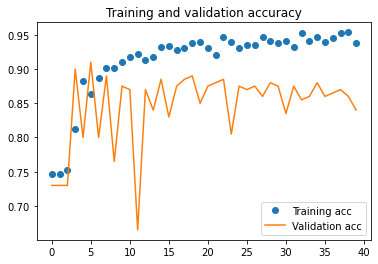

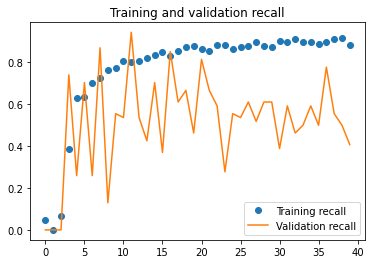

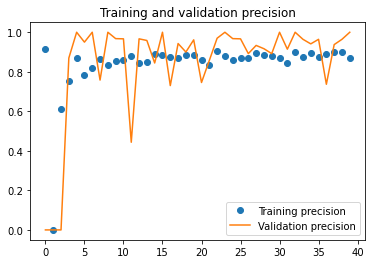

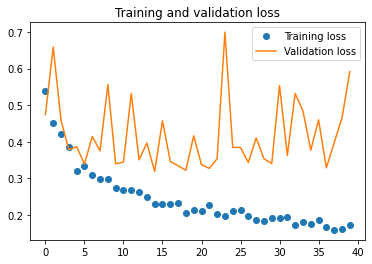

In [12]:
def plotResults(results):
    acc = results.history['acc']
    val_acc = results.history['val_acc']
    loss = results.history['loss']
    val_loss = results.history['val_loss']
    precision = results.history['precision']
    val_precision = results.history['val_precision']
    recall = results.history['recall']
    val_recall = results.history['val_recall']
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'o', label='Training acc')
    plt.plot(epochs, val_acc, label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, recall, 'o', label='Training recall')
    plt.plot(epochs, val_recall, label='Validation recall')
    plt.title('Training and validation recall')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, precision, 'o', label='Training precision')
    plt.plot(epochs, val_precision, label='Validation precision')
    plt.title('Training and validation precision')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, loss, 'o', label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
    
    
plotResults(result_baseline)

In [13]:
#create conv model

model_conv = models.Sequential()
model_conv.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(select_size, select_size, 1)))
model_conv.add(layers.MaxPooling2D((2, 2)))

model_conv.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_conv.add(layers.MaxPooling2D((2, 2)))

model_conv.add(layers.Conv2D(128, (5, 5), activation='relu'))
model_conv.add(layers.MaxPooling2D((2, 2)))

model_conv.add(layers.Flatten())
model_conv.add(layers.Dense(800, activation='relu'))
model_conv.add(layers.Dense(1, activation='sigmoid'))

model_conv.compile(loss='binary_crossentropy',
              optimizer="sgd",
              metrics=[metric_recall, metric_precision, 'acc'])

results_conv = model_conv.fit(train_images,
                              train_y,
                                epochs=20,
                                batch_size=32,
                                validation_data=(val_images, val_y))

Epoch 1/20
50/50 [==============================] - 7s 149ms/step - loss: 0.5998 - recall: 0.0976 - precision: 0.3913 - acc: 0.7219 - val_loss: 0.5741 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_acc: 0.7300
Epoch 2/20
50/50 [==============================] - 7s 141ms/step - loss: 0.5629 - recall: 0.0000e+00 - precision: 0.0000e+00 - acc: 0.7469 - val_loss: 0.5751 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_acc: 0.7300
Epoch 3/20
50/50 [==============================] - 7s 140ms/step - loss: 0.5554 - recall: 0.0000e+00 - precision: 0.0000e+00 - acc: 0.7469 - val_loss: 0.5668 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_acc: 0.7300
Epoch 4/20
50/50 [==============================] - 7s 141ms/step - loss: 0.5507 - recall: 0.0000e+00 - precision: 0.0000e+00 - acc: 0.7469 - val_loss: 0.5555 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_acc: 0.7300
Epoch 5/20
50/50 [==============================] - 7s 139ms/step - loss: 0.5419 - recal

In [14]:
model_conv.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 128)       204928    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)             

7/7 [==============================] - 0s 31ms/step - loss: 0.3207 - recall: 0.6429 - precision: 0.8182 - acc: 0.8600


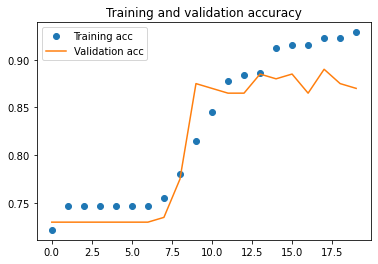

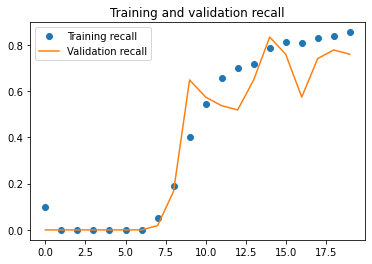

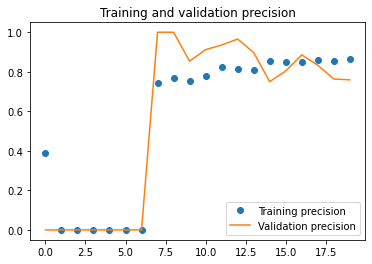

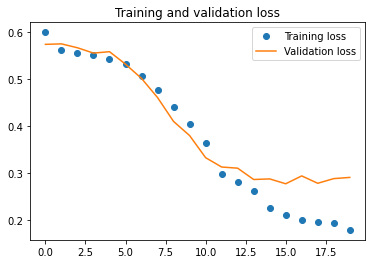

In [15]:
model_conv.evaluate(test_images, test_y)
plotResults(results_conv)

In [16]:
#setup data augmentation
train_gen_aug = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2, 
                                   shear_range=0.3, 
                                   zoom_range=0.1, 
                                   horizontal_flip=False)

train_aug_generator = train_gen_aug.flow_from_directory(
        train_dir, 
        target_size=(select_size, select_size), batch_size=1600,
        color_mode='grayscale')

train_aug_images, train_aug_labels = next(train_generator)
train_aug_y = np.reshape(train_aug_labels[:,0], (-1,1))


Found 4686 images belonging to 2 classes.


In [17]:
#setup early stopping
early_stopping = [EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True), 
                  ModelCheckpoint(filepath='../models/conv_temp1.h5', monitor='val_loss', save_best_only=True)]


In [18]:
model_conv_aug = models.Sequential()
model_conv_aug.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(select_size, select_size, 1)))
model_conv_aug.add(layers.MaxPooling2D((2, 2)))

model_conv_aug.add(layers.Conv2D(64, (3, 3),
                                 activation='relu'))
model_conv_aug.add(layers.MaxPooling2D((2, 2)))

model_conv_aug.add(layers.Conv2D(128, (5, 5),
                                 activation='relu'))
model_conv_aug.add(layers.MaxPooling2D((2, 2)))

model_conv_aug.add(layers.Flatten())
model_conv_aug.add(layers.Dense(800, activation='relu'))
model_conv_aug.add(layers.Dense(400, activation='relu'))
model_conv_aug.add(layers.Dense(1, activation='sigmoid'))

model_conv_aug.compile(loss='binary_crossentropy',
                       optimizer="sgd",
                       metrics=[metric_recall, metric_precision, 'acc'])

results_conv_aug = model_conv_aug.fit(train_aug_images,
                                      train_aug_y,
                                      epochs=30,
                                      batch_size=32,
                                      validation_data=(val_images, val_y),
                                      callbacks=early_stopping)

Epoch 1/30
50/50 [==============================] - 8s 160ms/step - loss: 0.6481 - recall: 0.0899 - precision: 0.5341 - acc: 0.6944 - val_loss: 0.5961 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_acc: 0.7300
Epoch 2/30
50/50 [==============================] - 7s 148ms/step - loss: 0.6049 - recall: 0.0000e+00 - precision: 0.0000e+00 - acc: 0.7081 - val_loss: 0.5780 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_acc: 0.7300
Epoch 3/30
50/50 [==============================] - 8s 150ms/step - loss: 0.5989 - recall: 0.0000e+00 - precision: 0.0000e+00 - acc: 0.7081 - val_loss: 0.5705 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_acc: 0.7300
Epoch 4/30
50/50 [==============================] - 7s 146ms/step - loss: 0.5952 - recall: 0.0000e+00 - precision: 0.0000e+00 - acc: 0.7081 - val_loss: 0.5697 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_acc: 0.7300
Epoch 5/30
50/50 [==============================] - 7s 148ms/step - loss: 0.5884 - recal

In [19]:
model_conv_aug.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 128)       204928    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)             

7/7 [==============================] - 0s 31ms/step - loss: 0.3855 - recall: 0.5893 - precision: 0.8684 - acc: 0.8600


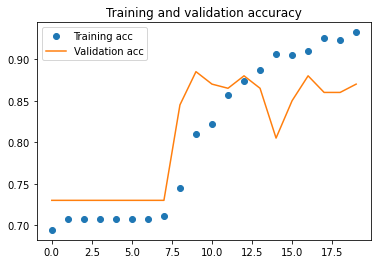

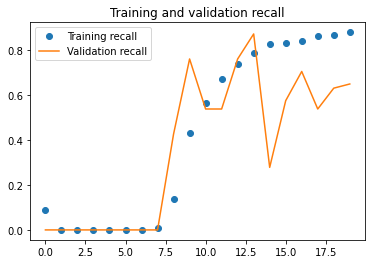

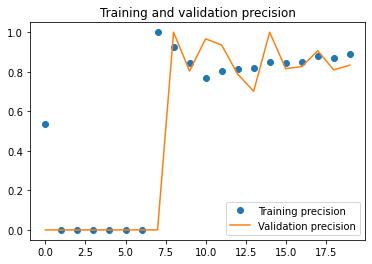

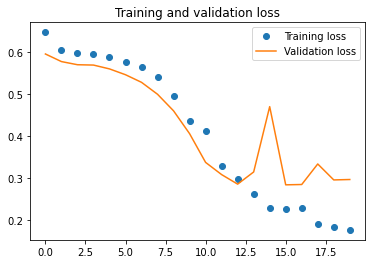

In [20]:
model_conv_aug.evaluate(test_images, test_y)
plotResults(results_conv_aug)

In [40]:
#setup custom decision threshold
threshold = 0.1
predictions_raw = model_conv_aug.predict(test_images)
preds = predictions_raw > threshold
print('Recall:', recall_score(test_y, preds))
print('Precision:', precision_score(test_y, preds))
print('Accuracy:', accuracy_score(test_y, preds))

Recall: 0.8571428571428571
Precision: 0.6666666666666666
Accuracy: 0.84


In [41]:
#setup feature extraction
#load images in color

test_generator_color = train_gen_aug.flow_from_directory(
        test_dir, 
        target_size=(select_size, select_size), batch_size = 200) 

val_generator_color = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_dir, 
        target_size=(select_size, select_size), batch_size = 200)

train_generator_color = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_dir, 
        target_size=(select_size, select_size), batch_size=1600)

train_images_color, train_labels_color = next(train_generator_color)
test_images_color, test_labels_color = next(test_generator_color)
val_images_color, val_labels_color = next(val_generator_color)

train_y_color = np.reshape(train_labels_color[:,0], (-1,1))
test_y_color = np.reshape(test_labels_color[:,0], (-1,1))
val_y_color = np.reshape(val_labels_color[:,0], (-1,1))




#load model

vgg = VGG19(weights='imagenet',
           include_top=False,
           input_shape=(select_size, select_size, 3))

vgg.trainable = False

Found 585 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 4686 images belonging to 2 classes.


In [42]:
model_transfer = models.Sequential()
model_transfer.add(vgg)

model_transfer.add(layers.Flatten())
model_transfer.add(layers.Dense(1024, activation='relu'))
model_transfer.add(layers.Dense(1, activation='sigmoid'))

model_transfer.compile(loss='binary_crossentropy',
                       optimizer="sgd",
                       metrics=[metric_recall, metric_precision, 'acc'])

for layer in model_transfer.layers:
    print(layer.name, 'Trainable:', layer.trainable)

results_transfer = model_transfer.fit(train_images_color,
                                      train_y_color,
                                      epochs=30,
                                      batch_size=32,
                                      validation_data=(val_images_color, val_y_color),
                                      callbacks=early_stopping)

vgg19 Trainable: False
flatten_2 Trainable: True
dense_13 Trainable: True
dense_14 Trainable: True
Epoch 1/15
50/50 [==============================] - 57s 1s/step - loss: 0.4315 - recall: 0.4756 - precision: 0.7335 - acc: 0.8031 - val_loss: 0.5238 - val_recall: 0.1500 - val_precision: 0.7500 - val_acc: 0.7300
Epoch 2/15
50/50 [==============================] - 60s 1s/step - loss: 0.3335 - recall: 0.6193 - precision: 0.8012 - acc: 0.8544 - val_loss: 0.4130 - val_recall: 0.5667 - val_precision: 0.7556 - val_acc: 0.8150
Epoch 3/15
50/50 [==============================] - 60s 1s/step - loss: 0.2991 - recall: 0.7087 - precision: 0.8196 - acc: 0.8781 - val_loss: 0.4244 - val_recall: 0.5000 - val_precision: 0.8571 - val_acc: 0.8250
Epoch 4/15
50/50 [==============================] - 56s 1s/step - loss: 0.2697 - recall: 0.7179 - precision: 0.8172 - acc: 0.8794 - val_loss: 0.3611 - val_recall: 0.7167 - val_precision: 0.7963 - val_acc: 0.8600
Epoch 5/15
50/50 [==============================] - 5

In [43]:
model_transfer.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 2, 2, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 1025      
Total params: 22,123,585
Trainable params: 2,099,201
Non-trainable params: 20,024,384
_________________________________________________________________


7/7 [==============================] - 5s 747ms/step - loss: 0.7922 - recall: 0.0926 - precision: 0.8333 - acc: 0.7500


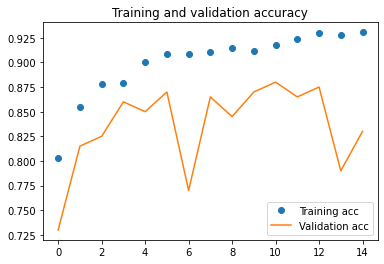

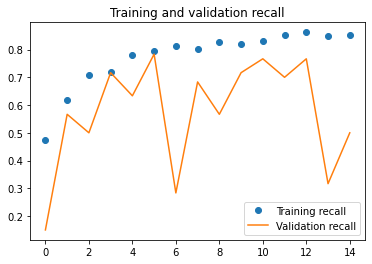

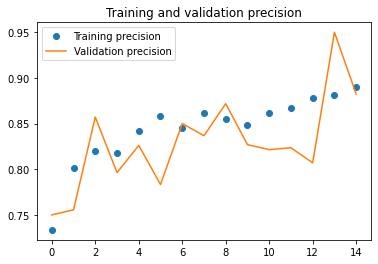

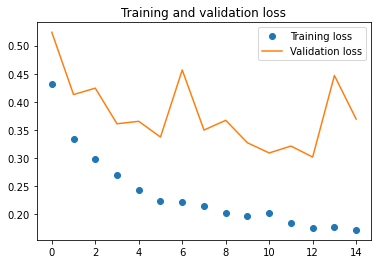

In [44]:
model_transfer.evaluate(test_images_color, test_y_color)
plotResults(results_transfer)

In [ ]:
predictions_raw = model_transfer.predict(test_images_color)

In [49]:
threshold = 0.1
preds = predictions_raw > threshold
print('Recall:', recall_score(test_y_color, preds))
print('Precision:', precision_score(test_y_color, preds))
print('Accuracy:', accuracy_score(test_y_color, preds))

Recall: 0.4444444444444444
Precision: 0.6857142857142857
Accuracy: 0.795


In [59]:
vgg_tune = VGG19(weights='imagenet',
           include_top=False,
           input_shape=(select_size, select_size, 3))


for layer in vgg_tune.layers:
    if 'block5' not in layer.name:
        layer.trainable = False
        
for layer in vgg_tune.layers:
    print(layer.name, 'Trainable:', layer.trainable)

input_8 Trainable: False
block1_conv1 Trainable: False
block1_conv2 Trainable: False
block1_pool Trainable: False
block2_conv1 Trainable: False
block2_conv2 Trainable: False
block2_pool Trainable: False
block3_conv1 Trainable: False
block3_conv2 Trainable: False
block3_conv3 Trainable: False
block3_conv4 Trainable: False
block3_pool Trainable: False
block4_conv1 Trainable: False
block4_conv2 Trainable: False
block4_conv3 Trainable: False
block4_conv4 Trainable: False
block4_pool Trainable: False
block5_conv1 Trainable: True
block5_conv2 Trainable: True
block5_conv3 Trainable: True
block5_conv4 Trainable: True
block5_pool Trainable: True


In [60]:

model_transfer_tune = models.Sequential()
model_transfer_tune.add(vgg_tune)

model_transfer_tune.add(layers.Flatten())
model_transfer_tune.add(layers.Dense(1024, activation='relu'))
model_transfer_tune.add(layers.Dense(1, activation='sigmoid'))

model_transfer_tune.compile(loss='binary_crossentropy',
                       optimizer="sgd",
                       metrics=[metric_recall, metric_precision, 'acc'])


results_transfer_tune = model_transfer_tune.fit(train_images_color,
                                           train_y_color,
                                           epochs=30,
                                           batch_size=32,
                                           validation_data=(val_images_color, val_y_color),
                                           callbacks=early_stopping)

Epoch 1/30
50/50 [==============================] - 74s 1s/step - loss: 0.4743 - recall: 0.4245 - precision: 0.6190 - acc: 0.7750 - val_loss: 0.3020 - val_recall: 0.7333 - val_precision: 0.8462 - val_acc: 0.8800
Epoch 2/30
50/50 [==============================] - 73s 1s/step - loss: 0.2081 - recall: 0.8647 - precision: 0.8249 - acc: 0.9131 - val_loss: 0.3637 - val_recall: 0.5667 - val_precision: 0.9189 - val_acc: 0.8550
Epoch 3/30
50/50 [==============================] - 73s 1s/step - loss: 0.1960 - recall: 0.8716 - precision: 0.8501 - acc: 0.9231 - val_loss: 0.2908 - val_recall: 0.6333 - val_precision: 0.9268 - val_acc: 0.8750
Epoch 4/30
50/50 [==============================] - 73s 1s/step - loss: 0.1280 - recall: 0.9151 - precision: 0.9007 - acc: 0.9494 - val_loss: 0.9561 - val_recall: 0.2500 - val_precision: 1.0000 - val_acc: 0.7750
Epoch 5/30
50/50 [==============================] - 73s 1s/step - loss: 0.1146 - recall: 0.9266 - precision: 0.9058 - acc: 0.9538 - val_loss: 1.0435 - v

7/7 [==============================] - 5s 765ms/step - loss: 0.6918 - recall: 0.0741 - precision: 0.8000 - acc: 0.7450


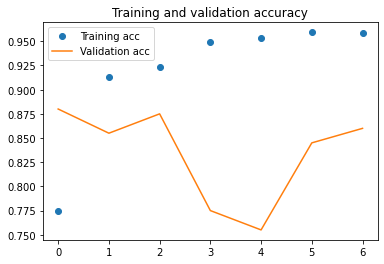

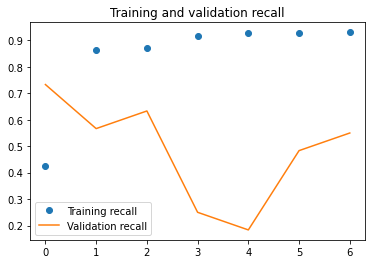

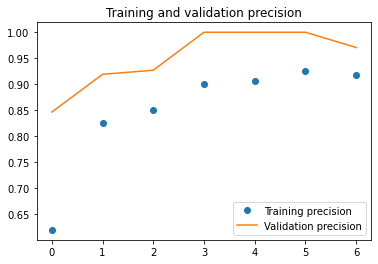

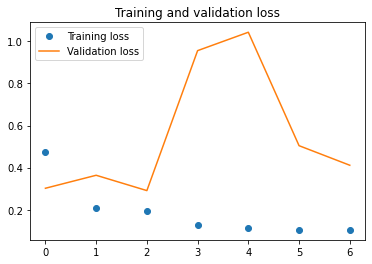

In [62]:
model_transfer_tune.evaluate(test_images_color, test_y_color)
plotResults(results_transfer_tune)

In [63]:
predictions_raw = model_transfer_tune.predict(test_images_color)

In [69]:
threshold = 0.05
preds = predictions_raw > threshold
print('Recall:', recall_score(test_y_color, preds))
print('Precision:', precision_score(test_y_color, preds))
print('Accuracy:', accuracy_score(test_y_color, preds))

Recall: 0.6296296296296297
Precision: 0.6415094339622641
Accuracy: 0.805
